# Suo

In [1]:
import warnings
import os
import sys
import gc
import warnings

In [2]:
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
tardis.config = tardis.config_server

In [3]:
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [5]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "dataset_complete_Suo_age.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["age"] = adata.obs["age"].astype(float)
adata.obs["age_categorical"] = adata.obs["age"].astype(str)
d = {i: ind for ind, i in enumerate(sorted(adata.obs["age"].astype(float).unique()))}
adata.obs["age_training"] = [d[float(i)] for i in adata.obs["age"]]
print(adata_file_path, flush=True)
print(adata, flush=True)

/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/processed/dataset_complete_Suo_age.h5ad


AnnData object with n_obs × n_vars = 73697 × 8192
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse', 'n_genes', 'age_categorical', 'age_training'
    uns: 'rank_genes_groups'
    obsm: 'Unintegrated', 'X_pca', 'harmony'


In [6]:
model_level_metrics = [
    dict(
        metric_identifier = "metric_mi|age_categorical",
        training_set = ["train", "validation"],
        every_n_epoch = 5,
        subsample = 0.25,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 512,
            latent_subset=None,
            reduce=np.mean
        )
    )
]

In [7]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = "age_training",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="pseudo_categorical",
                non_categorical_coefficient_method="squared_difference",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]

In [8]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(12 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.25,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates=True
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=128,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-4,
        weight_decay=1e-4,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=model_level_metrics,
    model_level_metrics_helper_covariates=['age_categorical']
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

tardis.MyModel.setup_wandb(
    wandb_configurations=tardis.config.wandb,
    hyperparams=dict(
        model_params=model_params,
        train_params=train_params,
        dataset_params=dataset_params,
    )
)

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

dir_path = os.path.join(
    tardis.config.io_directories["models"],
    "suo_age-continuous_7"
)

vae.save(
    dir_path,
    overwrite=True,
)

W&B logger initialized with the following parameters: 
Entity: inecik-academic
Project: tardis_conference
ID: k2i29djl
Name: snowy-terrain-581
Tags: tardis, conference, figures, final
Notes: Final runs for Tardis before conference.
URL: https://wandb.ai/inecik-academic/tardis_conference/runs/k2i29djl
Directory: /lustre/groups/ml01/workspace/kemal.inecik/wandb/run-20240506_182846-k2i29djl/files



/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `age_training` for `training` set. Number of elements in each group: 6655,15193,18844,4820,7550,5896
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `age_training` for `validation` set. Number of elements in each group: 1689,3772,4768,1193,1894,1423
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:34<5:43:46, 34.43s/it]

Epoch 1/600:   0%|          | 1/600 [00:34<5:43:46, 34.43s/it, v_num=jl_1, total_loss_train=593, kl_local_train=38.7]

Epoch 2/600:   0%|          | 1/600 [00:34<5:43:46, 34.43s/it, v_num=jl_1, total_loss_train=593, kl_local_train=38.7]

Epoch 2/600:   0%|          | 2/600 [01:05<5:20:49, 32.19s/it, v_num=jl_1, total_loss_train=593, kl_local_train=38.7]

Epoch 2/600:   0%|          | 2/600 [01:05<5:20:49, 32.19s/it, v_num=jl_1, total_loss_train=458, kl_local_train=58.2]

Epoch 3/600:   0%|          | 2/600 [01:05<5:20:49, 32.19s/it, v_num=jl_1, total_loss_train=458, kl_local_train=58.2]

Epoch 3/600:   0%|          | 3/600 [01:35<5:12:24, 31.40s/it, v_num=jl_1, total_loss_train=458, kl_local_train=58.2]

Epoch 3/600:   0%|          | 3/600 [01:35<5:12:24, 31.40s/it, v_num=jl_1, total_loss_train=440, kl_local_train=63.2]

Epoch 4/600:   0%|          | 3/600 [01:35<5:12:24, 31.40s/it, v_num=jl_1, total_loss_train=440, kl_local_train=63.2]

Epoch 4/600:   1%|          | 4/600 [02:05<5:07:59, 31.01s/it, v_num=jl_1, total_loss_train=440, kl_local_train=63.2]

Epoch 4/600:   1%|          | 4/600 [02:05<5:07:59, 31.01s/it, v_num=jl_1, total_loss_train=433, kl_local_train=64.4]

Epoch 5/600:   1%|          | 4/600 [02:05<5:07:59, 31.01s/it, v_num=jl_1, total_loss_train=433, kl_local_train=64.4]

Epoch 5/600:   1%|          | 5/600 [02:37<5:10:02, 31.26s/it, v_num=jl_1, total_loss_train=433, kl_local_train=64.4]

Epoch 5/600:   1%|          | 5/600 [02:37<5:10:02, 31.26s/it, v_num=jl_1, total_loss_train=428, kl_local_train=64.6]

Epoch 6/600:   1%|          | 5/600 [02:38<5:10:02, 31.26s/it, v_num=jl_1, total_loss_train=428, kl_local_train=64.6]

Epoch 6/600:   1%|          | 6/600 [03:06<5:01:00, 30.41s/it, v_num=jl_1, total_loss_train=428, kl_local_train=64.6]

Epoch 6/600:   1%|          | 6/600 [03:06<5:01:00, 30.41s/it, v_num=jl_1, total_loss_train=425, kl_local_train=63.6, metric_mi|age_categorical_train=0.0751]

Epoch 7/600:   1%|          | 6/600 [03:06<5:01:00, 30.41s/it, v_num=jl_1, total_loss_train=425, kl_local_train=63.6, metric_mi|age_categorical_train=0.0751]

Epoch 7/600:   1%|          | 7/600 [03:35<4:55:05, 29.86s/it, v_num=jl_1, total_loss_train=425, kl_local_train=63.6, metric_mi|age_categorical_train=0.0751]

Epoch 7/600:   1%|          | 7/600 [03:35<4:55:05, 29.86s/it, v_num=jl_1, total_loss_train=422, kl_local_train=62.1, metric_mi|age_categorical_train=0.0751]

Epoch 8/600:   1%|          | 7/600 [03:35<4:55:05, 29.86s/it, v_num=jl_1, total_loss_train=422, kl_local_train=62.1, metric_mi|age_categorical_train=0.0751]

Epoch 8/600:   1%|▏         | 8/600 [04:03<4:50:56, 29.49s/it, v_num=jl_1, total_loss_train=422, kl_local_train=62.1, metric_mi|age_categorical_train=0.0751]

Epoch 8/600:   1%|▏         | 8/600 [04:03<4:50:56, 29.49s/it, v_num=jl_1, total_loss_train=427, kl_local_train=56.5, metric_mi|age_categorical_train=0.0751]

Epoch 9/600:   1%|▏         | 8/600 [04:03<4:50:56, 29.49s/it, v_num=jl_1, total_loss_train=427, kl_local_train=56.5, metric_mi|age_categorical_train=0.0751]

Epoch 9/600:   2%|▏         | 9/600 [04:32<4:47:21, 29.17s/it, v_num=jl_1, total_loss_train=427, kl_local_train=56.5, metric_mi|age_categorical_train=0.0751]

Epoch 9/600:   2%|▏         | 9/600 [04:32<4:47:21, 29.17s/it, v_num=jl_1, total_loss_train=430, kl_local_train=49.9, metric_mi|age_categorical_train=0.0751]

Epoch 10/600:   2%|▏         | 9/600 [04:32<4:47:21, 29.17s/it, v_num=jl_1, total_loss_train=430, kl_local_train=49.9, metric_mi|age_categorical_train=0.0751]

Epoch 10/600:   2%|▏         | 10/600 [05:02<4:49:19, 29.42s/it, v_num=jl_1, total_loss_train=430, kl_local_train=49.9, metric_mi|age_categorical_train=0.0751]

Epoch 10/600:   2%|▏         | 10/600 [05:02<4:49:19, 29.42s/it, v_num=jl_1, total_loss_train=431, kl_local_train=66.9, metric_mi|age_categorical_train=0.0751]

Epoch 11/600:   2%|▏         | 10/600 [05:03<4:49:19, 29.42s/it, v_num=jl_1, total_loss_train=431, kl_local_train=66.9, metric_mi|age_categorical_train=0.0751]

Epoch 11/600:   2%|▏         | 11/600 [05:31<4:48:35, 29.40s/it, v_num=jl_1, total_loss_train=431, kl_local_train=66.9, metric_mi|age_categorical_train=0.0751]

Epoch 11/600:   2%|▏         | 11/600 [05:31<4:48:35, 29.40s/it, v_num=jl_1, total_loss_train=429, kl_local_train=88.4, metric_mi|age_categorical_train=0.0976]

Epoch 12/600:   2%|▏         | 11/600 [05:31<4:48:35, 29.40s/it, v_num=jl_1, total_loss_train=429, kl_local_train=88.4, metric_mi|age_categorical_train=0.0976]

Epoch 12/600:   2%|▏         | 12/600 [06:00<4:45:24, 29.12s/it, v_num=jl_1, total_loss_train=429, kl_local_train=88.4, metric_mi|age_categorical_train=0.0976]

Epoch 12/600:   2%|▏         | 12/600 [06:00<4:45:24, 29.12s/it, v_num=jl_1, total_loss_train=429, kl_local_train=95.4, metric_mi|age_categorical_train=0.0976]

Epoch 13/600:   2%|▏         | 12/600 [06:00<4:45:24, 29.12s/it, v_num=jl_1, total_loss_train=429, kl_local_train=95.4, metric_mi|age_categorical_train=0.0976]

Epoch 13/600:   2%|▏         | 13/600 [06:28<4:43:19, 28.96s/it, v_num=jl_1, total_loss_train=429, kl_local_train=95.4, metric_mi|age_categorical_train=0.0976]

Epoch 13/600:   2%|▏         | 13/600 [06:28<4:43:19, 28.96s/it, v_num=jl_1, total_loss_train=429, kl_local_train=118, metric_mi|age_categorical_train=0.0976] 

Epoch 14/600:   2%|▏         | 13/600 [06:28<4:43:19, 28.96s/it, v_num=jl_1, total_loss_train=429, kl_local_train=118, metric_mi|age_categorical_train=0.0976]

Epoch 14/600:   2%|▏         | 14/600 [06:57<4:41:17, 28.80s/it, v_num=jl_1, total_loss_train=429, kl_local_train=118, metric_mi|age_categorical_train=0.0976]

Epoch 14/600:   2%|▏         | 14/600 [06:57<4:41:17, 28.80s/it, v_num=jl_1, total_loss_train=429, kl_local_train=142, metric_mi|age_categorical_train=0.0976]

Epoch 15/600:   2%|▏         | 14/600 [06:57<4:41:17, 28.80s/it, v_num=jl_1, total_loss_train=429, kl_local_train=142, metric_mi|age_categorical_train=0.0976]

Epoch 15/600:   2%|▎         | 15/600 [07:26<4:43:11, 29.05s/it, v_num=jl_1, total_loss_train=429, kl_local_train=142, metric_mi|age_categorical_train=0.0976]

Epoch 15/600:   2%|▎         | 15/600 [07:26<4:43:11, 29.05s/it, v_num=jl_1, total_loss_train=430, kl_local_train=155, metric_mi|age_categorical_train=0.0976]

Epoch 16/600:   2%|▎         | 15/600 [07:27<4:43:11, 29.05s/it, v_num=jl_1, total_loss_train=430, kl_local_train=155, metric_mi|age_categorical_train=0.0976]

Epoch 16/600:   3%|▎         | 16/600 [07:56<4:43:37, 29.14s/it, v_num=jl_1, total_loss_train=430, kl_local_train=155, metric_mi|age_categorical_train=0.0976]

Epoch 16/600:   3%|▎         | 16/600 [07:56<4:43:37, 29.14s/it, v_num=jl_1, total_loss_train=431, kl_local_train=172, metric_mi|age_categorical_train=0.259] 

Epoch 17/600:   3%|▎         | 16/600 [07:56<4:43:37, 29.14s/it, v_num=jl_1, total_loss_train=431, kl_local_train=172, metric_mi|age_categorical_train=0.259]

Epoch 17/600:   3%|▎         | 17/600 [08:24<4:40:16, 28.84s/it, v_num=jl_1, total_loss_train=431, kl_local_train=172, metric_mi|age_categorical_train=0.259]

Epoch 17/600:   3%|▎         | 17/600 [08:24<4:40:16, 28.84s/it, v_num=jl_1, total_loss_train=432, kl_local_train=193, metric_mi|age_categorical_train=0.259]

Epoch 18/600:   3%|▎         | 17/600 [08:24<4:40:16, 28.84s/it, v_num=jl_1, total_loss_train=432, kl_local_train=193, metric_mi|age_categorical_train=0.259]

Epoch 18/600:   3%|▎         | 18/600 [08:52<4:37:52, 28.65s/it, v_num=jl_1, total_loss_train=432, kl_local_train=193, metric_mi|age_categorical_train=0.259]

Epoch 18/600:   3%|▎         | 18/600 [08:52<4:37:52, 28.65s/it, v_num=jl_1, total_loss_train=433, kl_local_train=197, metric_mi|age_categorical_train=0.259]

Epoch 19/600:   3%|▎         | 18/600 [08:52<4:37:52, 28.65s/it, v_num=jl_1, total_loss_train=433, kl_local_train=197, metric_mi|age_categorical_train=0.259]

Epoch 19/600:   3%|▎         | 19/600 [09:20<4:36:00, 28.50s/it, v_num=jl_1, total_loss_train=433, kl_local_train=197, metric_mi|age_categorical_train=0.259]

Epoch 19/600:   3%|▎         | 19/600 [09:20<4:36:00, 28.50s/it, v_num=jl_1, total_loss_train=434, kl_local_train=205, metric_mi|age_categorical_train=0.259]

Epoch 20/600:   3%|▎         | 19/600 [09:20<4:36:00, 28.50s/it, v_num=jl_1, total_loss_train=434, kl_local_train=205, metric_mi|age_categorical_train=0.259]

Epoch 20/600:   3%|▎         | 20/600 [09:49<4:37:41, 28.73s/it, v_num=jl_1, total_loss_train=434, kl_local_train=205, metric_mi|age_categorical_train=0.259]

Epoch 20/600:   3%|▎         | 20/600 [09:49<4:37:41, 28.73s/it, v_num=jl_1, total_loss_train=435, kl_local_train=207, metric_mi|age_categorical_train=0.259]

Epoch 21/600:   3%|▎         | 20/600 [09:50<4:37:41, 28.73s/it, v_num=jl_1, total_loss_train=435, kl_local_train=207, metric_mi|age_categorical_train=0.259]

Epoch 21/600:   4%|▎         | 21/600 [10:18<4:37:57, 28.80s/it, v_num=jl_1, total_loss_train=435, kl_local_train=207, metric_mi|age_categorical_train=0.259]

Epoch 21/600:   4%|▎         | 21/600 [10:18<4:37:57, 28.80s/it, v_num=jl_1, total_loss_train=436, kl_local_train=203, metric_mi|age_categorical_train=0.329]

Epoch 22/600:   4%|▎         | 21/600 [10:18<4:37:57, 28.80s/it, v_num=jl_1, total_loss_train=436, kl_local_train=203, metric_mi|age_categorical_train=0.329]

Epoch 22/600:   4%|▎         | 22/600 [10:47<4:36:29, 28.70s/it, v_num=jl_1, total_loss_train=436, kl_local_train=203, metric_mi|age_categorical_train=0.329]

Epoch 22/600:   4%|▎         | 22/600 [10:47<4:36:29, 28.70s/it, v_num=jl_1, total_loss_train=437, kl_local_train=201, metric_mi|age_categorical_train=0.329]

Epoch 23/600:   4%|▎         | 22/600 [10:47<4:36:29, 28.70s/it, v_num=jl_1, total_loss_train=437, kl_local_train=201, metric_mi|age_categorical_train=0.329]

Epoch 23/600:   4%|▍         | 23/600 [11:15<4:35:58, 28.70s/it, v_num=jl_1, total_loss_train=437, kl_local_train=201, metric_mi|age_categorical_train=0.329]

Epoch 23/600:   4%|▍         | 23/600 [11:15<4:35:58, 28.70s/it, v_num=jl_1, total_loss_train=438, kl_local_train=202, metric_mi|age_categorical_train=0.329]

Epoch 24/600:   4%|▍         | 23/600 [11:15<4:35:58, 28.70s/it, v_num=jl_1, total_loss_train=438, kl_local_train=202, metric_mi|age_categorical_train=0.329]

Epoch 24/600:   4%|▍         | 24/600 [11:44<4:35:10, 28.66s/it, v_num=jl_1, total_loss_train=438, kl_local_train=202, metric_mi|age_categorical_train=0.329]

Epoch 24/600:   4%|▍         | 24/600 [11:44<4:35:10, 28.66s/it, v_num=jl_1, total_loss_train=439, kl_local_train=209, metric_mi|age_categorical_train=0.329]

Epoch 25/600:   4%|▍         | 24/600 [11:44<4:35:10, 28.66s/it, v_num=jl_1, total_loss_train=439, kl_local_train=209, metric_mi|age_categorical_train=0.329]

Epoch 25/600:   4%|▍         | 25/600 [12:14<4:37:34, 28.96s/it, v_num=jl_1, total_loss_train=439, kl_local_train=209, metric_mi|age_categorical_train=0.329]

Epoch 25/600:   4%|▍         | 25/600 [12:14<4:37:34, 28.96s/it, v_num=jl_1, total_loss_train=440, kl_local_train=218, metric_mi|age_categorical_train=0.329]

Epoch 26/600:   4%|▍         | 25/600 [12:14<4:37:34, 28.96s/it, v_num=jl_1, total_loss_train=440, kl_local_train=218, metric_mi|age_categorical_train=0.329]

Epoch 26/600:   4%|▍         | 26/600 [12:43<4:37:35, 29.02s/it, v_num=jl_1, total_loss_train=440, kl_local_train=218, metric_mi|age_categorical_train=0.329]

Epoch 26/600:   4%|▍         | 26/600 [12:43<4:37:35, 29.02s/it, v_num=jl_1, total_loss_train=441, kl_local_train=203, metric_mi|age_categorical_train=0.407]

Epoch 27/600:   4%|▍         | 26/600 [12:43<4:37:35, 29.02s/it, v_num=jl_1, total_loss_train=441, kl_local_train=203, metric_mi|age_categorical_train=0.407]

Epoch 27/600:   4%|▍         | 27/600 [13:12<4:36:30, 28.95s/it, v_num=jl_1, total_loss_train=441, kl_local_train=203, metric_mi|age_categorical_train=0.407]

Epoch 27/600:   4%|▍         | 27/600 [13:12<4:36:30, 28.95s/it, v_num=jl_1, total_loss_train=443, kl_local_train=216, metric_mi|age_categorical_train=0.407]

Epoch 28/600:   4%|▍         | 27/600 [13:12<4:36:30, 28.95s/it, v_num=jl_1, total_loss_train=443, kl_local_train=216, metric_mi|age_categorical_train=0.407]

Epoch 28/600:   5%|▍         | 28/600 [13:40<4:34:33, 28.80s/it, v_num=jl_1, total_loss_train=443, kl_local_train=216, metric_mi|age_categorical_train=0.407]

Epoch 28/600:   5%|▍         | 28/600 [13:40<4:34:33, 28.80s/it, v_num=jl_1, total_loss_train=444, kl_local_train=212, metric_mi|age_categorical_train=0.407]

Epoch 29/600:   5%|▍         | 28/600 [13:40<4:34:33, 28.80s/it, v_num=jl_1, total_loss_train=444, kl_local_train=212, metric_mi|age_categorical_train=0.407]

Epoch 29/600:   5%|▍         | 29/600 [14:09<4:33:02, 28.69s/it, v_num=jl_1, total_loss_train=444, kl_local_train=212, metric_mi|age_categorical_train=0.407]

Epoch 29/600:   5%|▍         | 29/600 [14:09<4:33:02, 28.69s/it, v_num=jl_1, total_loss_train=445, kl_local_train=201, metric_mi|age_categorical_train=0.407]

Epoch 30/600:   5%|▍         | 29/600 [14:09<4:33:02, 28.69s/it, v_num=jl_1, total_loss_train=445, kl_local_train=201, metric_mi|age_categorical_train=0.407]

Epoch 30/600:   5%|▌         | 30/600 [14:38<4:34:55, 28.94s/it, v_num=jl_1, total_loss_train=445, kl_local_train=201, metric_mi|age_categorical_train=0.407]

Epoch 30/600:   5%|▌         | 30/600 [14:38<4:34:55, 28.94s/it, v_num=jl_1, total_loss_train=446, kl_local_train=199, metric_mi|age_categorical_train=0.407]

Epoch 31/600:   5%|▌         | 30/600 [14:39<4:34:55, 28.94s/it, v_num=jl_1, total_loss_train=446, kl_local_train=199, metric_mi|age_categorical_train=0.407]

Epoch 31/600:   5%|▌         | 31/600 [15:07<4:34:59, 29.00s/it, v_num=jl_1, total_loss_train=446, kl_local_train=199, metric_mi|age_categorical_train=0.407]

Epoch 31/600:   5%|▌         | 31/600 [15:07<4:34:59, 29.00s/it, v_num=jl_1, total_loss_train=447, kl_local_train=201, metric_mi|age_categorical_train=0.43] 

Epoch 32/600:   5%|▌         | 31/600 [15:07<4:34:59, 29.00s/it, v_num=jl_1, total_loss_train=447, kl_local_train=201, metric_mi|age_categorical_train=0.43]

Epoch 32/600:   5%|▌         | 32/600 [15:36<4:33:38, 28.91s/it, v_num=jl_1, total_loss_train=447, kl_local_train=201, metric_mi|age_categorical_train=0.43]

Epoch 32/600:   5%|▌         | 32/600 [15:36<4:33:38, 28.91s/it, v_num=jl_1, total_loss_train=448, kl_local_train=202, metric_mi|age_categorical_train=0.43]

Epoch 33/600:   5%|▌         | 32/600 [15:36<4:33:38, 28.91s/it, v_num=jl_1, total_loss_train=448, kl_local_train=202, metric_mi|age_categorical_train=0.43]

Epoch 33/600:   6%|▌         | 33/600 [16:04<4:31:25, 28.72s/it, v_num=jl_1, total_loss_train=448, kl_local_train=202, metric_mi|age_categorical_train=0.43]

Epoch 33/600:   6%|▌         | 33/600 [16:04<4:31:25, 28.72s/it, v_num=jl_1, total_loss_train=449, kl_local_train=194, metric_mi|age_categorical_train=0.43]

Epoch 34/600:   6%|▌         | 33/600 [16:04<4:31:25, 28.72s/it, v_num=jl_1, total_loss_train=449, kl_local_train=194, metric_mi|age_categorical_train=0.43]

Epoch 34/600:   6%|▌         | 34/600 [16:32<4:28:57, 28.51s/it, v_num=jl_1, total_loss_train=449, kl_local_train=194, metric_mi|age_categorical_train=0.43]

Epoch 34/600:   6%|▌         | 34/600 [16:32<4:28:57, 28.51s/it, v_num=jl_1, total_loss_train=451, kl_local_train=202, metric_mi|age_categorical_train=0.43]

Epoch 35/600:   6%|▌         | 34/600 [16:32<4:28:57, 28.51s/it, v_num=jl_1, total_loss_train=451, kl_local_train=202, metric_mi|age_categorical_train=0.43]

Epoch 35/600:   6%|▌         | 35/600 [17:01<4:29:48, 28.65s/it, v_num=jl_1, total_loss_train=451, kl_local_train=202, metric_mi|age_categorical_train=0.43]

Epoch 35/600:   6%|▌         | 35/600 [17:01<4:29:48, 28.65s/it, v_num=jl_1, total_loss_train=452, kl_local_train=190, metric_mi|age_categorical_train=0.43]

Epoch 36/600:   6%|▌         | 35/600 [17:02<4:29:48, 28.65s/it, v_num=jl_1, total_loss_train=452, kl_local_train=190, metric_mi|age_categorical_train=0.43]

Epoch 36/600:   6%|▌         | 36/600 [17:30<4:29:58, 28.72s/it, v_num=jl_1, total_loss_train=452, kl_local_train=190, metric_mi|age_categorical_train=0.43]

Epoch 36/600:   6%|▌         | 36/600 [17:30<4:29:58, 28.72s/it, v_num=jl_1, total_loss_train=453, kl_local_train=195, metric_mi|age_categorical_train=0.431]

Epoch 37/600:   6%|▌         | 36/600 [17:30<4:29:58, 28.72s/it, v_num=jl_1, total_loss_train=453, kl_local_train=195, metric_mi|age_categorical_train=0.431]

Epoch 37/600:   6%|▌         | 37/600 [17:59<4:29:04, 28.68s/it, v_num=jl_1, total_loss_train=453, kl_local_train=195, metric_mi|age_categorical_train=0.431]

Epoch 37/600:   6%|▌         | 37/600 [17:59<4:29:04, 28.68s/it, v_num=jl_1, total_loss_train=455, kl_local_train=199, metric_mi|age_categorical_train=0.431]

Epoch 38/600:   6%|▌         | 37/600 [17:59<4:29:04, 28.68s/it, v_num=jl_1, total_loss_train=455, kl_local_train=199, metric_mi|age_categorical_train=0.431]

Epoch 38/600:   6%|▋         | 38/600 [18:27<4:28:56, 28.71s/it, v_num=jl_1, total_loss_train=455, kl_local_train=199, metric_mi|age_categorical_train=0.431]

Epoch 38/600:   6%|▋         | 38/600 [18:27<4:28:56, 28.71s/it, v_num=jl_1, total_loss_train=456, kl_local_train=190, metric_mi|age_categorical_train=0.431]

Epoch 39/600:   6%|▋         | 38/600 [18:27<4:28:56, 28.71s/it, v_num=jl_1, total_loss_train=456, kl_local_train=190, metric_mi|age_categorical_train=0.431]

Epoch 39/600:   6%|▋         | 39/600 [18:56<4:27:49, 28.64s/it, v_num=jl_1, total_loss_train=456, kl_local_train=190, metric_mi|age_categorical_train=0.431]

Epoch 39/600:   6%|▋         | 39/600 [18:56<4:27:49, 28.64s/it, v_num=jl_1, total_loss_train=457, kl_local_train=188, metric_mi|age_categorical_train=0.431]

Epoch 40/600:   6%|▋         | 39/600 [18:56<4:27:49, 28.64s/it, v_num=jl_1, total_loss_train=457, kl_local_train=188, metric_mi|age_categorical_train=0.431]

Epoch 40/600:   7%|▋         | 40/600 [19:25<4:29:15, 28.85s/it, v_num=jl_1, total_loss_train=457, kl_local_train=188, metric_mi|age_categorical_train=0.431]

Epoch 40/600:   7%|▋         | 40/600 [19:25<4:29:15, 28.85s/it, v_num=jl_1, total_loss_train=459, kl_local_train=191, metric_mi|age_categorical_train=0.431]

Epoch 41/600:   7%|▋         | 40/600 [19:26<4:29:15, 28.85s/it, v_num=jl_1, total_loss_train=459, kl_local_train=191, metric_mi|age_categorical_train=0.431]

Epoch 41/600:   7%|▋         | 41/600 [19:54<4:29:06, 28.88s/it, v_num=jl_1, total_loss_train=459, kl_local_train=191, metric_mi|age_categorical_train=0.431]

Epoch 41/600:   7%|▋         | 41/600 [19:54<4:29:06, 28.88s/it, v_num=jl_1, total_loss_train=460, kl_local_train=182, metric_mi|age_categorical_train=0.433]

Epoch 42/600:   7%|▋         | 41/600 [19:54<4:29:06, 28.88s/it, v_num=jl_1, total_loss_train=460, kl_local_train=182, metric_mi|age_categorical_train=0.433]

Epoch 42/600:   7%|▋         | 42/600 [20:23<4:27:03, 28.72s/it, v_num=jl_1, total_loss_train=460, kl_local_train=182, metric_mi|age_categorical_train=0.433]

Epoch 42/600:   7%|▋         | 42/600 [20:23<4:27:03, 28.72s/it, v_num=jl_1, total_loss_train=461, kl_local_train=186, metric_mi|age_categorical_train=0.433]

Epoch 43/600:   7%|▋         | 42/600 [20:23<4:27:03, 28.72s/it, v_num=jl_1, total_loss_train=461, kl_local_train=186, metric_mi|age_categorical_train=0.433]

Epoch 43/600:   7%|▋         | 43/600 [20:51<4:25:29, 28.60s/it, v_num=jl_1, total_loss_train=461, kl_local_train=186, metric_mi|age_categorical_train=0.433]

Epoch 43/600:   7%|▋         | 43/600 [20:51<4:25:29, 28.60s/it, v_num=jl_1, total_loss_train=463, kl_local_train=192, metric_mi|age_categorical_train=0.433]

Epoch 44/600:   7%|▋         | 43/600 [20:51<4:25:29, 28.60s/it, v_num=jl_1, total_loss_train=463, kl_local_train=192, metric_mi|age_categorical_train=0.433]

Epoch 44/600:   7%|▋         | 44/600 [21:19<4:24:34, 28.55s/it, v_num=jl_1, total_loss_train=463, kl_local_train=192, metric_mi|age_categorical_train=0.433]

Epoch 44/600:   7%|▋         | 44/600 [21:19<4:24:34, 28.55s/it, v_num=jl_1, total_loss_train=464, kl_local_train=187, metric_mi|age_categorical_train=0.433]

Epoch 45/600:   7%|▋         | 44/600 [21:19<4:24:34, 28.55s/it, v_num=jl_1, total_loss_train=464, kl_local_train=187, metric_mi|age_categorical_train=0.433]

Epoch 45/600:   8%|▊         | 45/600 [21:49<4:26:15, 28.78s/it, v_num=jl_1, total_loss_train=464, kl_local_train=187, metric_mi|age_categorical_train=0.433]

Epoch 45/600:   8%|▊         | 45/600 [21:49<4:26:15, 28.78s/it, v_num=jl_1, total_loss_train=466, kl_local_train=193, metric_mi|age_categorical_train=0.433]

Epoch 46/600:   8%|▊         | 45/600 [21:49<4:26:15, 28.78s/it, v_num=jl_1, total_loss_train=466, kl_local_train=193, metric_mi|age_categorical_train=0.433]

Epoch 46/600:   8%|▊         | 46/600 [22:18<4:26:58, 28.91s/it, v_num=jl_1, total_loss_train=466, kl_local_train=193, metric_mi|age_categorical_train=0.433]

Epoch 46/600:   8%|▊         | 46/600 [22:18<4:26:58, 28.91s/it, v_num=jl_1, total_loss_train=467, kl_local_train=194, metric_mi|age_categorical_train=0.435]

Epoch 47/600:   8%|▊         | 46/600 [22:18<4:26:58, 28.91s/it, v_num=jl_1, total_loss_train=467, kl_local_train=194, metric_mi|age_categorical_train=0.435]

Epoch 47/600:   8%|▊         | 47/600 [22:46<4:25:27, 28.80s/it, v_num=jl_1, total_loss_train=467, kl_local_train=194, metric_mi|age_categorical_train=0.435]

Epoch 47/600:   8%|▊         | 47/600 [22:46<4:25:27, 28.80s/it, v_num=jl_1, total_loss_train=468, kl_local_train=188, metric_mi|age_categorical_train=0.435]

Epoch 48/600:   8%|▊         | 47/600 [22:46<4:25:27, 28.80s/it, v_num=jl_1, total_loss_train=468, kl_local_train=188, metric_mi|age_categorical_train=0.435]

Epoch 48/600:   8%|▊         | 48/600 [23:15<4:24:08, 28.71s/it, v_num=jl_1, total_loss_train=468, kl_local_train=188, metric_mi|age_categorical_train=0.435]

Epoch 48/600:   8%|▊         | 48/600 [23:15<4:24:08, 28.71s/it, v_num=jl_1, total_loss_train=470, kl_local_train=189, metric_mi|age_categorical_train=0.435]

Epoch 49/600:   8%|▊         | 48/600 [23:15<4:24:08, 28.71s/it, v_num=jl_1, total_loss_train=470, kl_local_train=189, metric_mi|age_categorical_train=0.435]

Epoch 49/600:   8%|▊         | 49/600 [23:44<4:23:46, 28.72s/it, v_num=jl_1, total_loss_train=470, kl_local_train=189, metric_mi|age_categorical_train=0.435]

Epoch 49/600:   8%|▊         | 49/600 [23:44<4:23:46, 28.72s/it, v_num=jl_1, total_loss_train=472, kl_local_train=201, metric_mi|age_categorical_train=0.435]

Epoch 50/600:   8%|▊         | 49/600 [23:44<4:23:46, 28.72s/it, v_num=jl_1, total_loss_train=472, kl_local_train=201, metric_mi|age_categorical_train=0.435]

Epoch 50/600:   8%|▊         | 50/600 [24:13<4:24:38, 28.87s/it, v_num=jl_1, total_loss_train=472, kl_local_train=201, metric_mi|age_categorical_train=0.435]

Epoch 50/600:   8%|▊         | 50/600 [24:13<4:24:38, 28.87s/it, v_num=jl_1, total_loss_train=473, kl_local_train=192, metric_mi|age_categorical_train=0.435]

Epoch 51/600:   8%|▊         | 50/600 [24:13<4:24:38, 28.87s/it, v_num=jl_1, total_loss_train=473, kl_local_train=192, metric_mi|age_categorical_train=0.435]

Epoch 51/600:   8%|▊         | 51/600 [24:42<4:24:53, 28.95s/it, v_num=jl_1, total_loss_train=473, kl_local_train=192, metric_mi|age_categorical_train=0.435]

Epoch 51/600:   8%|▊         | 51/600 [24:42<4:24:53, 28.95s/it, v_num=jl_1, total_loss_train=472, kl_local_train=183, metric_mi|age_categorical_train=0.434]

Epoch 52/600:   8%|▊         | 51/600 [24:42<4:24:53, 28.95s/it, v_num=jl_1, total_loss_train=472, kl_local_train=183, metric_mi|age_categorical_train=0.434]

Epoch 52/600:   9%|▊         | 52/600 [25:10<4:23:04, 28.80s/it, v_num=jl_1, total_loss_train=472, kl_local_train=183, metric_mi|age_categorical_train=0.434]

Epoch 52/600:   9%|▊         | 52/600 [25:10<4:23:04, 28.80s/it, v_num=jl_1, total_loss_train=472, kl_local_train=179, metric_mi|age_categorical_train=0.434]

Epoch 53/600:   9%|▊         | 52/600 [25:10<4:23:04, 28.80s/it, v_num=jl_1, total_loss_train=472, kl_local_train=179, metric_mi|age_categorical_train=0.434]

Epoch 53/600:   9%|▉         | 53/600 [25:39<4:21:33, 28.69s/it, v_num=jl_1, total_loss_train=472, kl_local_train=179, metric_mi|age_categorical_train=0.434]

Epoch 53/600:   9%|▉         | 53/600 [25:39<4:21:33, 28.69s/it, v_num=jl_1, total_loss_train=472, kl_local_train=184, metric_mi|age_categorical_train=0.434]

Epoch 54/600:   9%|▉         | 53/600 [25:39<4:21:33, 28.69s/it, v_num=jl_1, total_loss_train=472, kl_local_train=184, metric_mi|age_categorical_train=0.434]

Epoch 54/600:   9%|▉         | 54/600 [26:07<4:20:35, 28.64s/it, v_num=jl_1, total_loss_train=472, kl_local_train=184, metric_mi|age_categorical_train=0.434]

Epoch 54/600:   9%|▉         | 54/600 [26:07<4:20:35, 28.64s/it, v_num=jl_1, total_loss_train=472, kl_local_train=180, metric_mi|age_categorical_train=0.434]

Epoch 55/600:   9%|▉         | 54/600 [26:07<4:20:35, 28.64s/it, v_num=jl_1, total_loss_train=472, kl_local_train=180, metric_mi|age_categorical_train=0.434]

Epoch 55/600:   9%|▉         | 55/600 [26:37<4:21:30, 28.79s/it, v_num=jl_1, total_loss_train=472, kl_local_train=180, metric_mi|age_categorical_train=0.434]

Epoch 55/600:   9%|▉         | 55/600 [26:37<4:21:30, 28.79s/it, v_num=jl_1, total_loss_train=472, kl_local_train=180, metric_mi|age_categorical_train=0.434]

Epoch 56/600:   9%|▉         | 55/600 [26:37<4:21:30, 28.79s/it, v_num=jl_1, total_loss_train=472, kl_local_train=180, metric_mi|age_categorical_train=0.434]

Epoch 56/600:   9%|▉         | 56/600 [27:06<4:22:56, 29.00s/it, v_num=jl_1, total_loss_train=472, kl_local_train=180, metric_mi|age_categorical_train=0.434]

Epoch 56/600:   9%|▉         | 56/600 [27:06<4:22:56, 29.00s/it, v_num=jl_1, total_loss_train=472, kl_local_train=181, metric_mi|age_categorical_train=0.435]

Epoch 57/600:   9%|▉         | 56/600 [27:06<4:22:56, 29.00s/it, v_num=jl_1, total_loss_train=472, kl_local_train=181, metric_mi|age_categorical_train=0.435]

Epoch 57/600:  10%|▉         | 57/600 [27:35<4:22:14, 28.98s/it, v_num=jl_1, total_loss_train=472, kl_local_train=181, metric_mi|age_categorical_train=0.435]

Epoch 57/600:  10%|▉         | 57/600 [27:35<4:22:14, 28.98s/it, v_num=jl_1, total_loss_train=472, kl_local_train=176, metric_mi|age_categorical_train=0.435]

Epoch 58/600:  10%|▉         | 57/600 [27:35<4:22:14, 28.98s/it, v_num=jl_1, total_loss_train=472, kl_local_train=176, metric_mi|age_categorical_train=0.435]

Epoch 58/600:  10%|▉         | 58/600 [28:04<4:21:45, 28.98s/it, v_num=jl_1, total_loss_train=472, kl_local_train=176, metric_mi|age_categorical_train=0.435]

Epoch 58/600:  10%|▉         | 58/600 [28:04<4:21:45, 28.98s/it, v_num=jl_1, total_loss_train=471, kl_local_train=170, metric_mi|age_categorical_train=0.435]

Epoch 59/600:  10%|▉         | 58/600 [28:04<4:21:45, 28.98s/it, v_num=jl_1, total_loss_train=471, kl_local_train=170, metric_mi|age_categorical_train=0.435]

Epoch 59/600:  10%|▉         | 59/600 [28:33<4:21:56, 29.05s/it, v_num=jl_1, total_loss_train=471, kl_local_train=170, metric_mi|age_categorical_train=0.435]

Epoch 59/600:  10%|▉         | 59/600 [28:33<4:21:56, 29.05s/it, v_num=jl_1, total_loss_train=472, kl_local_train=175, metric_mi|age_categorical_train=0.435]

Epoch 60/600:  10%|▉         | 59/600 [28:33<4:21:56, 29.05s/it, v_num=jl_1, total_loss_train=472, kl_local_train=175, metric_mi|age_categorical_train=0.435]

Epoch 60/600:  10%|█         | 60/600 [29:03<4:22:48, 29.20s/it, v_num=jl_1, total_loss_train=472, kl_local_train=175, metric_mi|age_categorical_train=0.435]

Epoch 60/600:  10%|█         | 60/600 [29:03<4:22:48, 29.20s/it, v_num=jl_1, total_loss_train=472, kl_local_train=169, metric_mi|age_categorical_train=0.435]

Epoch 61/600:  10%|█         | 60/600 [29:03<4:22:48, 29.20s/it, v_num=jl_1, total_loss_train=472, kl_local_train=169, metric_mi|age_categorical_train=0.435]

Epoch 61/600:  10%|█         | 61/600 [29:32<4:23:08, 29.29s/it, v_num=jl_1, total_loss_train=472, kl_local_train=169, metric_mi|age_categorical_train=0.435]

Epoch 61/600:  10%|█         | 61/600 [29:32<4:23:08, 29.29s/it, v_num=jl_1, total_loss_train=471, kl_local_train=165, metric_mi|age_categorical_train=0.434]

Epoch 62/600:  10%|█         | 61/600 [29:32<4:23:08, 29.29s/it, v_num=jl_1, total_loss_train=471, kl_local_train=165, metric_mi|age_categorical_train=0.434]

Epoch 62/600:  10%|█         | 62/600 [30:01<4:21:11, 29.13s/it, v_num=jl_1, total_loss_train=471, kl_local_train=165, metric_mi|age_categorical_train=0.434]

Epoch 62/600:  10%|█         | 62/600 [30:01<4:21:11, 29.13s/it, v_num=jl_1, total_loss_train=471, kl_local_train=162, metric_mi|age_categorical_train=0.434]

Epoch 63/600:  10%|█         | 62/600 [30:01<4:21:11, 29.13s/it, v_num=jl_1, total_loss_train=471, kl_local_train=162, metric_mi|age_categorical_train=0.434]

Epoch 63/600:  10%|█         | 63/600 [30:29<4:19:02, 28.94s/it, v_num=jl_1, total_loss_train=471, kl_local_train=162, metric_mi|age_categorical_train=0.434]

Epoch 63/600:  10%|█         | 63/600 [30:29<4:19:02, 28.94s/it, v_num=jl_1, total_loss_train=471, kl_local_train=162, metric_mi|age_categorical_train=0.434]

Epoch 64/600:  10%|█         | 63/600 [30:29<4:19:02, 28.94s/it, v_num=jl_1, total_loss_train=471, kl_local_train=162, metric_mi|age_categorical_train=0.434]

Epoch 64/600:  11%|█         | 64/600 [30:58<4:17:55, 28.87s/it, v_num=jl_1, total_loss_train=471, kl_local_train=162, metric_mi|age_categorical_train=0.434]

Epoch 64/600:  11%|█         | 64/600 [30:58<4:17:55, 28.87s/it, v_num=jl_1, total_loss_train=471, kl_local_train=163, metric_mi|age_categorical_train=0.434]

Epoch 65/600:  11%|█         | 64/600 [30:58<4:17:55, 28.87s/it, v_num=jl_1, total_loss_train=471, kl_local_train=163, metric_mi|age_categorical_train=0.434]

Epoch 65/600:  11%|█         | 65/600 [31:27<4:18:25, 28.98s/it, v_num=jl_1, total_loss_train=471, kl_local_train=163, metric_mi|age_categorical_train=0.434]

Epoch 65/600:  11%|█         | 65/600 [31:27<4:18:25, 28.98s/it, v_num=jl_1, total_loss_train=471, kl_local_train=162, metric_mi|age_categorical_train=0.434]

Epoch 66/600:  11%|█         | 65/600 [31:28<4:18:25, 28.98s/it, v_num=jl_1, total_loss_train=471, kl_local_train=162, metric_mi|age_categorical_train=0.434]

Epoch 66/600:  11%|█         | 66/600 [31:57<4:18:57, 29.10s/it, v_num=jl_1, total_loss_train=471, kl_local_train=162, metric_mi|age_categorical_train=0.434]

Epoch 66/600:  11%|█         | 66/600 [31:57<4:18:57, 29.10s/it, v_num=jl_1, total_loss_train=470, kl_local_train=153, metric_mi|age_categorical_train=0.433]

Epoch 67/600:  11%|█         | 66/600 [31:57<4:18:57, 29.10s/it, v_num=jl_1, total_loss_train=470, kl_local_train=153, metric_mi|age_categorical_train=0.433]

Epoch 67/600:  11%|█         | 67/600 [32:25<4:17:26, 28.98s/it, v_num=jl_1, total_loss_train=470, kl_local_train=153, metric_mi|age_categorical_train=0.433]

Epoch 67/600:  11%|█         | 67/600 [32:25<4:17:26, 28.98s/it, v_num=jl_1, total_loss_train=471, kl_local_train=155, metric_mi|age_categorical_train=0.433]

Epoch 68/600:  11%|█         | 67/600 [32:25<4:17:26, 28.98s/it, v_num=jl_1, total_loss_train=471, kl_local_train=155, metric_mi|age_categorical_train=0.433]

Epoch 68/600:  11%|█▏        | 68/600 [32:54<4:16:17, 28.91s/it, v_num=jl_1, total_loss_train=471, kl_local_train=155, metric_mi|age_categorical_train=0.433]

Epoch 68/600:  11%|█▏        | 68/600 [32:54<4:16:17, 28.91s/it, v_num=jl_1, total_loss_train=471, kl_local_train=161, metric_mi|age_categorical_train=0.433]

Epoch 69/600:  11%|█▏        | 68/600 [32:54<4:16:17, 28.91s/it, v_num=jl_1, total_loss_train=471, kl_local_train=161, metric_mi|age_categorical_train=0.433]

Epoch 69/600:  12%|█▏        | 69/600 [33:23<4:15:35, 28.88s/it, v_num=jl_1, total_loss_train=471, kl_local_train=161, metric_mi|age_categorical_train=0.433]

Epoch 69/600:  12%|█▏        | 69/600 [33:23<4:15:35, 28.88s/it, v_num=jl_1, total_loss_train=471, kl_local_train=156, metric_mi|age_categorical_train=0.433]

Epoch 70/600:  12%|█▏        | 69/600 [33:23<4:15:35, 28.88s/it, v_num=jl_1, total_loss_train=471, kl_local_train=156, metric_mi|age_categorical_train=0.433]

Epoch 70/600:  12%|█▏        | 70/600 [33:53<4:16:42, 29.06s/it, v_num=jl_1, total_loss_train=471, kl_local_train=156, metric_mi|age_categorical_train=0.433]

Epoch 70/600:  12%|█▏        | 70/600 [33:53<4:16:42, 29.06s/it, v_num=jl_1, total_loss_train=471, kl_local_train=157, metric_mi|age_categorical_train=0.433]

Epoch 71/600:  12%|█▏        | 70/600 [33:53<4:16:42, 29.06s/it, v_num=jl_1, total_loss_train=471, kl_local_train=157, metric_mi|age_categorical_train=0.433]

Epoch 71/600:  12%|█▏        | 71/600 [34:22<4:18:23, 29.31s/it, v_num=jl_1, total_loss_train=471, kl_local_train=157, metric_mi|age_categorical_train=0.433]

Epoch 71/600:  12%|█▏        | 71/600 [34:22<4:18:23, 29.31s/it, v_num=jl_1, total_loss_train=470, kl_local_train=152, metric_mi|age_categorical_train=0.433]

Epoch 72/600:  12%|█▏        | 71/600 [34:22<4:18:23, 29.31s/it, v_num=jl_1, total_loss_train=470, kl_local_train=152, metric_mi|age_categorical_train=0.433]

Epoch 72/600:  12%|█▏        | 72/600 [34:58<4:34:19, 31.17s/it, v_num=jl_1, total_loss_train=470, kl_local_train=152, metric_mi|age_categorical_train=0.433]

Epoch 72/600:  12%|█▏        | 72/600 [34:58<4:34:19, 31.17s/it, v_num=jl_1, total_loss_train=471, kl_local_train=153, metric_mi|age_categorical_train=0.433]

Epoch 73/600:  12%|█▏        | 72/600 [34:58<4:34:19, 31.17s/it, v_num=jl_1, total_loss_train=471, kl_local_train=153, metric_mi|age_categorical_train=0.433]

Epoch 73/600:  12%|█▏        | 73/600 [35:33<4:43:59, 32.33s/it, v_num=jl_1, total_loss_train=471, kl_local_train=153, metric_mi|age_categorical_train=0.433]

Epoch 73/600:  12%|█▏        | 73/600 [35:33<4:43:59, 32.33s/it, v_num=jl_1, total_loss_train=471, kl_local_train=154, metric_mi|age_categorical_train=0.433]

Epoch 74/600:  12%|█▏        | 73/600 [35:33<4:43:59, 32.33s/it, v_num=jl_1, total_loss_train=471, kl_local_train=154, metric_mi|age_categorical_train=0.433]

Epoch 74/600:  12%|█▏        | 74/600 [36:02<4:33:40, 31.22s/it, v_num=jl_1, total_loss_train=471, kl_local_train=154, metric_mi|age_categorical_train=0.433]

Epoch 74/600:  12%|█▏        | 74/600 [36:02<4:33:40, 31.22s/it, v_num=jl_1, total_loss_train=471, kl_local_train=154, metric_mi|age_categorical_train=0.433]

Epoch 75/600:  12%|█▏        | 74/600 [36:02<4:33:40, 31.22s/it, v_num=jl_1, total_loss_train=471, kl_local_train=154, metric_mi|age_categorical_train=0.433]

Epoch 75/600:  12%|█▎        | 75/600 [36:31<4:28:52, 30.73s/it, v_num=jl_1, total_loss_train=471, kl_local_train=154, metric_mi|age_categorical_train=0.433]

Epoch 75/600:  12%|█▎        | 75/600 [36:31<4:28:52, 30.73s/it, v_num=jl_1, total_loss_train=470, kl_local_train=147, metric_mi|age_categorical_train=0.433]

Epoch 76/600:  12%|█▎        | 75/600 [36:32<4:28:52, 30.73s/it, v_num=jl_1, total_loss_train=470, kl_local_train=147, metric_mi|age_categorical_train=0.433]

Epoch 76/600:  13%|█▎        | 76/600 [37:00<4:24:33, 30.29s/it, v_num=jl_1, total_loss_train=470, kl_local_train=147, metric_mi|age_categorical_train=0.433]

Epoch 76/600:  13%|█▎        | 76/600 [37:00<4:24:33, 30.29s/it, v_num=jl_1, total_loss_train=470, kl_local_train=147, metric_mi|age_categorical_train=0.433]

Epoch 77/600:  13%|█▎        | 76/600 [37:00<4:24:33, 30.29s/it, v_num=jl_1, total_loss_train=470, kl_local_train=147, metric_mi|age_categorical_train=0.433]

Epoch 77/600:  13%|█▎        | 77/600 [37:29<4:19:23, 29.76s/it, v_num=jl_1, total_loss_train=470, kl_local_train=147, metric_mi|age_categorical_train=0.433]

Epoch 77/600:  13%|█▎        | 77/600 [37:29<4:19:23, 29.76s/it, v_num=jl_1, total_loss_train=470, kl_local_train=145, metric_mi|age_categorical_train=0.433]

Epoch 78/600:  13%|█▎        | 77/600 [37:29<4:19:23, 29.76s/it, v_num=jl_1, total_loss_train=470, kl_local_train=145, metric_mi|age_categorical_train=0.433]

Epoch 78/600:  13%|█▎        | 78/600 [37:57<4:15:20, 29.35s/it, v_num=jl_1, total_loss_train=470, kl_local_train=145, metric_mi|age_categorical_train=0.433]

Epoch 78/600:  13%|█▎        | 78/600 [37:57<4:15:20, 29.35s/it, v_num=jl_1, total_loss_train=470, kl_local_train=145, metric_mi|age_categorical_train=0.433]

Epoch 79/600:  13%|█▎        | 78/600 [37:57<4:15:20, 29.35s/it, v_num=jl_1, total_loss_train=470, kl_local_train=145, metric_mi|age_categorical_train=0.433]

Epoch 79/600:  13%|█▎        | 79/600 [38:25<4:11:42, 28.99s/it, v_num=jl_1, total_loss_train=470, kl_local_train=145, metric_mi|age_categorical_train=0.433]

Epoch 79/600:  13%|█▎        | 79/600 [38:25<4:11:42, 28.99s/it, v_num=jl_1, total_loss_train=471, kl_local_train=148, metric_mi|age_categorical_train=0.433]

Epoch 80/600:  13%|█▎        | 79/600 [38:26<4:11:42, 28.99s/it, v_num=jl_1, total_loss_train=471, kl_local_train=148, metric_mi|age_categorical_train=0.433]

Epoch 80/600:  13%|█▎        | 80/600 [38:55<4:12:05, 29.09s/it, v_num=jl_1, total_loss_train=471, kl_local_train=148, metric_mi|age_categorical_train=0.433]

Epoch 80/600:  13%|█▎        | 80/600 [38:55<4:12:05, 29.09s/it, v_num=jl_1, total_loss_train=470, kl_local_train=145, metric_mi|age_categorical_train=0.433]

Epoch 81/600:  13%|█▎        | 80/600 [38:55<4:12:05, 29.09s/it, v_num=jl_1, total_loss_train=470, kl_local_train=145, metric_mi|age_categorical_train=0.433]

Epoch 81/600:  14%|█▎        | 81/600 [39:24<4:10:37, 28.97s/it, v_num=jl_1, total_loss_train=470, kl_local_train=145, metric_mi|age_categorical_train=0.433]

Epoch 81/600:  14%|█▎        | 81/600 [39:24<4:10:37, 28.97s/it, v_num=jl_1, total_loss_train=471, kl_local_train=143, metric_mi|age_categorical_train=0.433]

Epoch 82/600:  14%|█▎        | 81/600 [39:24<4:10:37, 28.97s/it, v_num=jl_1, total_loss_train=471, kl_local_train=143, metric_mi|age_categorical_train=0.433]

Epoch 82/600:  14%|█▎        | 82/600 [39:52<4:08:08, 28.74s/it, v_num=jl_1, total_loss_train=471, kl_local_train=143, metric_mi|age_categorical_train=0.433]

Epoch 82/600:  14%|█▎        | 82/600 [39:52<4:08:08, 28.74s/it, v_num=jl_1, total_loss_train=470, kl_local_train=142, metric_mi|age_categorical_train=0.433]

Epoch 83/600:  14%|█▎        | 82/600 [39:52<4:08:08, 28.74s/it, v_num=jl_1, total_loss_train=470, kl_local_train=142, metric_mi|age_categorical_train=0.433]

Epoch 83/600:  14%|█▍        | 83/600 [40:20<4:06:10, 28.57s/it, v_num=jl_1, total_loss_train=470, kl_local_train=142, metric_mi|age_categorical_train=0.433]

Epoch 83/600:  14%|█▍        | 83/600 [40:20<4:06:10, 28.57s/it, v_num=jl_1, total_loss_train=471, kl_local_train=142, metric_mi|age_categorical_train=0.433]

Epoch 84/600:  14%|█▍        | 83/600 [40:20<4:06:10, 28.57s/it, v_num=jl_1, total_loss_train=471, kl_local_train=142, metric_mi|age_categorical_train=0.433]

Epoch 84/600:  14%|█▍        | 84/600 [40:48<4:04:09, 28.39s/it, v_num=jl_1, total_loss_train=471, kl_local_train=142, metric_mi|age_categorical_train=0.433]

Epoch 84/600:  14%|█▍        | 84/600 [40:48<4:04:09, 28.39s/it, v_num=jl_1, total_loss_train=470, kl_local_train=140, metric_mi|age_categorical_train=0.433]

Epoch 85/600:  14%|█▍        | 84/600 [40:48<4:04:09, 28.39s/it, v_num=jl_1, total_loss_train=470, kl_local_train=140, metric_mi|age_categorical_train=0.433]

Epoch 85/600:  14%|█▍        | 85/600 [41:17<4:04:39, 28.50s/it, v_num=jl_1, total_loss_train=470, kl_local_train=140, metric_mi|age_categorical_train=0.433]

Epoch 85/600:  14%|█▍        | 85/600 [41:17<4:04:39, 28.50s/it, v_num=jl_1, total_loss_train=471, kl_local_train=142, metric_mi|age_categorical_train=0.433]

Epoch 86/600:  14%|█▍        | 85/600 [41:17<4:04:39, 28.50s/it, v_num=jl_1, total_loss_train=471, kl_local_train=142, metric_mi|age_categorical_train=0.433]

Epoch 86/600:  14%|█▍        | 86/600 [41:45<4:04:08, 28.50s/it, v_num=jl_1, total_loss_train=471, kl_local_train=142, metric_mi|age_categorical_train=0.433]

Epoch 86/600:  14%|█▍        | 86/600 [41:45<4:04:08, 28.50s/it, v_num=jl_1, total_loss_train=470, kl_local_train=139, metric_mi|age_categorical_train=0.432]

Epoch 87/600:  14%|█▍        | 86/600 [41:45<4:04:08, 28.50s/it, v_num=jl_1, total_loss_train=470, kl_local_train=139, metric_mi|age_categorical_train=0.432]

Epoch 87/600:  14%|█▍        | 87/600 [42:13<4:01:48, 28.28s/it, v_num=jl_1, total_loss_train=470, kl_local_train=139, metric_mi|age_categorical_train=0.432]

Epoch 87/600:  14%|█▍        | 87/600 [42:13<4:01:48, 28.28s/it, v_num=jl_1, total_loss_train=470, kl_local_train=138, metric_mi|age_categorical_train=0.432]

Epoch 88/600:  14%|█▍        | 87/600 [42:13<4:01:48, 28.28s/it, v_num=jl_1, total_loss_train=470, kl_local_train=138, metric_mi|age_categorical_train=0.432]

Epoch 88/600:  15%|█▍        | 88/600 [42:41<3:59:44, 28.09s/it, v_num=jl_1, total_loss_train=470, kl_local_train=138, metric_mi|age_categorical_train=0.432]

Epoch 88/600:  15%|█▍        | 88/600 [42:41<3:59:44, 28.09s/it, v_num=jl_1, total_loss_train=470, kl_local_train=134, metric_mi|age_categorical_train=0.432]

Epoch 89/600:  15%|█▍        | 88/600 [42:41<3:59:44, 28.09s/it, v_num=jl_1, total_loss_train=470, kl_local_train=134, metric_mi|age_categorical_train=0.432]

Epoch 89/600:  15%|█▍        | 89/600 [43:10<4:01:44, 28.38s/it, v_num=jl_1, total_loss_train=470, kl_local_train=134, metric_mi|age_categorical_train=0.432]

Epoch 89/600:  15%|█▍        | 89/600 [43:10<4:01:44, 28.38s/it, v_num=jl_1, total_loss_train=470, kl_local_train=139, metric_mi|age_categorical_train=0.432]

Epoch 90/600:  15%|█▍        | 89/600 [43:10<4:01:44, 28.38s/it, v_num=jl_1, total_loss_train=470, kl_local_train=139, metric_mi|age_categorical_train=0.432]

Epoch 90/600:  15%|█▌        | 90/600 [43:39<4:03:29, 28.65s/it, v_num=jl_1, total_loss_train=470, kl_local_train=139, metric_mi|age_categorical_train=0.432]

Epoch 90/600:  15%|█▌        | 90/600 [43:39<4:03:29, 28.65s/it, v_num=jl_1, total_loss_train=470, kl_local_train=135, metric_mi|age_categorical_train=0.432]

Epoch 91/600:  15%|█▌        | 90/600 [43:39<4:03:29, 28.65s/it, v_num=jl_1, total_loss_train=470, kl_local_train=135, metric_mi|age_categorical_train=0.432]

Epoch 91/600:  15%|█▌        | 91/600 [44:08<4:04:03, 28.77s/it, v_num=jl_1, total_loss_train=470, kl_local_train=135, metric_mi|age_categorical_train=0.432]

Epoch 91/600:  15%|█▌        | 91/600 [44:08<4:04:03, 28.77s/it, v_num=jl_1, total_loss_train=471, kl_local_train=135, metric_mi|age_categorical_train=0.43] 

Epoch 92/600:  15%|█▌        | 91/600 [44:08<4:04:03, 28.77s/it, v_num=jl_1, total_loss_train=471, kl_local_train=135, metric_mi|age_categorical_train=0.43]

Epoch 92/600:  15%|█▌        | 92/600 [44:36<4:02:23, 28.63s/it, v_num=jl_1, total_loss_train=471, kl_local_train=135, metric_mi|age_categorical_train=0.43]

Epoch 92/600:  15%|█▌        | 92/600 [44:36<4:02:23, 28.63s/it, v_num=jl_1, total_loss_train=470, kl_local_train=136, metric_mi|age_categorical_train=0.43]

Epoch 93/600:  15%|█▌        | 92/600 [44:36<4:02:23, 28.63s/it, v_num=jl_1, total_loss_train=470, kl_local_train=136, metric_mi|age_categorical_train=0.43]

Epoch 93/600:  16%|█▌        | 93/600 [45:04<3:59:47, 28.38s/it, v_num=jl_1, total_loss_train=470, kl_local_train=136, metric_mi|age_categorical_train=0.43]

Epoch 93/600:  16%|█▌        | 93/600 [45:04<3:59:47, 28.38s/it, v_num=jl_1, total_loss_train=471, kl_local_train=134, metric_mi|age_categorical_train=0.43]

Epoch 94/600:  16%|█▌        | 93/600 [45:04<3:59:47, 28.38s/it, v_num=jl_1, total_loss_train=471, kl_local_train=134, metric_mi|age_categorical_train=0.43]

Epoch 94/600:  16%|█▌        | 94/600 [45:32<3:57:36, 28.17s/it, v_num=jl_1, total_loss_train=471, kl_local_train=134, metric_mi|age_categorical_train=0.43]

Epoch 94/600:  16%|█▌        | 94/600 [45:32<3:57:36, 28.17s/it, v_num=jl_1, total_loss_train=470, kl_local_train=134, metric_mi|age_categorical_train=0.43]

Epoch 95/600:  16%|█▌        | 94/600 [45:32<3:57:36, 28.17s/it, v_num=jl_1, total_loss_train=470, kl_local_train=134, metric_mi|age_categorical_train=0.43]

Epoch 95/600:  16%|█▌        | 95/600 [46:00<3:58:19, 28.32s/it, v_num=jl_1, total_loss_train=470, kl_local_train=134, metric_mi|age_categorical_train=0.43]

Epoch 95/600:  16%|█▌        | 95/600 [46:00<3:58:19, 28.32s/it, v_num=jl_1, total_loss_train=470, kl_local_train=133, metric_mi|age_categorical_train=0.43]

Epoch 96/600:  16%|█▌        | 95/600 [46:01<3:58:19, 28.32s/it, v_num=jl_1, total_loss_train=470, kl_local_train=133, metric_mi|age_categorical_train=0.43]

Epoch 96/600:  16%|█▌        | 96/600 [46:29<3:57:56, 28.33s/it, v_num=jl_1, total_loss_train=470, kl_local_train=133, metric_mi|age_categorical_train=0.43]

Epoch 96/600:  16%|█▌        | 96/600 [46:29<3:57:56, 28.33s/it, v_num=jl_1, total_loss_train=470, kl_local_train=130, metric_mi|age_categorical_train=0.422]

Epoch 97/600:  16%|█▌        | 96/600 [46:29<3:57:56, 28.33s/it, v_num=jl_1, total_loss_train=470, kl_local_train=130, metric_mi|age_categorical_train=0.422]

Epoch 97/600:  16%|█▌        | 97/600 [46:57<3:56:28, 28.21s/it, v_num=jl_1, total_loss_train=470, kl_local_train=130, metric_mi|age_categorical_train=0.422]

Epoch 97/600:  16%|█▌        | 97/600 [46:57<3:56:28, 28.21s/it, v_num=jl_1, total_loss_train=471, kl_local_train=130, metric_mi|age_categorical_train=0.422]

Epoch 98/600:  16%|█▌        | 97/600 [46:57<3:56:28, 28.21s/it, v_num=jl_1, total_loss_train=471, kl_local_train=130, metric_mi|age_categorical_train=0.422]

Epoch 98/600:  16%|█▋        | 98/600 [47:25<3:56:27, 28.26s/it, v_num=jl_1, total_loss_train=471, kl_local_train=130, metric_mi|age_categorical_train=0.422]

Epoch 98/600:  16%|█▋        | 98/600 [47:25<3:56:27, 28.26s/it, v_num=jl_1, total_loss_train=470, kl_local_train=129, metric_mi|age_categorical_train=0.422]

Epoch 99/600:  16%|█▋        | 98/600 [47:25<3:56:27, 28.26s/it, v_num=jl_1, total_loss_train=470, kl_local_train=129, metric_mi|age_categorical_train=0.422]

Epoch 99/600:  16%|█▋        | 99/600 [47:54<3:56:30, 28.32s/it, v_num=jl_1, total_loss_train=470, kl_local_train=129, metric_mi|age_categorical_train=0.422]

Epoch 99/600:  16%|█▋        | 99/600 [47:54<3:56:30, 28.32s/it, v_num=jl_1, total_loss_train=471, kl_local_train=129, metric_mi|age_categorical_train=0.422]

Epoch 100/600:  16%|█▋        | 99/600 [47:54<3:56:30, 28.32s/it, v_num=jl_1, total_loss_train=471, kl_local_train=129, metric_mi|age_categorical_train=0.422]

Epoch 100/600:  17%|█▋        | 100/600 [48:23<3:58:48, 28.66s/it, v_num=jl_1, total_loss_train=471, kl_local_train=129, metric_mi|age_categorical_train=0.422]

Epoch 100/600:  17%|█▋        | 100/600 [48:23<3:58:48, 28.66s/it, v_num=jl_1, total_loss_train=470, kl_local_train=128, metric_mi|age_categorical_train=0.422]

Epoch 101/600:  17%|█▋        | 100/600 [48:23<3:58:48, 28.66s/it, v_num=jl_1, total_loss_train=470, kl_local_train=128, metric_mi|age_categorical_train=0.422]

Epoch 101/600:  17%|█▋        | 101/600 [48:52<3:59:31, 28.80s/it, v_num=jl_1, total_loss_train=470, kl_local_train=128, metric_mi|age_categorical_train=0.422]

Epoch 101/600:  17%|█▋        | 101/600 [48:52<3:59:31, 28.80s/it, v_num=jl_1, total_loss_train=470, kl_local_train=129, metric_mi|age_categorical_train=0.415]

Epoch 102/600:  17%|█▋        | 101/600 [48:52<3:59:31, 28.80s/it, v_num=jl_1, total_loss_train=470, kl_local_train=129, metric_mi|age_categorical_train=0.415]

Epoch 102/600:  17%|█▋        | 102/600 [49:21<3:58:25, 28.73s/it, v_num=jl_1, total_loss_train=470, kl_local_train=129, metric_mi|age_categorical_train=0.415]

Epoch 102/600:  17%|█▋        | 102/600 [49:21<3:58:25, 28.73s/it, v_num=jl_1, total_loss_train=470, kl_local_train=127, metric_mi|age_categorical_train=0.415]

Epoch 103/600:  17%|█▋        | 102/600 [49:21<3:58:25, 28.73s/it, v_num=jl_1, total_loss_train=470, kl_local_train=127, metric_mi|age_categorical_train=0.415]

Epoch 103/600:  17%|█▋        | 103/600 [49:49<3:57:04, 28.62s/it, v_num=jl_1, total_loss_train=470, kl_local_train=127, metric_mi|age_categorical_train=0.415]

Epoch 103/600:  17%|█▋        | 103/600 [49:49<3:57:04, 28.62s/it, v_num=jl_1, total_loss_train=470, kl_local_train=125, metric_mi|age_categorical_train=0.415]

Epoch 104/600:  17%|█▋        | 103/600 [49:49<3:57:04, 28.62s/it, v_num=jl_1, total_loss_train=470, kl_local_train=125, metric_mi|age_categorical_train=0.415]

Epoch 104/600:  17%|█▋        | 104/600 [50:18<3:56:36, 28.62s/it, v_num=jl_1, total_loss_train=470, kl_local_train=125, metric_mi|age_categorical_train=0.415]

Epoch 104/600:  17%|█▋        | 104/600 [50:18<3:56:36, 28.62s/it, v_num=jl_1, total_loss_train=471, kl_local_train=126, metric_mi|age_categorical_train=0.415]

Epoch 105/600:  17%|█▋        | 104/600 [50:18<3:56:36, 28.62s/it, v_num=jl_1, total_loss_train=471, kl_local_train=126, metric_mi|age_categorical_train=0.415]

Epoch 105/600:  18%|█▊        | 105/600 [50:47<3:57:11, 28.75s/it, v_num=jl_1, total_loss_train=471, kl_local_train=126, metric_mi|age_categorical_train=0.415]

Epoch 105/600:  18%|█▊        | 105/600 [50:47<3:57:11, 28.75s/it, v_num=jl_1, total_loss_train=471, kl_local_train=127, metric_mi|age_categorical_train=0.415]

Epoch 106/600:  18%|█▊        | 105/600 [50:47<3:57:11, 28.75s/it, v_num=jl_1, total_loss_train=471, kl_local_train=127, metric_mi|age_categorical_train=0.415]

Epoch 106/600:  18%|█▊        | 106/600 [51:16<3:57:12, 28.81s/it, v_num=jl_1, total_loss_train=471, kl_local_train=127, metric_mi|age_categorical_train=0.415]

Epoch 106/600:  18%|█▊        | 106/600 [51:16<3:57:12, 28.81s/it, v_num=jl_1, total_loss_train=470, kl_local_train=123, metric_mi|age_categorical_train=0.389]

Epoch 107/600:  18%|█▊        | 106/600 [51:16<3:57:12, 28.81s/it, v_num=jl_1, total_loss_train=470, kl_local_train=123, metric_mi|age_categorical_train=0.389]

Epoch 107/600:  18%|█▊        | 107/600 [51:44<3:55:32, 28.67s/it, v_num=jl_1, total_loss_train=470, kl_local_train=123, metric_mi|age_categorical_train=0.389]

Epoch 107/600:  18%|█▊        | 107/600 [51:44<3:55:32, 28.67s/it, v_num=jl_1, total_loss_train=471, kl_local_train=125, metric_mi|age_categorical_train=0.389]

Epoch 108/600:  18%|█▊        | 107/600 [51:44<3:55:32, 28.67s/it, v_num=jl_1, total_loss_train=471, kl_local_train=125, metric_mi|age_categorical_train=0.389]

Epoch 108/600:  18%|█▊        | 108/600 [52:12<3:54:02, 28.54s/it, v_num=jl_1, total_loss_train=471, kl_local_train=125, metric_mi|age_categorical_train=0.389]

Epoch 108/600:  18%|█▊        | 108/600 [52:12<3:54:02, 28.54s/it, v_num=jl_1, total_loss_train=470, kl_local_train=120, metric_mi|age_categorical_train=0.389]

Epoch 109/600:  18%|█▊        | 108/600 [52:12<3:54:02, 28.54s/it, v_num=jl_1, total_loss_train=470, kl_local_train=120, metric_mi|age_categorical_train=0.389]

Epoch 109/600:  18%|█▊        | 109/600 [52:41<3:53:21, 28.52s/it, v_num=jl_1, total_loss_train=470, kl_local_train=120, metric_mi|age_categorical_train=0.389]

Epoch 109/600:  18%|█▊        | 109/600 [52:41<3:53:21, 28.52s/it, v_num=jl_1, total_loss_train=471, kl_local_train=122, metric_mi|age_categorical_train=0.389]

Epoch 110/600:  18%|█▊        | 109/600 [52:41<3:53:21, 28.52s/it, v_num=jl_1, total_loss_train=471, kl_local_train=122, metric_mi|age_categorical_train=0.389]

Epoch 110/600:  18%|█▊        | 110/600 [53:10<3:54:11, 28.68s/it, v_num=jl_1, total_loss_train=471, kl_local_train=122, metric_mi|age_categorical_train=0.389]

Epoch 110/600:  18%|█▊        | 110/600 [53:10<3:54:11, 28.68s/it, v_num=jl_1, total_loss_train=471, kl_local_train=121, metric_mi|age_categorical_train=0.389]

Epoch 111/600:  18%|█▊        | 110/600 [53:10<3:54:11, 28.68s/it, v_num=jl_1, total_loss_train=471, kl_local_train=121, metric_mi|age_categorical_train=0.389]

Epoch 111/600:  18%|█▊        | 111/600 [53:38<3:53:54, 28.70s/it, v_num=jl_1, total_loss_train=471, kl_local_train=121, metric_mi|age_categorical_train=0.389]

Epoch 111/600:  18%|█▊        | 111/600 [53:38<3:53:54, 28.70s/it, v_num=jl_1, total_loss_train=470, kl_local_train=123, metric_mi|age_categorical_train=0.359]

Epoch 112/600:  18%|█▊        | 111/600 [53:38<3:53:54, 28.70s/it, v_num=jl_1, total_loss_train=470, kl_local_train=123, metric_mi|age_categorical_train=0.359]

Epoch 112/600:  19%|█▊        | 112/600 [54:07<3:52:54, 28.64s/it, v_num=jl_1, total_loss_train=470, kl_local_train=123, metric_mi|age_categorical_train=0.359]

Epoch 112/600:  19%|█▊        | 112/600 [54:07<3:52:54, 28.64s/it, v_num=jl_1, total_loss_train=470, kl_local_train=121, metric_mi|age_categorical_train=0.359]

Epoch 113/600:  19%|█▊        | 112/600 [54:07<3:52:54, 28.64s/it, v_num=jl_1, total_loss_train=470, kl_local_train=121, metric_mi|age_categorical_train=0.359]

Epoch 113/600:  19%|█▉        | 113/600 [54:35<3:52:00, 28.58s/it, v_num=jl_1, total_loss_train=470, kl_local_train=121, metric_mi|age_categorical_train=0.359]

Epoch 113/600:  19%|█▉        | 113/600 [54:35<3:52:00, 28.58s/it, v_num=jl_1, total_loss_train=470, kl_local_train=122, metric_mi|age_categorical_train=0.359]

Epoch 114/600:  19%|█▉        | 113/600 [54:35<3:52:00, 28.58s/it, v_num=jl_1, total_loss_train=470, kl_local_train=122, metric_mi|age_categorical_train=0.359]

Epoch 114/600:  19%|█▉        | 114/600 [55:04<3:51:50, 28.62s/it, v_num=jl_1, total_loss_train=470, kl_local_train=122, metric_mi|age_categorical_train=0.359]

Epoch 114/600:  19%|█▉        | 114/600 [55:04<3:51:50, 28.62s/it, v_num=jl_1, total_loss_train=470, kl_local_train=122, metric_mi|age_categorical_train=0.359]

Epoch 115/600:  19%|█▉        | 114/600 [55:04<3:51:50, 28.62s/it, v_num=jl_1, total_loss_train=470, kl_local_train=122, metric_mi|age_categorical_train=0.359]

Epoch 115/600:  19%|█▉        | 115/600 [55:34<3:53:17, 28.86s/it, v_num=jl_1, total_loss_train=470, kl_local_train=122, metric_mi|age_categorical_train=0.359]

Epoch 115/600:  19%|█▉        | 115/600 [55:34<3:53:17, 28.86s/it, v_num=jl_1, total_loss_train=470, kl_local_train=119, metric_mi|age_categorical_train=0.359]

Epoch 116/600:  19%|█▉        | 115/600 [55:34<3:53:17, 28.86s/it, v_num=jl_1, total_loss_train=470, kl_local_train=119, metric_mi|age_categorical_train=0.359]

Epoch 116/600:  19%|█▉        | 116/600 [56:03<3:54:09, 29.03s/it, v_num=jl_1, total_loss_train=470, kl_local_train=119, metric_mi|age_categorical_train=0.359]

Epoch 116/600:  19%|█▉        | 116/600 [56:03<3:54:09, 29.03s/it, v_num=jl_1, total_loss_train=470, kl_local_train=119, metric_mi|age_categorical_train=0.352]

Epoch 117/600:  19%|█▉        | 116/600 [56:03<3:54:09, 29.03s/it, v_num=jl_1, total_loss_train=470, kl_local_train=119, metric_mi|age_categorical_train=0.352]

Epoch 117/600:  20%|█▉        | 117/600 [56:32<3:52:45, 28.91s/it, v_num=jl_1, total_loss_train=470, kl_local_train=119, metric_mi|age_categorical_train=0.352]

Epoch 117/600:  20%|█▉        | 117/600 [56:32<3:52:45, 28.91s/it, v_num=jl_1, total_loss_train=470, kl_local_train=118, metric_mi|age_categorical_train=0.352]

Epoch 118/600:  20%|█▉        | 117/600 [56:32<3:52:45, 28.91s/it, v_num=jl_1, total_loss_train=470, kl_local_train=118, metric_mi|age_categorical_train=0.352]

Epoch 118/600:  20%|█▉        | 118/600 [57:00<3:51:47, 28.85s/it, v_num=jl_1, total_loss_train=470, kl_local_train=118, metric_mi|age_categorical_train=0.352]

Epoch 118/600:  20%|█▉        | 118/600 [57:00<3:51:47, 28.85s/it, v_num=jl_1, total_loss_train=470, kl_local_train=115, metric_mi|age_categorical_train=0.352]

Epoch 119/600:  20%|█▉        | 118/600 [57:00<3:51:47, 28.85s/it, v_num=jl_1, total_loss_train=470, kl_local_train=115, metric_mi|age_categorical_train=0.352]

Epoch 119/600:  20%|█▉        | 119/600 [57:29<3:50:33, 28.76s/it, v_num=jl_1, total_loss_train=470, kl_local_train=115, metric_mi|age_categorical_train=0.352]

Epoch 119/600:  20%|█▉        | 119/600 [57:29<3:50:33, 28.76s/it, v_num=jl_1, total_loss_train=471, kl_local_train=119, metric_mi|age_categorical_train=0.352]

Epoch 120/600:  20%|█▉        | 119/600 [57:29<3:50:33, 28.76s/it, v_num=jl_1, total_loss_train=471, kl_local_train=119, metric_mi|age_categorical_train=0.352]

Epoch 120/600:  20%|██        | 120/600 [57:58<3:51:05, 28.89s/it, v_num=jl_1, total_loss_train=471, kl_local_train=119, metric_mi|age_categorical_train=0.352]

Epoch 120/600:  20%|██        | 120/600 [57:58<3:51:05, 28.89s/it, v_num=jl_1, total_loss_train=470, kl_local_train=116, metric_mi|age_categorical_train=0.352]

Epoch 121/600:  20%|██        | 120/600 [57:59<3:51:05, 28.89s/it, v_num=jl_1, total_loss_train=470, kl_local_train=116, metric_mi|age_categorical_train=0.352]

Epoch 121/600:  20%|██        | 121/600 [58:27<3:51:05, 28.95s/it, v_num=jl_1, total_loss_train=470, kl_local_train=116, metric_mi|age_categorical_train=0.352]

Epoch 121/600:  20%|██        | 121/600 [58:27<3:51:05, 28.95s/it, v_num=jl_1, total_loss_train=471, kl_local_train=117, metric_mi|age_categorical_train=0.384]

Epoch 122/600:  20%|██        | 121/600 [58:27<3:51:05, 28.95s/it, v_num=jl_1, total_loss_train=471, kl_local_train=117, metric_mi|age_categorical_train=0.384]

Epoch 122/600:  20%|██        | 122/600 [58:56<3:49:41, 28.83s/it, v_num=jl_1, total_loss_train=471, kl_local_train=117, metric_mi|age_categorical_train=0.384]

Epoch 122/600:  20%|██        | 122/600 [58:56<3:49:41, 28.83s/it, v_num=jl_1, total_loss_train=471, kl_local_train=116, metric_mi|age_categorical_train=0.384]

Epoch 123/600:  20%|██        | 122/600 [58:56<3:49:41, 28.83s/it, v_num=jl_1, total_loss_train=471, kl_local_train=116, metric_mi|age_categorical_train=0.384]

Epoch 123/600:  20%|██        | 123/600 [59:24<3:49:04, 28.82s/it, v_num=jl_1, total_loss_train=471, kl_local_train=116, metric_mi|age_categorical_train=0.384]

Epoch 123/600:  20%|██        | 123/600 [59:24<3:49:04, 28.82s/it, v_num=jl_1, total_loss_train=471, kl_local_train=115, metric_mi|age_categorical_train=0.384]

Epoch 124/600:  20%|██        | 123/600 [59:24<3:49:04, 28.82s/it, v_num=jl_1, total_loss_train=471, kl_local_train=115, metric_mi|age_categorical_train=0.384]

Epoch 124/600:  21%|██        | 124/600 [59:53<3:48:30, 28.80s/it, v_num=jl_1, total_loss_train=471, kl_local_train=115, metric_mi|age_categorical_train=0.384]

Epoch 124/600:  21%|██        | 124/600 [59:53<3:48:30, 28.80s/it, v_num=jl_1, total_loss_train=471, kl_local_train=115, metric_mi|age_categorical_train=0.384]

Epoch 125/600:  21%|██        | 124/600 [59:53<3:48:30, 28.80s/it, v_num=jl_1, total_loss_train=471, kl_local_train=115, metric_mi|age_categorical_train=0.384]

Epoch 125/600:  21%|██        | 125/600 [1:00:22<3:48:53, 28.91s/it, v_num=jl_1, total_loss_train=471, kl_local_train=115, metric_mi|age_categorical_train=0.384]

Epoch 125/600:  21%|██        | 125/600 [1:00:22<3:48:53, 28.91s/it, v_num=jl_1, total_loss_train=471, kl_local_train=115, metric_mi|age_categorical_train=0.384]

Epoch 126/600:  21%|██        | 125/600 [1:00:23<3:48:53, 28.91s/it, v_num=jl_1, total_loss_train=471, kl_local_train=115, metric_mi|age_categorical_train=0.384]

Epoch 126/600:  21%|██        | 126/600 [1:00:52<3:49:36, 29.06s/it, v_num=jl_1, total_loss_train=471, kl_local_train=115, metric_mi|age_categorical_train=0.384]

Epoch 126/600:  21%|██        | 126/600 [1:00:52<3:49:36, 29.06s/it, v_num=jl_1, total_loss_train=471, kl_local_train=116, metric_mi|age_categorical_train=0.403]

Epoch 127/600:  21%|██        | 126/600 [1:00:52<3:49:36, 29.06s/it, v_num=jl_1, total_loss_train=471, kl_local_train=116, metric_mi|age_categorical_train=0.403]

Epoch 127/600:  21%|██        | 127/600 [1:01:21<3:48:40, 29.01s/it, v_num=jl_1, total_loss_train=471, kl_local_train=116, metric_mi|age_categorical_train=0.403]

Epoch 127/600:  21%|██        | 127/600 [1:01:21<3:48:40, 29.01s/it, v_num=jl_1, total_loss_train=471, kl_local_train=116, metric_mi|age_categorical_train=0.403]

Epoch 128/600:  21%|██        | 127/600 [1:01:21<3:48:40, 29.01s/it, v_num=jl_1, total_loss_train=471, kl_local_train=116, metric_mi|age_categorical_train=0.403]

Epoch 128/600:  21%|██▏       | 128/600 [1:01:50<3:47:56, 28.97s/it, v_num=jl_1, total_loss_train=471, kl_local_train=116, metric_mi|age_categorical_train=0.403]

Epoch 128/600:  21%|██▏       | 128/600 [1:01:50<3:47:56, 28.97s/it, v_num=jl_1, total_loss_train=471, kl_local_train=111, metric_mi|age_categorical_train=0.403]

Epoch 129/600:  21%|██▏       | 128/600 [1:01:50<3:47:56, 28.97s/it, v_num=jl_1, total_loss_train=471, kl_local_train=111, metric_mi|age_categorical_train=0.403]

Epoch 129/600:  22%|██▏       | 129/600 [1:02:19<3:47:28, 28.98s/it, v_num=jl_1, total_loss_train=471, kl_local_train=111, metric_mi|age_categorical_train=0.403]

Epoch 129/600:  22%|██▏       | 129/600 [1:02:19<3:47:28, 28.98s/it, v_num=jl_1, total_loss_train=471, kl_local_train=113, metric_mi|age_categorical_train=0.403]

Epoch 130/600:  22%|██▏       | 129/600 [1:02:19<3:47:28, 28.98s/it, v_num=jl_1, total_loss_train=471, kl_local_train=113, metric_mi|age_categorical_train=0.403]

Epoch 130/600:  22%|██▏       | 130/600 [1:02:48<3:47:52, 29.09s/it, v_num=jl_1, total_loss_train=471, kl_local_train=113, metric_mi|age_categorical_train=0.403]

Epoch 130/600:  22%|██▏       | 130/600 [1:02:48<3:47:52, 29.09s/it, v_num=jl_1, total_loss_train=471, kl_local_train=113, metric_mi|age_categorical_train=0.403]

Epoch 131/600:  22%|██▏       | 130/600 [1:02:49<3:47:52, 29.09s/it, v_num=jl_1, total_loss_train=471, kl_local_train=113, metric_mi|age_categorical_train=0.403]

Epoch 131/600:  22%|██▏       | 131/600 [1:03:18<3:48:47, 29.27s/it, v_num=jl_1, total_loss_train=471, kl_local_train=113, metric_mi|age_categorical_train=0.403]

Epoch 131/600:  22%|██▏       | 131/600 [1:03:18<3:48:47, 29.27s/it, v_num=jl_1, total_loss_train=471, kl_local_train=112, metric_mi|age_categorical_train=0.411]

Epoch 132/600:  22%|██▏       | 131/600 [1:03:18<3:48:47, 29.27s/it, v_num=jl_1, total_loss_train=471, kl_local_train=112, metric_mi|age_categorical_train=0.411]

Epoch 132/600:  22%|██▏       | 132/600 [1:03:47<3:47:37, 29.18s/it, v_num=jl_1, total_loss_train=471, kl_local_train=112, metric_mi|age_categorical_train=0.411]

Epoch 132/600:  22%|██▏       | 132/600 [1:03:47<3:47:37, 29.18s/it, v_num=jl_1, total_loss_train=471, kl_local_train=111, metric_mi|age_categorical_train=0.411]

Epoch 133/600:  22%|██▏       | 132/600 [1:03:47<3:47:37, 29.18s/it, v_num=jl_1, total_loss_train=471, kl_local_train=111, metric_mi|age_categorical_train=0.411]

Epoch 133/600:  22%|██▏       | 133/600 [1:04:16<3:46:59, 29.16s/it, v_num=jl_1, total_loss_train=471, kl_local_train=111, metric_mi|age_categorical_train=0.411]

Epoch 133/600:  22%|██▏       | 133/600 [1:04:16<3:46:59, 29.16s/it, v_num=jl_1, total_loss_train=471, kl_local_train=112, metric_mi|age_categorical_train=0.411]

Epoch 134/600:  22%|██▏       | 133/600 [1:04:16<3:46:59, 29.16s/it, v_num=jl_1, total_loss_train=471, kl_local_train=112, metric_mi|age_categorical_train=0.411]

Epoch 134/600:  22%|██▏       | 134/600 [1:04:45<3:46:23, 29.15s/it, v_num=jl_1, total_loss_train=471, kl_local_train=112, metric_mi|age_categorical_train=0.411]

Epoch 134/600:  22%|██▏       | 134/600 [1:04:45<3:46:23, 29.15s/it, v_num=jl_1, total_loss_train=472, kl_local_train=111, metric_mi|age_categorical_train=0.411]

Epoch 135/600:  22%|██▏       | 134/600 [1:04:45<3:46:23, 29.15s/it, v_num=jl_1, total_loss_train=472, kl_local_train=111, metric_mi|age_categorical_train=0.411]

Epoch 135/600:  22%|██▎       | 135/600 [1:05:15<3:47:18, 29.33s/it, v_num=jl_1, total_loss_train=472, kl_local_train=111, metric_mi|age_categorical_train=0.411]

Epoch 135/600:  22%|██▎       | 135/600 [1:05:15<3:47:18, 29.33s/it, v_num=jl_1, total_loss_train=472, kl_local_train=111, metric_mi|age_categorical_train=0.411]

Epoch 136/600:  22%|██▎       | 135/600 [1:05:15<3:47:18, 29.33s/it, v_num=jl_1, total_loss_train=472, kl_local_train=111, metric_mi|age_categorical_train=0.411]

Epoch 136/600:  23%|██▎       | 136/600 [1:05:44<3:47:35, 29.43s/it, v_num=jl_1, total_loss_train=472, kl_local_train=111, metric_mi|age_categorical_train=0.411]

Epoch 136/600:  23%|██▎       | 136/600 [1:05:44<3:47:35, 29.43s/it, v_num=jl_1, total_loss_train=471, kl_local_train=110, metric_mi|age_categorical_train=0.403]

Epoch 137/600:  23%|██▎       | 136/600 [1:05:44<3:47:35, 29.43s/it, v_num=jl_1, total_loss_train=471, kl_local_train=110, metric_mi|age_categorical_train=0.403]

Epoch 137/600:  23%|██▎       | 137/600 [1:06:13<3:46:33, 29.36s/it, v_num=jl_1, total_loss_train=471, kl_local_train=110, metric_mi|age_categorical_train=0.403]

Epoch 137/600:  23%|██▎       | 137/600 [1:06:13<3:46:33, 29.36s/it, v_num=jl_1, total_loss_train=472, kl_local_train=108, metric_mi|age_categorical_train=0.403]

Epoch 138/600:  23%|██▎       | 137/600 [1:06:13<3:46:33, 29.36s/it, v_num=jl_1, total_loss_train=472, kl_local_train=108, metric_mi|age_categorical_train=0.403]

Epoch 138/600:  23%|██▎       | 138/600 [1:06:43<3:45:25, 29.28s/it, v_num=jl_1, total_loss_train=472, kl_local_train=108, metric_mi|age_categorical_train=0.403]

Epoch 138/600:  23%|██▎       | 138/600 [1:06:43<3:45:25, 29.28s/it, v_num=jl_1, total_loss_train=471, kl_local_train=108, metric_mi|age_categorical_train=0.403]

Epoch 139/600:  23%|██▎       | 138/600 [1:06:43<3:45:25, 29.28s/it, v_num=jl_1, total_loss_train=471, kl_local_train=108, metric_mi|age_categorical_train=0.403]

Epoch 139/600:  23%|██▎       | 139/600 [1:07:12<3:44:21, 29.20s/it, v_num=jl_1, total_loss_train=471, kl_local_train=108, metric_mi|age_categorical_train=0.403]

Epoch 139/600:  23%|██▎       | 139/600 [1:07:12<3:44:21, 29.20s/it, v_num=jl_1, total_loss_train=471, kl_local_train=106, metric_mi|age_categorical_train=0.403]

Epoch 140/600:  23%|██▎       | 139/600 [1:07:12<3:44:21, 29.20s/it, v_num=jl_1, total_loss_train=471, kl_local_train=106, metric_mi|age_categorical_train=0.403]

Epoch 140/600:  23%|██▎       | 140/600 [1:07:41<3:45:01, 29.35s/it, v_num=jl_1, total_loss_train=471, kl_local_train=106, metric_mi|age_categorical_train=0.403]

Epoch 140/600:  23%|██▎       | 140/600 [1:07:41<3:45:01, 29.35s/it, v_num=jl_1, total_loss_train=472, kl_local_train=107, metric_mi|age_categorical_train=0.403]

Epoch 141/600:  23%|██▎       | 140/600 [1:07:42<3:45:01, 29.35s/it, v_num=jl_1, total_loss_train=472, kl_local_train=107, metric_mi|age_categorical_train=0.403]

Epoch 141/600:  24%|██▎       | 141/600 [1:08:10<3:43:51, 29.26s/it, v_num=jl_1, total_loss_train=472, kl_local_train=107, metric_mi|age_categorical_train=0.403]

Epoch 141/600:  24%|██▎       | 141/600 [1:08:10<3:43:51, 29.26s/it, v_num=jl_1, total_loss_train=472, kl_local_train=106, metric_mi|age_categorical_train=0.385]

Epoch 142/600:  24%|██▎       | 141/600 [1:08:10<3:43:51, 29.26s/it, v_num=jl_1, total_loss_train=472, kl_local_train=106, metric_mi|age_categorical_train=0.385]

Epoch 142/600:  24%|██▎       | 142/600 [1:08:39<3:41:46, 29.05s/it, v_num=jl_1, total_loss_train=472, kl_local_train=106, metric_mi|age_categorical_train=0.385]

Epoch 142/600:  24%|██▎       | 142/600 [1:08:39<3:41:46, 29.05s/it, v_num=jl_1, total_loss_train=472, kl_local_train=107, metric_mi|age_categorical_train=0.385]

Epoch 143/600:  24%|██▎       | 142/600 [1:08:39<3:41:46, 29.05s/it, v_num=jl_1, total_loss_train=472, kl_local_train=107, metric_mi|age_categorical_train=0.385]

Epoch 143/600:  24%|██▍       | 143/600 [1:09:07<3:39:59, 28.88s/it, v_num=jl_1, total_loss_train=472, kl_local_train=107, metric_mi|age_categorical_train=0.385]

Epoch 143/600:  24%|██▍       | 143/600 [1:09:07<3:39:59, 28.88s/it, v_num=jl_1, total_loss_train=472, kl_local_train=108, metric_mi|age_categorical_train=0.385]

Epoch 144/600:  24%|██▍       | 143/600 [1:09:07<3:39:59, 28.88s/it, v_num=jl_1, total_loss_train=472, kl_local_train=108, metric_mi|age_categorical_train=0.385]

Epoch 144/600:  24%|██▍       | 144/600 [1:09:36<3:38:53, 28.80s/it, v_num=jl_1, total_loss_train=472, kl_local_train=108, metric_mi|age_categorical_train=0.385]

Epoch 144/600:  24%|██▍       | 144/600 [1:09:36<3:38:53, 28.80s/it, v_num=jl_1, total_loss_train=472, kl_local_train=106, metric_mi|age_categorical_train=0.385]

Epoch 145/600:  24%|██▍       | 144/600 [1:09:36<3:38:53, 28.80s/it, v_num=jl_1, total_loss_train=472, kl_local_train=106, metric_mi|age_categorical_train=0.385]

Epoch 145/600:  24%|██▍       | 145/600 [1:10:05<3:39:16, 28.92s/it, v_num=jl_1, total_loss_train=472, kl_local_train=106, metric_mi|age_categorical_train=0.385]

Epoch 145/600:  24%|██▍       | 145/600 [1:10:05<3:39:16, 28.92s/it, v_num=jl_1, total_loss_train=472, kl_local_train=105, metric_mi|age_categorical_train=0.385]

Epoch 146/600:  24%|██▍       | 145/600 [1:10:06<3:39:16, 28.92s/it, v_num=jl_1, total_loss_train=472, kl_local_train=105, metric_mi|age_categorical_train=0.385]

Epoch 146/600:  24%|██▍       | 146/600 [1:10:34<3:38:43, 28.91s/it, v_num=jl_1, total_loss_train=472, kl_local_train=105, metric_mi|age_categorical_train=0.385]

Epoch 146/600:  24%|██▍       | 146/600 [1:10:34<3:38:43, 28.91s/it, v_num=jl_1, total_loss_train=472, kl_local_train=105, metric_mi|age_categorical_train=0.399]

Epoch 147/600:  24%|██▍       | 146/600 [1:10:34<3:38:43, 28.91s/it, v_num=jl_1, total_loss_train=472, kl_local_train=105, metric_mi|age_categorical_train=0.399]

Epoch 147/600:  24%|██▍       | 147/600 [1:11:02<3:36:32, 28.68s/it, v_num=jl_1, total_loss_train=472, kl_local_train=105, metric_mi|age_categorical_train=0.399]

Epoch 147/600:  24%|██▍       | 147/600 [1:11:02<3:36:32, 28.68s/it, v_num=jl_1, total_loss_train=472, kl_local_train=106, metric_mi|age_categorical_train=0.399]

Epoch 148/600:  24%|██▍       | 147/600 [1:11:02<3:36:32, 28.68s/it, v_num=jl_1, total_loss_train=472, kl_local_train=106, metric_mi|age_categorical_train=0.399]

Epoch 148/600:  25%|██▍       | 148/600 [1:11:30<3:34:44, 28.50s/it, v_num=jl_1, total_loss_train=472, kl_local_train=106, metric_mi|age_categorical_train=0.399]

Epoch 148/600:  25%|██▍       | 148/600 [1:11:30<3:34:44, 28.50s/it, v_num=jl_1, total_loss_train=472, kl_local_train=105, metric_mi|age_categorical_train=0.399]

Epoch 149/600:  25%|██▍       | 148/600 [1:11:30<3:34:44, 28.50s/it, v_num=jl_1, total_loss_train=472, kl_local_train=105, metric_mi|age_categorical_train=0.399]

Epoch 149/600:  25%|██▍       | 149/600 [1:11:58<3:32:37, 28.29s/it, v_num=jl_1, total_loss_train=472, kl_local_train=105, metric_mi|age_categorical_train=0.399]

Epoch 149/600:  25%|██▍       | 149/600 [1:11:58<3:32:37, 28.29s/it, v_num=jl_1, total_loss_train=472, kl_local_train=104, metric_mi|age_categorical_train=0.399]

Epoch 150/600:  25%|██▍       | 149/600 [1:11:58<3:32:37, 28.29s/it, v_num=jl_1, total_loss_train=472, kl_local_train=104, metric_mi|age_categorical_train=0.399]

Epoch 150/600:  25%|██▌       | 150/600 [1:12:26<3:32:15, 28.30s/it, v_num=jl_1, total_loss_train=472, kl_local_train=104, metric_mi|age_categorical_train=0.399]

Epoch 150/600:  25%|██▌       | 150/600 [1:12:26<3:32:15, 28.30s/it, v_num=jl_1, total_loss_train=472, kl_local_train=104, metric_mi|age_categorical_train=0.399]

Epoch 151/600:  25%|██▌       | 150/600 [1:12:27<3:32:15, 28.30s/it, v_num=jl_1, total_loss_train=472, kl_local_train=104, metric_mi|age_categorical_train=0.399]

Epoch 151/600:  25%|██▌       | 151/600 [1:12:55<3:32:14, 28.36s/it, v_num=jl_1, total_loss_train=472, kl_local_train=104, metric_mi|age_categorical_train=0.399]

Epoch 151/600:  25%|██▌       | 151/600 [1:12:55<3:32:14, 28.36s/it, v_num=jl_1, total_loss_train=473, kl_local_train=105, metric_mi|age_categorical_train=0.392]

Epoch 152/600:  25%|██▌       | 151/600 [1:12:55<3:32:14, 28.36s/it, v_num=jl_1, total_loss_train=473, kl_local_train=105, metric_mi|age_categorical_train=0.392]

Epoch 152/600:  25%|██▌       | 152/600 [1:13:23<3:30:05, 28.14s/it, v_num=jl_1, total_loss_train=473, kl_local_train=105, metric_mi|age_categorical_train=0.392]

Epoch 152/600:  25%|██▌       | 152/600 [1:13:23<3:30:05, 28.14s/it, v_num=jl_1, total_loss_train=472, kl_local_train=103, metric_mi|age_categorical_train=0.392]

Epoch 153/600:  25%|██▌       | 152/600 [1:13:23<3:30:05, 28.14s/it, v_num=jl_1, total_loss_train=472, kl_local_train=103, metric_mi|age_categorical_train=0.392]

Epoch 153/600:  26%|██▌       | 153/600 [1:13:50<3:29:09, 28.07s/it, v_num=jl_1, total_loss_train=472, kl_local_train=103, metric_mi|age_categorical_train=0.392]

Epoch 153/600:  26%|██▌       | 153/600 [1:13:50<3:29:09, 28.07s/it, v_num=jl_1, total_loss_train=473, kl_local_train=102, metric_mi|age_categorical_train=0.392]

Epoch 154/600:  26%|██▌       | 153/600 [1:13:50<3:29:09, 28.07s/it, v_num=jl_1, total_loss_train=473, kl_local_train=102, metric_mi|age_categorical_train=0.392]

Epoch 154/600:  26%|██▌       | 154/600 [1:14:18<3:28:23, 28.03s/it, v_num=jl_1, total_loss_train=473, kl_local_train=102, metric_mi|age_categorical_train=0.392]

Epoch 154/600:  26%|██▌       | 154/600 [1:14:18<3:28:23, 28.03s/it, v_num=jl_1, total_loss_train=473, kl_local_train=103, metric_mi|age_categorical_train=0.392]

Epoch 155/600:  26%|██▌       | 154/600 [1:14:18<3:28:23, 28.03s/it, v_num=jl_1, total_loss_train=473, kl_local_train=103, metric_mi|age_categorical_train=0.392]

Epoch 155/600:  26%|██▌       | 155/600 [1:14:47<3:29:05, 28.19s/it, v_num=jl_1, total_loss_train=473, kl_local_train=103, metric_mi|age_categorical_train=0.392]

Epoch 155/600:  26%|██▌       | 155/600 [1:14:47<3:29:05, 28.19s/it, v_num=jl_1, total_loss_train=473, kl_local_train=101, metric_mi|age_categorical_train=0.392]

Epoch 156/600:  26%|██▌       | 155/600 [1:14:48<3:29:05, 28.19s/it, v_num=jl_1, total_loss_train=473, kl_local_train=101, metric_mi|age_categorical_train=0.392]

Epoch 156/600:  26%|██▌       | 156/600 [1:15:15<3:29:06, 28.26s/it, v_num=jl_1, total_loss_train=473, kl_local_train=101, metric_mi|age_categorical_train=0.392]

Epoch 156/600:  26%|██▌       | 156/600 [1:15:15<3:29:06, 28.26s/it, v_num=jl_1, total_loss_train=473, kl_local_train=101, metric_mi|age_categorical_train=0.394]

Epoch 157/600:  26%|██▌       | 156/600 [1:15:15<3:29:06, 28.26s/it, v_num=jl_1, total_loss_train=473, kl_local_train=101, metric_mi|age_categorical_train=0.394]

Epoch 157/600:  26%|██▌       | 157/600 [1:15:43<3:27:58, 28.17s/it, v_num=jl_1, total_loss_train=473, kl_local_train=101, metric_mi|age_categorical_train=0.394]

Epoch 157/600:  26%|██▌       | 157/600 [1:15:43<3:27:58, 28.17s/it, v_num=jl_1, total_loss_train=473, kl_local_train=101, metric_mi|age_categorical_train=0.394]

Epoch 158/600:  26%|██▌       | 157/600 [1:15:43<3:27:58, 28.17s/it, v_num=jl_1, total_loss_train=473, kl_local_train=101, metric_mi|age_categorical_train=0.394]

Epoch 158/600:  26%|██▋       | 158/600 [1:16:11<3:27:01, 28.10s/it, v_num=jl_1, total_loss_train=473, kl_local_train=101, metric_mi|age_categorical_train=0.394]

Epoch 158/600:  26%|██▋       | 158/600 [1:16:11<3:27:01, 28.10s/it, v_num=jl_1, total_loss_train=473, kl_local_train=99, metric_mi|age_categorical_train=0.394] 

Epoch 159/600:  26%|██▋       | 158/600 [1:16:11<3:27:01, 28.10s/it, v_num=jl_1, total_loss_train=473, kl_local_train=99, metric_mi|age_categorical_train=0.394]

Epoch 159/600:  26%|██▋       | 159/600 [1:16:39<3:26:07, 28.05s/it, v_num=jl_1, total_loss_train=473, kl_local_train=99, metric_mi|age_categorical_train=0.394]

Epoch 159/600:  26%|██▋       | 159/600 [1:16:39<3:26:07, 28.05s/it, v_num=jl_1, total_loss_train=473, kl_local_train=97.9, metric_mi|age_categorical_train=0.394]

Epoch 160/600:  26%|██▋       | 159/600 [1:16:39<3:26:07, 28.05s/it, v_num=jl_1, total_loss_train=473, kl_local_train=97.9, metric_mi|age_categorical_train=0.394]

Epoch 160/600:  27%|██▋       | 160/600 [1:17:08<3:27:27, 28.29s/it, v_num=jl_1, total_loss_train=473, kl_local_train=97.9, metric_mi|age_categorical_train=0.394]

Epoch 160/600:  27%|██▋       | 160/600 [1:17:08<3:27:27, 28.29s/it, v_num=jl_1, total_loss_train=473, kl_local_train=93.9, metric_mi|age_categorical_train=0.394]

Epoch 161/600:  27%|██▋       | 160/600 [1:17:09<3:27:27, 28.29s/it, v_num=jl_1, total_loss_train=473, kl_local_train=93.9, metric_mi|age_categorical_train=0.394]

Epoch 161/600:  27%|██▋       | 161/600 [1:17:37<3:27:43, 28.39s/it, v_num=jl_1, total_loss_train=473, kl_local_train=93.9, metric_mi|age_categorical_train=0.394]

Epoch 161/600:  27%|██▋       | 161/600 [1:17:37<3:27:43, 28.39s/it, v_num=jl_1, total_loss_train=472, kl_local_train=92.1, metric_mi|age_categorical_train=0.373]

Epoch 162/600:  27%|██▋       | 161/600 [1:17:37<3:27:43, 28.39s/it, v_num=jl_1, total_loss_train=472, kl_local_train=92.1, metric_mi|age_categorical_train=0.373]

Epoch 162/600:  27%|██▋       | 162/600 [1:18:05<3:26:42, 28.32s/it, v_num=jl_1, total_loss_train=472, kl_local_train=92.1, metric_mi|age_categorical_train=0.373]

Epoch 162/600:  27%|██▋       | 162/600 [1:18:05<3:26:42, 28.32s/it, v_num=jl_1, total_loss_train=472, kl_local_train=90.1, metric_mi|age_categorical_train=0.373]

Epoch 163/600:  27%|██▋       | 162/600 [1:18:05<3:26:42, 28.32s/it, v_num=jl_1, total_loss_train=472, kl_local_train=90.1, metric_mi|age_categorical_train=0.373]

Epoch 163/600:  27%|██▋       | 163/600 [1:18:33<3:25:20, 28.19s/it, v_num=jl_1, total_loss_train=472, kl_local_train=90.1, metric_mi|age_categorical_train=0.373]

Epoch 163/600:  27%|██▋       | 163/600 [1:18:33<3:25:20, 28.19s/it, v_num=jl_1, total_loss_train=472, kl_local_train=90.1, metric_mi|age_categorical_train=0.373]

Epoch 164/600:  27%|██▋       | 163/600 [1:18:33<3:25:20, 28.19s/it, v_num=jl_1, total_loss_train=472, kl_local_train=90.1, metric_mi|age_categorical_train=0.373]

Epoch 164/600:  27%|██▋       | 164/600 [1:19:01<3:24:12, 28.10s/it, v_num=jl_1, total_loss_train=472, kl_local_train=90.1, metric_mi|age_categorical_train=0.373]

Epoch 164/600:  27%|██▋       | 164/600 [1:19:01<3:24:12, 28.10s/it, v_num=jl_1, total_loss_train=472, kl_local_train=88.5, metric_mi|age_categorical_train=0.373]

Epoch 165/600:  27%|██▋       | 164/600 [1:19:01<3:24:12, 28.10s/it, v_num=jl_1, total_loss_train=472, kl_local_train=88.5, metric_mi|age_categorical_train=0.373]

Epoch 165/600:  28%|██▊       | 165/600 [1:19:29<3:24:43, 28.24s/it, v_num=jl_1, total_loss_train=472, kl_local_train=88.5, metric_mi|age_categorical_train=0.373]

Epoch 165/600:  28%|██▊       | 165/600 [1:19:29<3:24:43, 28.24s/it, v_num=jl_1, total_loss_train=472, kl_local_train=88.6, metric_mi|age_categorical_train=0.373]

Epoch 166/600:  28%|██▊       | 165/600 [1:19:30<3:24:43, 28.24s/it, v_num=jl_1, total_loss_train=472, kl_local_train=88.6, metric_mi|age_categorical_train=0.373]

Epoch 166/600:  28%|██▊       | 166/600 [1:19:58<3:25:11, 28.37s/it, v_num=jl_1, total_loss_train=472, kl_local_train=88.6, metric_mi|age_categorical_train=0.373]

Epoch 166/600:  28%|██▊       | 166/600 [1:19:58<3:25:11, 28.37s/it, v_num=jl_1, total_loss_train=472, kl_local_train=88, metric_mi|age_categorical_train=0.354]  

Epoch 167/600:  28%|██▊       | 166/600 [1:19:58<3:25:11, 28.37s/it, v_num=jl_1, total_loss_train=472, kl_local_train=88, metric_mi|age_categorical_train=0.354]

Epoch 167/600:  28%|██▊       | 167/600 [1:20:26<3:23:51, 28.25s/it, v_num=jl_1, total_loss_train=472, kl_local_train=88, metric_mi|age_categorical_train=0.354]

Epoch 167/600:  28%|██▊       | 167/600 [1:20:26<3:23:51, 28.25s/it, v_num=jl_1, total_loss_train=472, kl_local_train=86.9, metric_mi|age_categorical_train=0.354]

Epoch 168/600:  28%|██▊       | 167/600 [1:20:26<3:23:51, 28.25s/it, v_num=jl_1, total_loss_train=472, kl_local_train=86.9, metric_mi|age_categorical_train=0.354]

Epoch 168/600:  28%|██▊       | 168/600 [1:20:54<3:22:42, 28.15s/it, v_num=jl_1, total_loss_train=472, kl_local_train=86.9, metric_mi|age_categorical_train=0.354]

Epoch 168/600:  28%|██▊       | 168/600 [1:20:54<3:22:42, 28.15s/it, v_num=jl_1, total_loss_train=472, kl_local_train=86.7, metric_mi|age_categorical_train=0.354]

Epoch 169/600:  28%|██▊       | 168/600 [1:20:54<3:22:42, 28.15s/it, v_num=jl_1, total_loss_train=472, kl_local_train=86.7, metric_mi|age_categorical_train=0.354]

Epoch 169/600:  28%|██▊       | 169/600 [1:21:22<3:21:43, 28.08s/it, v_num=jl_1, total_loss_train=472, kl_local_train=86.7, metric_mi|age_categorical_train=0.354]

Epoch 169/600:  28%|██▊       | 169/600 [1:21:22<3:21:43, 28.08s/it, v_num=jl_1, total_loss_train=472, kl_local_train=86.7, metric_mi|age_categorical_train=0.354]

Epoch 170/600:  28%|██▊       | 169/600 [1:21:22<3:21:43, 28.08s/it, v_num=jl_1, total_loss_train=472, kl_local_train=86.7, metric_mi|age_categorical_train=0.354]

Epoch 170/600:  28%|██▊       | 170/600 [1:21:50<3:22:45, 28.29s/it, v_num=jl_1, total_loss_train=472, kl_local_train=86.7, metric_mi|age_categorical_train=0.354]

Epoch 170/600:  28%|██▊       | 170/600 [1:21:50<3:22:45, 28.29s/it, v_num=jl_1, total_loss_train=472, kl_local_train=85.4, metric_mi|age_categorical_train=0.354]

Epoch 171/600:  28%|██▊       | 170/600 [1:21:51<3:22:45, 28.29s/it, v_num=jl_1, total_loss_train=472, kl_local_train=85.4, metric_mi|age_categorical_train=0.354]

Epoch 171/600:  28%|██▊       | 171/600 [1:22:19<3:23:41, 28.49s/it, v_num=jl_1, total_loss_train=472, kl_local_train=85.4, metric_mi|age_categorical_train=0.354]

Epoch 171/600:  28%|██▊       | 171/600 [1:22:19<3:23:41, 28.49s/it, v_num=jl_1, total_loss_train=472, kl_local_train=84.5, metric_mi|age_categorical_train=0.361]

Epoch 172/600:  28%|██▊       | 171/600 [1:22:19<3:23:41, 28.49s/it, v_num=jl_1, total_loss_train=472, kl_local_train=84.5, metric_mi|age_categorical_train=0.361]

Epoch 172/600:  29%|██▊       | 172/600 [1:22:48<3:23:11, 28.49s/it, v_num=jl_1, total_loss_train=472, kl_local_train=84.5, metric_mi|age_categorical_train=0.361]

Epoch 172/600:  29%|██▊       | 172/600 [1:22:48<3:23:11, 28.49s/it, v_num=jl_1, total_loss_train=472, kl_local_train=84.5, metric_mi|age_categorical_train=0.361]

Epoch 173/600:  29%|██▊       | 172/600 [1:22:48<3:23:11, 28.49s/it, v_num=jl_1, total_loss_train=472, kl_local_train=84.5, metric_mi|age_categorical_train=0.361]

Epoch 173/600:  29%|██▉       | 173/600 [1:23:16<3:22:38, 28.47s/it, v_num=jl_1, total_loss_train=472, kl_local_train=84.5, metric_mi|age_categorical_train=0.361]

Epoch 173/600:  29%|██▉       | 173/600 [1:23:16<3:22:38, 28.47s/it, v_num=jl_1, total_loss_train=472, kl_local_train=84, metric_mi|age_categorical_train=0.361]  

Epoch 174/600:  29%|██▉       | 173/600 [1:23:16<3:22:38, 28.47s/it, v_num=jl_1, total_loss_train=472, kl_local_train=84, metric_mi|age_categorical_train=0.361]

Epoch 174/600:  29%|██▉       | 174/600 [1:23:45<3:22:11, 28.48s/it, v_num=jl_1, total_loss_train=472, kl_local_train=84, metric_mi|age_categorical_train=0.361]

Epoch 174/600:  29%|██▉       | 174/600 [1:23:45<3:22:11, 28.48s/it, v_num=jl_1, total_loss_train=472, kl_local_train=83.7, metric_mi|age_categorical_train=0.361]

Epoch 175/600:  29%|██▉       | 174/600 [1:23:45<3:22:11, 28.48s/it, v_num=jl_1, total_loss_train=472, kl_local_train=83.7, metric_mi|age_categorical_train=0.361]

Epoch 175/600:  29%|██▉       | 175/600 [1:24:14<3:23:05, 28.67s/it, v_num=jl_1, total_loss_train=472, kl_local_train=83.7, metric_mi|age_categorical_train=0.361]

Epoch 175/600:  29%|██▉       | 175/600 [1:24:14<3:23:05, 28.67s/it, v_num=jl_1, total_loss_train=472, kl_local_train=83.4, metric_mi|age_categorical_train=0.361]

Epoch 176/600:  29%|██▉       | 175/600 [1:24:14<3:23:05, 28.67s/it, v_num=jl_1, total_loss_train=472, kl_local_train=83.4, metric_mi|age_categorical_train=0.361]

Epoch 176/600:  29%|██▉       | 176/600 [1:24:43<3:23:42, 28.83s/it, v_num=jl_1, total_loss_train=472, kl_local_train=83.4, metric_mi|age_categorical_train=0.361]

Epoch 176/600:  29%|██▉       | 176/600 [1:24:43<3:23:42, 28.83s/it, v_num=jl_1, total_loss_train=472, kl_local_train=82.7, metric_mi|age_categorical_train=0.382]

Epoch 177/600:  29%|██▉       | 176/600 [1:24:43<3:23:42, 28.83s/it, v_num=jl_1, total_loss_train=472, kl_local_train=82.7, metric_mi|age_categorical_train=0.382]

Epoch 177/600:  30%|██▉       | 177/600 [1:25:12<3:22:30, 28.72s/it, v_num=jl_1, total_loss_train=472, kl_local_train=82.7, metric_mi|age_categorical_train=0.382]

Epoch 177/600:  30%|██▉       | 177/600 [1:25:12<3:22:30, 28.72s/it, v_num=jl_1, total_loss_train=472, kl_local_train=82.5, metric_mi|age_categorical_train=0.382]

Epoch 178/600:  30%|██▉       | 177/600 [1:25:12<3:22:30, 28.72s/it, v_num=jl_1, total_loss_train=472, kl_local_train=82.5, metric_mi|age_categorical_train=0.382]

Epoch 178/600:  30%|██▉       | 178/600 [1:25:40<3:21:25, 28.64s/it, v_num=jl_1, total_loss_train=472, kl_local_train=82.5, metric_mi|age_categorical_train=0.382]

Epoch 178/600:  30%|██▉       | 178/600 [1:25:40<3:21:25, 28.64s/it, v_num=jl_1, total_loss_train=472, kl_local_train=82.2, metric_mi|age_categorical_train=0.382]

Epoch 179/600:  30%|██▉       | 178/600 [1:25:40<3:21:25, 28.64s/it, v_num=jl_1, total_loss_train=472, kl_local_train=82.2, metric_mi|age_categorical_train=0.382]

Epoch 179/600:  30%|██▉       | 179/600 [1:26:09<3:20:44, 28.61s/it, v_num=jl_1, total_loss_train=472, kl_local_train=82.2, metric_mi|age_categorical_train=0.382]

Epoch 179/600:  30%|██▉       | 179/600 [1:26:09<3:20:44, 28.61s/it, v_num=jl_1, total_loss_train=472, kl_local_train=81.6, metric_mi|age_categorical_train=0.382]

Epoch 180/600:  30%|██▉       | 179/600 [1:26:09<3:20:44, 28.61s/it, v_num=jl_1, total_loss_train=472, kl_local_train=81.6, metric_mi|age_categorical_train=0.382]

Epoch 180/600:  30%|███       | 180/600 [1:26:38<3:21:08, 28.74s/it, v_num=jl_1, total_loss_train=472, kl_local_train=81.6, metric_mi|age_categorical_train=0.382]

Epoch 180/600:  30%|███       | 180/600 [1:26:38<3:21:08, 28.74s/it, v_num=jl_1, total_loss_train=472, kl_local_train=80.5, metric_mi|age_categorical_train=0.382]

Epoch 181/600:  30%|███       | 180/600 [1:26:38<3:21:08, 28.74s/it, v_num=jl_1, total_loss_train=472, kl_local_train=80.5, metric_mi|age_categorical_train=0.382]

Epoch 181/600:  30%|███       | 181/600 [1:27:07<3:22:10, 28.95s/it, v_num=jl_1, total_loss_train=472, kl_local_train=80.5, metric_mi|age_categorical_train=0.382]

Epoch 181/600:  30%|███       | 181/600 [1:27:07<3:22:10, 28.95s/it, v_num=jl_1, total_loss_train=472, kl_local_train=80.4, metric_mi|age_categorical_train=0.375]

Epoch 182/600:  30%|███       | 181/600 [1:27:07<3:22:10, 28.95s/it, v_num=jl_1, total_loss_train=472, kl_local_train=80.4, metric_mi|age_categorical_train=0.375]

Epoch 182/600:  30%|███       | 182/600 [1:27:36<3:21:47, 28.97s/it, v_num=jl_1, total_loss_train=472, kl_local_train=80.4, metric_mi|age_categorical_train=0.375]

Epoch 182/600:  30%|███       | 182/600 [1:27:36<3:21:47, 28.97s/it, v_num=jl_1, total_loss_train=472, kl_local_train=80, metric_mi|age_categorical_train=0.375]  

Epoch 183/600:  30%|███       | 182/600 [1:27:36<3:21:47, 28.97s/it, v_num=jl_1, total_loss_train=472, kl_local_train=80, metric_mi|age_categorical_train=0.375]

Epoch 183/600:  30%|███       | 183/600 [1:28:05<3:20:52, 28.90s/it, v_num=jl_1, total_loss_train=472, kl_local_train=80, metric_mi|age_categorical_train=0.375]

Epoch 183/600:  30%|███       | 183/600 [1:28:05<3:20:52, 28.90s/it, v_num=jl_1, total_loss_train=472, kl_local_train=78.9, metric_mi|age_categorical_train=0.375]

Epoch 184/600:  30%|███       | 183/600 [1:28:05<3:20:52, 28.90s/it, v_num=jl_1, total_loss_train=472, kl_local_train=78.9, metric_mi|age_categorical_train=0.375]

Epoch 184/600:  31%|███       | 184/600 [1:28:34<3:20:09, 28.87s/it, v_num=jl_1, total_loss_train=472, kl_local_train=78.9, metric_mi|age_categorical_train=0.375]

Epoch 184/600:  31%|███       | 184/600 [1:28:34<3:20:09, 28.87s/it, v_num=jl_1, total_loss_train=472, kl_local_train=78.7, metric_mi|age_categorical_train=0.375]

Epoch 185/600:  31%|███       | 184/600 [1:28:34<3:20:09, 28.87s/it, v_num=jl_1, total_loss_train=472, kl_local_train=78.7, metric_mi|age_categorical_train=0.375]

Epoch 185/600:  31%|███       | 185/600 [1:29:03<3:19:59, 28.92s/it, v_num=jl_1, total_loss_train=472, kl_local_train=78.7, metric_mi|age_categorical_train=0.375]

Epoch 185/600:  31%|███       | 185/600 [1:29:03<3:19:59, 28.92s/it, v_num=jl_1, total_loss_train=472, kl_local_train=78.8, metric_mi|age_categorical_train=0.375]

Epoch 186/600:  31%|███       | 185/600 [1:29:03<3:19:59, 28.92s/it, v_num=jl_1, total_loss_train=472, kl_local_train=78.8, metric_mi|age_categorical_train=0.375]

Epoch 186/600:  31%|███       | 186/600 [1:29:33<3:23:13, 29.45s/it, v_num=jl_1, total_loss_train=472, kl_local_train=78.8, metric_mi|age_categorical_train=0.375]

Epoch 186/600:  31%|███       | 186/600 [1:29:33<3:23:13, 29.45s/it, v_num=jl_1, total_loss_train=472, kl_local_train=78.3, metric_mi|age_categorical_train=0.365]

Epoch 187/600:  31%|███       | 186/600 [1:29:33<3:23:13, 29.45s/it, v_num=jl_1, total_loss_train=472, kl_local_train=78.3, metric_mi|age_categorical_train=0.365]

Epoch 187/600:  31%|███       | 187/600 [1:30:03<3:23:13, 29.52s/it, v_num=jl_1, total_loss_train=472, kl_local_train=78.3, metric_mi|age_categorical_train=0.365]

Epoch 187/600:  31%|███       | 187/600 [1:30:03<3:23:13, 29.52s/it, v_num=jl_1, total_loss_train=472, kl_local_train=77.7, metric_mi|age_categorical_train=0.365]

Epoch 188/600:  31%|███       | 187/600 [1:30:03<3:23:13, 29.52s/it, v_num=jl_1, total_loss_train=472, kl_local_train=77.7, metric_mi|age_categorical_train=0.365]

Epoch 188/600:  31%|███▏      | 188/600 [1:30:33<3:22:52, 29.55s/it, v_num=jl_1, total_loss_train=472, kl_local_train=77.7, metric_mi|age_categorical_train=0.365]

Epoch 188/600:  31%|███▏      | 188/600 [1:30:33<3:22:52, 29.55s/it, v_num=jl_1, total_loss_train=472, kl_local_train=77.2, metric_mi|age_categorical_train=0.365]

Epoch 189/600:  31%|███▏      | 188/600 [1:30:33<3:22:52, 29.55s/it, v_num=jl_1, total_loss_train=472, kl_local_train=77.2, metric_mi|age_categorical_train=0.365]

Epoch 189/600:  32%|███▏      | 189/600 [1:31:02<3:22:35, 29.58s/it, v_num=jl_1, total_loss_train=472, kl_local_train=77.2, metric_mi|age_categorical_train=0.365]

Epoch 189/600:  32%|███▏      | 189/600 [1:31:02<3:22:35, 29.58s/it, v_num=jl_1, total_loss_train=472, kl_local_train=76.5, metric_mi|age_categorical_train=0.365]

Epoch 190/600:  32%|███▏      | 189/600 [1:31:02<3:22:35, 29.58s/it, v_num=jl_1, total_loss_train=472, kl_local_train=76.5, metric_mi|age_categorical_train=0.365]

Epoch 190/600:  32%|███▏      | 190/600 [1:31:33<3:24:13, 29.89s/it, v_num=jl_1, total_loss_train=472, kl_local_train=76.5, metric_mi|age_categorical_train=0.365]

Epoch 190/600:  32%|███▏      | 190/600 [1:31:33<3:24:13, 29.89s/it, v_num=jl_1, total_loss_train=472, kl_local_train=76.5, metric_mi|age_categorical_train=0.365]

Epoch 191/600:  32%|███▏      | 190/600 [1:31:33<3:24:13, 29.89s/it, v_num=jl_1, total_loss_train=472, kl_local_train=76.5, metric_mi|age_categorical_train=0.365]

Epoch 191/600:  32%|███▏      | 191/600 [1:32:02<3:22:38, 29.73s/it, v_num=jl_1, total_loss_train=472, kl_local_train=76.5, metric_mi|age_categorical_train=0.365]

Epoch 191/600:  32%|███▏      | 191/600 [1:32:02<3:22:38, 29.73s/it, v_num=jl_1, total_loss_train=472, kl_local_train=76.4, metric_mi|age_categorical_train=0.365]

Epoch 192/600:  32%|███▏      | 191/600 [1:32:02<3:22:38, 29.73s/it, v_num=jl_1, total_loss_train=472, kl_local_train=76.4, metric_mi|age_categorical_train=0.365]

Epoch 192/600:  32%|███▏      | 192/600 [1:32:31<3:19:58, 29.41s/it, v_num=jl_1, total_loss_train=472, kl_local_train=76.4, metric_mi|age_categorical_train=0.365]

Epoch 192/600:  32%|███▏      | 192/600 [1:32:31<3:19:58, 29.41s/it, v_num=jl_1, total_loss_train=472, kl_local_train=76.3, metric_mi|age_categorical_train=0.365]

Epoch 193/600:  32%|███▏      | 192/600 [1:32:31<3:19:58, 29.41s/it, v_num=jl_1, total_loss_train=472, kl_local_train=76.3, metric_mi|age_categorical_train=0.365]

Epoch 193/600:  32%|███▏      | 193/600 [1:33:00<3:17:50, 29.17s/it, v_num=jl_1, total_loss_train=472, kl_local_train=76.3, metric_mi|age_categorical_train=0.365]

Epoch 193/600:  32%|███▏      | 193/600 [1:33:00<3:17:50, 29.17s/it, v_num=jl_1, total_loss_train=472, kl_local_train=75.8, metric_mi|age_categorical_train=0.365]

Epoch 194/600:  32%|███▏      | 193/600 [1:33:00<3:17:50, 29.17s/it, v_num=jl_1, total_loss_train=472, kl_local_train=75.8, metric_mi|age_categorical_train=0.365]

Epoch 194/600:  32%|███▏      | 194/600 [1:33:28<3:16:08, 28.99s/it, v_num=jl_1, total_loss_train=472, kl_local_train=75.8, metric_mi|age_categorical_train=0.365]

Epoch 194/600:  32%|███▏      | 194/600 [1:33:28<3:16:08, 28.99s/it, v_num=jl_1, total_loss_train=472, kl_local_train=75.4, metric_mi|age_categorical_train=0.365]

Epoch 195/600:  32%|███▏      | 194/600 [1:33:28<3:16:08, 28.99s/it, v_num=jl_1, total_loss_train=472, kl_local_train=75.4, metric_mi|age_categorical_train=0.365]

Epoch 195/600:  32%|███▎      | 195/600 [1:33:58<3:17:08, 29.21s/it, v_num=jl_1, total_loss_train=472, kl_local_train=75.4, metric_mi|age_categorical_train=0.365]

Epoch 195/600:  32%|███▎      | 195/600 [1:33:58<3:17:08, 29.21s/it, v_num=jl_1, total_loss_train=472, kl_local_train=74.9, metric_mi|age_categorical_train=0.365]

Epoch 196/600:  32%|███▎      | 195/600 [1:33:58<3:17:08, 29.21s/it, v_num=jl_1, total_loss_train=472, kl_local_train=74.9, metric_mi|age_categorical_train=0.365]

Epoch 196/600:  33%|███▎      | 196/600 [1:34:27<3:17:06, 29.27s/it, v_num=jl_1, total_loss_train=472, kl_local_train=74.9, metric_mi|age_categorical_train=0.365]

Epoch 196/600:  33%|███▎      | 196/600 [1:34:27<3:17:06, 29.27s/it, v_num=jl_1, total_loss_train=473, kl_local_train=73.7, metric_mi|age_categorical_train=0.358]

Epoch 197/600:  33%|███▎      | 196/600 [1:34:27<3:17:06, 29.27s/it, v_num=jl_1, total_loss_train=473, kl_local_train=73.7, metric_mi|age_categorical_train=0.358]

Epoch 197/600:  33%|███▎      | 197/600 [1:34:56<3:15:29, 29.11s/it, v_num=jl_1, total_loss_train=473, kl_local_train=73.7, metric_mi|age_categorical_train=0.358]

Epoch 197/600:  33%|███▎      | 197/600 [1:34:56<3:15:29, 29.11s/it, v_num=jl_1, total_loss_train=473, kl_local_train=73.5, metric_mi|age_categorical_train=0.358]

Epoch 198/600:  33%|███▎      | 197/600 [1:34:56<3:15:29, 29.11s/it, v_num=jl_1, total_loss_train=473, kl_local_train=73.5, metric_mi|age_categorical_train=0.358]

Epoch 198/600:  33%|███▎      | 198/600 [1:35:25<3:14:10, 28.98s/it, v_num=jl_1, total_loss_train=473, kl_local_train=73.5, metric_mi|age_categorical_train=0.358]

Epoch 198/600:  33%|███▎      | 198/600 [1:35:25<3:14:10, 28.98s/it, v_num=jl_1, total_loss_train=473, kl_local_train=72.9, metric_mi|age_categorical_train=0.358]

Epoch 199/600:  33%|███▎      | 198/600 [1:35:25<3:14:10, 28.98s/it, v_num=jl_1, total_loss_train=473, kl_local_train=72.9, metric_mi|age_categorical_train=0.358]

Epoch 199/600:  33%|███▎      | 199/600 [1:35:53<3:12:36, 28.82s/it, v_num=jl_1, total_loss_train=473, kl_local_train=72.9, metric_mi|age_categorical_train=0.358]

Epoch 199/600:  33%|███▎      | 199/600 [1:35:53<3:12:36, 28.82s/it, v_num=jl_1, total_loss_train=473, kl_local_train=72.6, metric_mi|age_categorical_train=0.358]

Epoch 200/600:  33%|███▎      | 199/600 [1:35:53<3:12:36, 28.82s/it, v_num=jl_1, total_loss_train=473, kl_local_train=72.6, metric_mi|age_categorical_train=0.358]

Epoch 200/600:  33%|███▎      | 200/600 [1:36:22<3:11:59, 28.80s/it, v_num=jl_1, total_loss_train=473, kl_local_train=72.6, metric_mi|age_categorical_train=0.358]

Epoch 200/600:  33%|███▎      | 200/600 [1:36:22<3:11:59, 28.80s/it, v_num=jl_1, total_loss_train=473, kl_local_train=73.6, metric_mi|age_categorical_train=0.358]

Epoch 201/600:  33%|███▎      | 200/600 [1:36:22<3:11:59, 28.80s/it, v_num=jl_1, total_loss_train=473, kl_local_train=73.6, metric_mi|age_categorical_train=0.358]

Epoch 201/600:  34%|███▎      | 201/600 [1:36:51<3:11:23, 28.78s/it, v_num=jl_1, total_loss_train=473, kl_local_train=73.6, metric_mi|age_categorical_train=0.358]

Epoch 201/600:  34%|███▎      | 201/600 [1:36:51<3:11:23, 28.78s/it, v_num=jl_1, total_loss_train=473, kl_local_train=73.4, metric_mi|age_categorical_train=0.377]

Epoch 202/600:  34%|███▎      | 201/600 [1:36:51<3:11:23, 28.78s/it, v_num=jl_1, total_loss_train=473, kl_local_train=73.4, metric_mi|age_categorical_train=0.377]

Epoch 202/600:  34%|███▎      | 202/600 [1:37:19<3:09:47, 28.61s/it, v_num=jl_1, total_loss_train=473, kl_local_train=73.4, metric_mi|age_categorical_train=0.377]

Epoch 202/600:  34%|███▎      | 202/600 [1:37:19<3:09:47, 28.61s/it, v_num=jl_1, total_loss_train=473, kl_local_train=74.3, metric_mi|age_categorical_train=0.377]

Epoch 203/600:  34%|███▎      | 202/600 [1:37:19<3:09:47, 28.61s/it, v_num=jl_1, total_loss_train=473, kl_local_train=74.3, metric_mi|age_categorical_train=0.377]

Epoch 203/600:  34%|███▍      | 203/600 [1:37:47<3:08:33, 28.50s/it, v_num=jl_1, total_loss_train=473, kl_local_train=74.3, metric_mi|age_categorical_train=0.377]

Epoch 203/600:  34%|███▍      | 203/600 [1:37:47<3:08:33, 28.50s/it, v_num=jl_1, total_loss_train=473, kl_local_train=74.8, metric_mi|age_categorical_train=0.377]

Epoch 204/600:  34%|███▍      | 203/600 [1:37:47<3:08:33, 28.50s/it, v_num=jl_1, total_loss_train=473, kl_local_train=74.8, metric_mi|age_categorical_train=0.377]

Epoch 204/600:  34%|███▍      | 204/600 [1:38:15<3:07:25, 28.40s/it, v_num=jl_1, total_loss_train=473, kl_local_train=74.8, metric_mi|age_categorical_train=0.377]

Epoch 204/600:  34%|███▍      | 204/600 [1:38:15<3:07:25, 28.40s/it, v_num=jl_1, total_loss_train=472, kl_local_train=75, metric_mi|age_categorical_train=0.377]  

Epoch 205/600:  34%|███▍      | 204/600 [1:38:15<3:07:25, 28.40s/it, v_num=jl_1, total_loss_train=472, kl_local_train=75, metric_mi|age_categorical_train=0.377]

Epoch 205/600:  34%|███▍      | 205/600 [1:38:44<3:07:34, 28.49s/it, v_num=jl_1, total_loss_train=472, kl_local_train=75, metric_mi|age_categorical_train=0.377]

Epoch 205/600:  34%|███▍      | 205/600 [1:38:44<3:07:34, 28.49s/it, v_num=jl_1, total_loss_train=472, kl_local_train=75.1, metric_mi|age_categorical_train=0.377]

Epoch 206/600:  34%|███▍      | 205/600 [1:38:44<3:07:34, 28.49s/it, v_num=jl_1, total_loss_train=472, kl_local_train=75.1, metric_mi|age_categorical_train=0.377]

Epoch 206/600:  34%|███▍      | 206/600 [1:39:13<3:08:01, 28.63s/it, v_num=jl_1, total_loss_train=472, kl_local_train=75.1, metric_mi|age_categorical_train=0.377]

Epoch 206/600:  34%|███▍      | 206/600 [1:39:13<3:08:01, 28.63s/it, v_num=jl_1, total_loss_train=472, kl_local_train=75, metric_mi|age_categorical_train=0.365]  

Epoch 207/600:  34%|███▍      | 206/600 [1:39:13<3:08:01, 28.63s/it, v_num=jl_1, total_loss_train=472, kl_local_train=75, metric_mi|age_categorical_train=0.365]

Epoch 207/600:  34%|███▍      | 207/600 [1:39:41<3:07:11, 28.58s/it, v_num=jl_1, total_loss_train=472, kl_local_train=75, metric_mi|age_categorical_train=0.365]

Epoch 207/600:  34%|███▍      | 207/600 [1:39:41<3:07:11, 28.58s/it, v_num=jl_1, total_loss_train=472, kl_local_train=75.1, metric_mi|age_categorical_train=0.365]

Epoch 208/600:  34%|███▍      | 207/600 [1:39:41<3:07:11, 28.58s/it, v_num=jl_1, total_loss_train=472, kl_local_train=75.1, metric_mi|age_categorical_train=0.365]

Epoch 208/600:  35%|███▍      | 208/600 [1:40:10<3:06:12, 28.50s/it, v_num=jl_1, total_loss_train=472, kl_local_train=75.1, metric_mi|age_categorical_train=0.365]

Epoch 208/600:  35%|███▍      | 208/600 [1:40:10<3:06:12, 28.50s/it, v_num=jl_1, total_loss_train=472, kl_local_train=74.5, metric_mi|age_categorical_train=0.365]

Epoch 209/600:  35%|███▍      | 208/600 [1:40:10<3:06:12, 28.50s/it, v_num=jl_1, total_loss_train=472, kl_local_train=74.5, metric_mi|age_categorical_train=0.365]

Epoch 209/600:  35%|███▍      | 209/600 [1:40:38<3:05:37, 28.49s/it, v_num=jl_1, total_loss_train=472, kl_local_train=74.5, metric_mi|age_categorical_train=0.365]

Epoch 209/600:  35%|███▍      | 209/600 [1:40:38<3:05:37, 28.49s/it, v_num=jl_1, total_loss_train=472, kl_local_train=74.6, metric_mi|age_categorical_train=0.365]

Epoch 210/600:  35%|███▍      | 209/600 [1:40:38<3:05:37, 28.49s/it, v_num=jl_1, total_loss_train=472, kl_local_train=74.6, metric_mi|age_categorical_train=0.365]

Epoch 210/600:  35%|███▌      | 210/600 [1:41:07<3:05:13, 28.50s/it, v_num=jl_1, total_loss_train=472, kl_local_train=74.6, metric_mi|age_categorical_train=0.365]

Epoch 210/600:  35%|███▌      | 210/600 [1:41:07<3:05:13, 28.50s/it, v_num=jl_1, total_loss_train=472, kl_local_train=74.3, metric_mi|age_categorical_train=0.365]

Epoch 211/600:  35%|███▌      | 210/600 [1:41:07<3:05:13, 28.50s/it, v_num=jl_1, total_loss_train=472, kl_local_train=74.3, metric_mi|age_categorical_train=0.365]

Epoch 211/600:  35%|███▌      | 211/600 [1:41:35<3:05:05, 28.55s/it, v_num=jl_1, total_loss_train=472, kl_local_train=74.3, metric_mi|age_categorical_train=0.365]

Epoch 211/600:  35%|███▌      | 211/600 [1:41:35<3:05:05, 28.55s/it, v_num=jl_1, total_loss_train=472, kl_local_train=74.9, metric_mi|age_categorical_train=0.362]

Epoch 212/600:  35%|███▌      | 211/600 [1:41:35<3:05:05, 28.55s/it, v_num=jl_1, total_loss_train=472, kl_local_train=74.9, metric_mi|age_categorical_train=0.362]

Epoch 212/600:  35%|███▌      | 212/600 [1:42:03<3:03:50, 28.43s/it, v_num=jl_1, total_loss_train=472, kl_local_train=74.9, metric_mi|age_categorical_train=0.362]

Epoch 212/600:  35%|███▌      | 212/600 [1:42:03<3:03:50, 28.43s/it, v_num=jl_1, total_loss_train=472, kl_local_train=74.4, metric_mi|age_categorical_train=0.362]

Epoch 213/600:  35%|███▌      | 212/600 [1:42:03<3:03:50, 28.43s/it, v_num=jl_1, total_loss_train=472, kl_local_train=74.4, metric_mi|age_categorical_train=0.362]

Epoch 213/600:  36%|███▌      | 213/600 [1:42:32<3:02:44, 28.33s/it, v_num=jl_1, total_loss_train=472, kl_local_train=74.4, metric_mi|age_categorical_train=0.362]

Epoch 213/600:  36%|███▌      | 213/600 [1:42:32<3:02:44, 28.33s/it, v_num=jl_1, total_loss_train=472, kl_local_train=74.5, metric_mi|age_categorical_train=0.362]

Epoch 214/600:  36%|███▌      | 213/600 [1:42:32<3:02:44, 28.33s/it, v_num=jl_1, total_loss_train=472, kl_local_train=74.5, metric_mi|age_categorical_train=0.362]

Epoch 214/600:  36%|███▌      | 214/600 [1:43:00<3:01:49, 28.26s/it, v_num=jl_1, total_loss_train=472, kl_local_train=74.5, metric_mi|age_categorical_train=0.362]

Epoch 214/600:  36%|███▌      | 214/600 [1:43:00<3:01:49, 28.26s/it, v_num=jl_1, total_loss_train=472, kl_local_train=75.1, metric_mi|age_categorical_train=0.362]

Epoch 215/600:  36%|███▌      | 214/600 [1:43:00<3:01:49, 28.26s/it, v_num=jl_1, total_loss_train=472, kl_local_train=75.1, metric_mi|age_categorical_train=0.362]

Epoch 215/600:  36%|███▌      | 215/600 [1:43:28<3:01:44, 28.32s/it, v_num=jl_1, total_loss_train=472, kl_local_train=75.1, metric_mi|age_categorical_train=0.362]

Epoch 215/600:  36%|███▌      | 215/600 [1:43:28<3:01:44, 28.32s/it, v_num=jl_1, total_loss_train=472, kl_local_train=74.9, metric_mi|age_categorical_train=0.362]

Epoch 216/600:  36%|███▌      | 215/600 [1:43:29<3:01:44, 28.32s/it, v_num=jl_1, total_loss_train=472, kl_local_train=74.9, metric_mi|age_categorical_train=0.362]

Epoch 216/600:  36%|███▌      | 216/600 [1:43:57<3:01:58, 28.43s/it, v_num=jl_1, total_loss_train=472, kl_local_train=74.9, metric_mi|age_categorical_train=0.362]

Epoch 216/600:  36%|███▌      | 216/600 [1:43:57<3:01:58, 28.43s/it, v_num=jl_1, total_loss_train=472, kl_local_train=75.2, metric_mi|age_categorical_train=0.371]

Epoch 217/600:  36%|███▌      | 216/600 [1:43:57<3:01:58, 28.43s/it, v_num=jl_1, total_loss_train=472, kl_local_train=75.2, metric_mi|age_categorical_train=0.371]

Epoch 217/600:  36%|███▌      | 217/600 [1:44:25<3:00:57, 28.35s/it, v_num=jl_1, total_loss_train=472, kl_local_train=75.2, metric_mi|age_categorical_train=0.371]

Epoch 217/600:  36%|███▌      | 217/600 [1:44:25<3:00:57, 28.35s/it, v_num=jl_1, total_loss_train=472, kl_local_train=75.4, metric_mi|age_categorical_train=0.371]

Epoch 218/600:  36%|███▌      | 217/600 [1:44:25<3:00:57, 28.35s/it, v_num=jl_1, total_loss_train=472, kl_local_train=75.4, metric_mi|age_categorical_train=0.371]

Epoch 218/600:  36%|███▋      | 218/600 [1:44:53<3:00:20, 28.32s/it, v_num=jl_1, total_loss_train=472, kl_local_train=75.4, metric_mi|age_categorical_train=0.371]

Epoch 218/600:  36%|███▋      | 218/600 [1:44:53<3:00:20, 28.32s/it, v_num=jl_1, total_loss_train=473, kl_local_train=75.8, metric_mi|age_categorical_train=0.371]

Epoch 219/600:  36%|███▋      | 218/600 [1:44:53<3:00:20, 28.32s/it, v_num=jl_1, total_loss_train=473, kl_local_train=75.8, metric_mi|age_categorical_train=0.371]

Epoch 219/600:  36%|███▋      | 219/600 [1:45:21<2:59:47, 28.31s/it, v_num=jl_1, total_loss_train=473, kl_local_train=75.8, metric_mi|age_categorical_train=0.371]

Epoch 219/600:  36%|███▋      | 219/600 [1:45:21<2:59:47, 28.31s/it, v_num=jl_1, total_loss_train=472, kl_local_train=75.7, metric_mi|age_categorical_train=0.371]

Epoch 220/600:  36%|███▋      | 219/600 [1:45:21<2:59:47, 28.31s/it, v_num=jl_1, total_loss_train=472, kl_local_train=75.7, metric_mi|age_categorical_train=0.371]

Epoch 220/600:  37%|███▋      | 220/600 [1:45:50<2:59:32, 28.35s/it, v_num=jl_1, total_loss_train=472, kl_local_train=75.7, metric_mi|age_categorical_train=0.371]

Epoch 220/600:  37%|███▋      | 220/600 [1:45:50<2:59:32, 28.35s/it, v_num=jl_1, total_loss_train=473, kl_local_train=76.2, metric_mi|age_categorical_train=0.371]

Epoch 221/600:  37%|███▋      | 220/600 [1:45:50<2:59:32, 28.35s/it, v_num=jl_1, total_loss_train=473, kl_local_train=76.2, metric_mi|age_categorical_train=0.371]

Epoch 221/600:  37%|███▋      | 221/600 [1:46:19<2:59:38, 28.44s/it, v_num=jl_1, total_loss_train=473, kl_local_train=76.2, metric_mi|age_categorical_train=0.371]

Epoch 221/600:  37%|███▋      | 221/600 [1:46:19<2:59:38, 28.44s/it, v_num=jl_1, total_loss_train=473, kl_local_train=76.1, metric_mi|age_categorical_train=0.365]

Epoch 222/600:  37%|███▋      | 221/600 [1:46:19<2:59:38, 28.44s/it, v_num=jl_1, total_loss_train=473, kl_local_train=76.1, metric_mi|age_categorical_train=0.365]

Epoch 222/600:  37%|███▋      | 222/600 [1:46:47<2:58:34, 28.34s/it, v_num=jl_1, total_loss_train=473, kl_local_train=76.1, metric_mi|age_categorical_train=0.365]

Epoch 222/600:  37%|███▋      | 222/600 [1:46:47<2:58:34, 28.34s/it, v_num=jl_1, total_loss_train=473, kl_local_train=76.3, metric_mi|age_categorical_train=0.365]

Epoch 223/600:  37%|███▋      | 222/600 [1:46:47<2:58:34, 28.34s/it, v_num=jl_1, total_loss_train=473, kl_local_train=76.3, metric_mi|age_categorical_train=0.365]

Epoch 223/600:  37%|███▋      | 223/600 [1:47:15<2:58:08, 28.35s/it, v_num=jl_1, total_loss_train=473, kl_local_train=76.3, metric_mi|age_categorical_train=0.365]

Epoch 223/600:  37%|███▋      | 223/600 [1:47:15<2:58:08, 28.35s/it, v_num=jl_1, total_loss_train=473, kl_local_train=75.9, metric_mi|age_categorical_train=0.365]

Epoch 224/600:  37%|███▋      | 223/600 [1:47:15<2:58:08, 28.35s/it, v_num=jl_1, total_loss_train=473, kl_local_train=75.9, metric_mi|age_categorical_train=0.365]

Epoch 224/600:  37%|███▋      | 224/600 [1:47:43<2:56:54, 28.23s/it, v_num=jl_1, total_loss_train=473, kl_local_train=75.9, metric_mi|age_categorical_train=0.365]

Epoch 224/600:  37%|███▋      | 224/600 [1:47:43<2:56:54, 28.23s/it, v_num=jl_1, total_loss_train=473, kl_local_train=76.4, metric_mi|age_categorical_train=0.365]

Epoch 225/600:  37%|███▋      | 224/600 [1:47:43<2:56:54, 28.23s/it, v_num=jl_1, total_loss_train=473, kl_local_train=76.4, metric_mi|age_categorical_train=0.365]

Epoch 225/600:  38%|███▊      | 225/600 [1:48:12<2:57:12, 28.35s/it, v_num=jl_1, total_loss_train=473, kl_local_train=76.4, metric_mi|age_categorical_train=0.365]

Epoch 225/600:  38%|███▊      | 225/600 [1:48:12<2:57:12, 28.35s/it, v_num=jl_1, total_loss_train=473, kl_local_train=76.3, metric_mi|age_categorical_train=0.365]

Epoch 226/600:  38%|███▊      | 225/600 [1:48:12<2:57:12, 28.35s/it, v_num=jl_1, total_loss_train=473, kl_local_train=76.3, metric_mi|age_categorical_train=0.365]

Epoch 226/600:  38%|███▊      | 226/600 [1:48:40<2:57:34, 28.49s/it, v_num=jl_1, total_loss_train=473, kl_local_train=76.3, metric_mi|age_categorical_train=0.365]

Epoch 226/600:  38%|███▊      | 226/600 [1:48:40<2:57:34, 28.49s/it, v_num=jl_1, total_loss_train=473, kl_local_train=76.3, metric_mi|age_categorical_train=0.363]

Epoch 227/600:  38%|███▊      | 226/600 [1:48:40<2:57:34, 28.49s/it, v_num=jl_1, total_loss_train=473, kl_local_train=76.3, metric_mi|age_categorical_train=0.363]

Epoch 227/600:  38%|███▊      | 227/600 [1:49:09<2:56:36, 28.41s/it, v_num=jl_1, total_loss_train=473, kl_local_train=76.3, metric_mi|age_categorical_train=0.363]

Epoch 227/600:  38%|███▊      | 227/600 [1:49:09<2:56:36, 28.41s/it, v_num=jl_1, total_loss_train=473, kl_local_train=75.6, metric_mi|age_categorical_train=0.363]

Epoch 228/600:  38%|███▊      | 227/600 [1:49:09<2:56:36, 28.41s/it, v_num=jl_1, total_loss_train=473, kl_local_train=75.6, metric_mi|age_categorical_train=0.363]

Epoch 228/600:  38%|███▊      | 228/600 [1:49:37<2:55:43, 28.34s/it, v_num=jl_1, total_loss_train=473, kl_local_train=75.6, metric_mi|age_categorical_train=0.363]

Epoch 228/600:  38%|███▊      | 228/600 [1:49:37<2:55:43, 28.34s/it, v_num=jl_1, total_loss_train=473, kl_local_train=75.4, metric_mi|age_categorical_train=0.363]

Epoch 229/600:  38%|███▊      | 228/600 [1:49:37<2:55:43, 28.34s/it, v_num=jl_1, total_loss_train=473, kl_local_train=75.4, metric_mi|age_categorical_train=0.363]

Epoch 229/600:  38%|███▊      | 229/600 [1:50:05<2:55:04, 28.31s/it, v_num=jl_1, total_loss_train=473, kl_local_train=75.4, metric_mi|age_categorical_train=0.363]

Epoch 229/600:  38%|███▊      | 229/600 [1:50:05<2:55:04, 28.31s/it, v_num=jl_1, total_loss_train=473, kl_local_train=75.5, metric_mi|age_categorical_train=0.363]

Epoch 230/600:  38%|███▊      | 229/600 [1:50:05<2:55:04, 28.31s/it, v_num=jl_1, total_loss_train=473, kl_local_train=75.5, metric_mi|age_categorical_train=0.363]

Epoch 230/600:  38%|███▊      | 230/600 [1:50:34<2:55:13, 28.41s/it, v_num=jl_1, total_loss_train=473, kl_local_train=75.5, metric_mi|age_categorical_train=0.363]

Epoch 230/600:  38%|███▊      | 230/600 [1:50:34<2:55:13, 28.41s/it, v_num=jl_1, total_loss_train=474, kl_local_train=75.3, metric_mi|age_categorical_train=0.363]

Epoch 231/600:  38%|███▊      | 230/600 [1:50:34<2:55:13, 28.41s/it, v_num=jl_1, total_loss_train=474, kl_local_train=75.3, metric_mi|age_categorical_train=0.363]

Epoch 231/600:  38%|███▊      | 231/600 [1:51:03<2:55:33, 28.55s/it, v_num=jl_1, total_loss_train=474, kl_local_train=75.3, metric_mi|age_categorical_train=0.363]

Epoch 231/600:  38%|███▊      | 231/600 [1:51:03<2:55:33, 28.55s/it, v_num=jl_1, total_loss_train=473, kl_local_train=75.2, metric_mi|age_categorical_train=0.345]

Epoch 232/600:  38%|███▊      | 231/600 [1:51:03<2:55:33, 28.55s/it, v_num=jl_1, total_loss_train=473, kl_local_train=75.2, metric_mi|age_categorical_train=0.345]

Epoch 232/600:  39%|███▊      | 232/600 [1:51:31<2:54:45, 28.49s/it, v_num=jl_1, total_loss_train=473, kl_local_train=75.2, metric_mi|age_categorical_train=0.345]

Epoch 232/600:  39%|███▊      | 232/600 [1:51:31<2:54:45, 28.49s/it, v_num=jl_1, total_loss_train=474, kl_local_train=74.8, metric_mi|age_categorical_train=0.345]

Epoch 233/600:  39%|███▊      | 232/600 [1:51:31<2:54:45, 28.49s/it, v_num=jl_1, total_loss_train=474, kl_local_train=74.8, metric_mi|age_categorical_train=0.345]

Epoch 233/600:  39%|███▉      | 233/600 [1:51:59<2:54:07, 28.47s/it, v_num=jl_1, total_loss_train=474, kl_local_train=74.8, metric_mi|age_categorical_train=0.345]

Epoch 233/600:  39%|███▉      | 233/600 [1:51:59<2:54:07, 28.47s/it, v_num=jl_1, total_loss_train=473, kl_local_train=74.3, metric_mi|age_categorical_train=0.345]

Epoch 234/600:  39%|███▉      | 233/600 [1:51:59<2:54:07, 28.47s/it, v_num=jl_1, total_loss_train=473, kl_local_train=74.3, metric_mi|age_categorical_train=0.345]

Epoch 234/600:  39%|███▉      | 234/600 [1:52:28<2:53:37, 28.46s/it, v_num=jl_1, total_loss_train=473, kl_local_train=74.3, metric_mi|age_categorical_train=0.345]

Epoch 234/600:  39%|███▉      | 234/600 [1:52:28<2:53:37, 28.46s/it, v_num=jl_1, total_loss_train=474, kl_local_train=74, metric_mi|age_categorical_train=0.345]  

Epoch 235/600:  39%|███▉      | 234/600 [1:52:28<2:53:37, 28.46s/it, v_num=jl_1, total_loss_train=474, kl_local_train=74, metric_mi|age_categorical_train=0.345]

Epoch 235/600:  39%|███▉      | 235/600 [1:52:57<2:54:05, 28.62s/it, v_num=jl_1, total_loss_train=474, kl_local_train=74, metric_mi|age_categorical_train=0.345]

Epoch 235/600:  39%|███▉      | 235/600 [1:52:57<2:54:05, 28.62s/it, v_num=jl_1, total_loss_train=474, kl_local_train=74.2, metric_mi|age_categorical_train=0.345]

Epoch 236/600:  39%|███▉      | 235/600 [1:52:57<2:54:05, 28.62s/it, v_num=jl_1, total_loss_train=474, kl_local_train=74.2, metric_mi|age_categorical_train=0.345]

Epoch 236/600:  39%|███▉      | 236/600 [1:53:26<2:54:38, 28.79s/it, v_num=jl_1, total_loss_train=474, kl_local_train=74.2, metric_mi|age_categorical_train=0.345]

Epoch 236/600:  39%|███▉      | 236/600 [1:53:26<2:54:38, 28.79s/it, v_num=jl_1, total_loss_train=474, kl_local_train=73.6, metric_mi|age_categorical_train=0.348]

Epoch 237/600:  39%|███▉      | 236/600 [1:53:26<2:54:38, 28.79s/it, v_num=jl_1, total_loss_train=474, kl_local_train=73.6, metric_mi|age_categorical_train=0.348]

Epoch 237/600:  40%|███▉      | 237/600 [1:53:55<2:53:41, 28.71s/it, v_num=jl_1, total_loss_train=474, kl_local_train=73.6, metric_mi|age_categorical_train=0.348]

Epoch 237/600:  40%|███▉      | 237/600 [1:53:55<2:53:41, 28.71s/it, v_num=jl_1, total_loss_train=474, kl_local_train=73.8, metric_mi|age_categorical_train=0.348]

Epoch 238/600:  40%|███▉      | 237/600 [1:53:55<2:53:41, 28.71s/it, v_num=jl_1, total_loss_train=474, kl_local_train=73.8, metric_mi|age_categorical_train=0.348]

Epoch 238/600:  40%|███▉      | 238/600 [1:54:23<2:53:08, 28.70s/it, v_num=jl_1, total_loss_train=474, kl_local_train=73.8, metric_mi|age_categorical_train=0.348]

Epoch 238/600:  40%|███▉      | 238/600 [1:54:23<2:53:08, 28.70s/it, v_num=jl_1, total_loss_train=474, kl_local_train=73.4, metric_mi|age_categorical_train=0.348]

Epoch 239/600:  40%|███▉      | 238/600 [1:54:23<2:53:08, 28.70s/it, v_num=jl_1, total_loss_train=474, kl_local_train=73.4, metric_mi|age_categorical_train=0.348]

Epoch 239/600:  40%|███▉      | 239/600 [1:54:52<2:52:33, 28.68s/it, v_num=jl_1, total_loss_train=474, kl_local_train=73.4, metric_mi|age_categorical_train=0.348]

Epoch 239/600:  40%|███▉      | 239/600 [1:54:52<2:52:33, 28.68s/it, v_num=jl_1, total_loss_train=474, kl_local_train=73.2, metric_mi|age_categorical_train=0.348]

Epoch 240/600:  40%|███▉      | 239/600 [1:54:52<2:52:33, 28.68s/it, v_num=jl_1, total_loss_train=474, kl_local_train=73.2, metric_mi|age_categorical_train=0.348]

Epoch 240/600:  40%|████      | 240/600 [1:55:21<2:52:26, 28.74s/it, v_num=jl_1, total_loss_train=474, kl_local_train=73.2, metric_mi|age_categorical_train=0.348]

Epoch 240/600:  40%|████      | 240/600 [1:55:21<2:52:26, 28.74s/it, v_num=jl_1, total_loss_train=474, kl_local_train=72.9, metric_mi|age_categorical_train=0.348]

Epoch 241/600:  40%|████      | 240/600 [1:55:21<2:52:26, 28.74s/it, v_num=jl_1, total_loss_train=474, kl_local_train=72.9, metric_mi|age_categorical_train=0.348]

Epoch 241/600:  40%|████      | 241/600 [1:55:50<2:53:14, 28.95s/it, v_num=jl_1, total_loss_train=474, kl_local_train=72.9, metric_mi|age_categorical_train=0.348]

Epoch 241/600:  40%|████      | 241/600 [1:55:50<2:53:14, 28.95s/it, v_num=jl_1, total_loss_train=474, kl_local_train=72.7, metric_mi|age_categorical_train=0.347]

Epoch 242/600:  40%|████      | 241/600 [1:55:50<2:53:14, 28.95s/it, v_num=jl_1, total_loss_train=474, kl_local_train=72.7, metric_mi|age_categorical_train=0.347]

Epoch 242/600:  40%|████      | 242/600 [1:56:19<2:52:12, 28.86s/it, v_num=jl_1, total_loss_train=474, kl_local_train=72.7, metric_mi|age_categorical_train=0.347]

Epoch 242/600:  40%|████      | 242/600 [1:56:19<2:52:12, 28.86s/it, v_num=jl_1, total_loss_train=474, kl_local_train=72.3, metric_mi|age_categorical_train=0.347]

Epoch 243/600:  40%|████      | 242/600 [1:56:19<2:52:12, 28.86s/it, v_num=jl_1, total_loss_train=474, kl_local_train=72.3, metric_mi|age_categorical_train=0.347]

Epoch 243/600:  40%|████      | 243/600 [1:56:47<2:51:22, 28.80s/it, v_num=jl_1, total_loss_train=474, kl_local_train=72.3, metric_mi|age_categorical_train=0.347]

Epoch 243/600:  40%|████      | 243/600 [1:56:47<2:51:22, 28.80s/it, v_num=jl_1, total_loss_train=474, kl_local_train=71.8, metric_mi|age_categorical_train=0.347]

Epoch 244/600:  40%|████      | 243/600 [1:56:47<2:51:22, 28.80s/it, v_num=jl_1, total_loss_train=474, kl_local_train=71.8, metric_mi|age_categorical_train=0.347]

Epoch 244/600:  41%|████      | 244/600 [1:57:16<2:50:50, 28.79s/it, v_num=jl_1, total_loss_train=474, kl_local_train=71.8, metric_mi|age_categorical_train=0.347]

Epoch 244/600:  41%|████      | 244/600 [1:57:16<2:50:50, 28.79s/it, v_num=jl_1, total_loss_train=474, kl_local_train=71.4, metric_mi|age_categorical_train=0.347]

Epoch 245/600:  41%|████      | 244/600 [1:57:16<2:50:50, 28.79s/it, v_num=jl_1, total_loss_train=474, kl_local_train=71.4, metric_mi|age_categorical_train=0.347]

Epoch 245/600:  41%|████      | 245/600 [1:57:45<2:50:43, 28.85s/it, v_num=jl_1, total_loss_train=474, kl_local_train=71.4, metric_mi|age_categorical_train=0.347]

Epoch 245/600:  41%|████      | 245/600 [1:57:45<2:50:43, 28.85s/it, v_num=jl_1, total_loss_train=475, kl_local_train=71.3, metric_mi|age_categorical_train=0.347]

Epoch 246/600:  41%|████      | 245/600 [1:57:46<2:50:43, 28.85s/it, v_num=jl_1, total_loss_train=475, kl_local_train=71.3, metric_mi|age_categorical_train=0.347]

Epoch 246/600:  41%|████      | 246/600 [1:58:15<2:51:14, 29.02s/it, v_num=jl_1, total_loss_train=475, kl_local_train=71.3, metric_mi|age_categorical_train=0.347]

Epoch 246/600:  41%|████      | 246/600 [1:58:15<2:51:14, 29.02s/it, v_num=jl_1, total_loss_train=475, kl_local_train=70.6, metric_mi|age_categorical_train=0.332]

Epoch 247/600:  41%|████      | 246/600 [1:58:15<2:51:14, 29.02s/it, v_num=jl_1, total_loss_train=475, kl_local_train=70.6, metric_mi|age_categorical_train=0.332]

Epoch 247/600:  41%|████      | 247/600 [1:58:43<2:50:10, 28.93s/it, v_num=jl_1, total_loss_train=475, kl_local_train=70.6, metric_mi|age_categorical_train=0.332]

Epoch 247/600:  41%|████      | 247/600 [1:58:43<2:50:10, 28.93s/it, v_num=jl_1, total_loss_train=475, kl_local_train=70.9, metric_mi|age_categorical_train=0.332]

Epoch 248/600:  41%|████      | 247/600 [1:58:43<2:50:10, 28.93s/it, v_num=jl_1, total_loss_train=475, kl_local_train=70.9, metric_mi|age_categorical_train=0.332]

Epoch 248/600:  41%|████▏     | 248/600 [1:59:12<2:49:19, 28.86s/it, v_num=jl_1, total_loss_train=475, kl_local_train=70.9, metric_mi|age_categorical_train=0.332]

Epoch 248/600:  41%|████▏     | 248/600 [1:59:12<2:49:19, 28.86s/it, v_num=jl_1, total_loss_train=475, kl_local_train=69.8, metric_mi|age_categorical_train=0.332]

Epoch 249/600:  41%|████▏     | 248/600 [1:59:12<2:49:19, 28.86s/it, v_num=jl_1, total_loss_train=475, kl_local_train=69.8, metric_mi|age_categorical_train=0.332]

Epoch 249/600:  42%|████▏     | 249/600 [1:59:41<2:48:32, 28.81s/it, v_num=jl_1, total_loss_train=475, kl_local_train=69.8, metric_mi|age_categorical_train=0.332]

Epoch 249/600:  42%|████▏     | 249/600 [1:59:41<2:48:32, 28.81s/it, v_num=jl_1, total_loss_train=475, kl_local_train=69.5, metric_mi|age_categorical_train=0.332]

Epoch 250/600:  42%|████▏     | 249/600 [1:59:41<2:48:32, 28.81s/it, v_num=jl_1, total_loss_train=475, kl_local_train=69.5, metric_mi|age_categorical_train=0.332]

Epoch 250/600:  42%|████▏     | 250/600 [2:00:10<2:48:09, 28.83s/it, v_num=jl_1, total_loss_train=475, kl_local_train=69.5, metric_mi|age_categorical_train=0.332]

Epoch 250/600:  42%|████▏     | 250/600 [2:00:10<2:48:09, 28.83s/it, v_num=jl_1, total_loss_train=475, kl_local_train=69.3, metric_mi|age_categorical_train=0.332]

Epoch 251/600:  42%|████▏     | 250/600 [2:00:10<2:48:09, 28.83s/it, v_num=jl_1, total_loss_train=475, kl_local_train=69.3, metric_mi|age_categorical_train=0.332]

Epoch 251/600:  42%|████▏     | 251/600 [2:00:39<2:49:00, 29.06s/it, v_num=jl_1, total_loss_train=475, kl_local_train=69.3, metric_mi|age_categorical_train=0.332]

Epoch 251/600:  42%|████▏     | 251/600 [2:00:39<2:49:00, 29.06s/it, v_num=jl_1, total_loss_train=475, kl_local_train=69, metric_mi|age_categorical_train=0.323]  

Epoch 252/600:  42%|████▏     | 251/600 [2:00:39<2:49:00, 29.06s/it, v_num=jl_1, total_loss_train=475, kl_local_train=69, metric_mi|age_categorical_train=0.323]

Epoch 252/600:  42%|████▏     | 252/600 [2:01:08<2:48:10, 29.00s/it, v_num=jl_1, total_loss_train=475, kl_local_train=69, metric_mi|age_categorical_train=0.323]

Epoch 252/600:  42%|████▏     | 252/600 [2:01:08<2:48:10, 29.00s/it, v_num=jl_1, total_loss_train=475, kl_local_train=68.9, metric_mi|age_categorical_train=0.323]

Epoch 253/600:  42%|████▏     | 252/600 [2:01:08<2:48:10, 29.00s/it, v_num=jl_1, total_loss_train=475, kl_local_train=68.9, metric_mi|age_categorical_train=0.323]

Epoch 253/600:  42%|████▏     | 253/600 [2:01:37<2:47:41, 29.00s/it, v_num=jl_1, total_loss_train=475, kl_local_train=68.9, metric_mi|age_categorical_train=0.323]

Epoch 253/600:  42%|████▏     | 253/600 [2:01:37<2:47:41, 29.00s/it, v_num=jl_1, total_loss_train=475, kl_local_train=68.7, metric_mi|age_categorical_train=0.323]

Epoch 254/600:  42%|████▏     | 253/600 [2:01:37<2:47:41, 29.00s/it, v_num=jl_1, total_loss_train=475, kl_local_train=68.7, metric_mi|age_categorical_train=0.323]

Epoch 254/600:  42%|████▏     | 254/600 [2:02:06<2:46:45, 28.92s/it, v_num=jl_1, total_loss_train=475, kl_local_train=68.7, metric_mi|age_categorical_train=0.323]

Epoch 254/600:  42%|████▏     | 254/600 [2:02:06<2:46:45, 28.92s/it, v_num=jl_1, total_loss_train=475, kl_local_train=68.2, metric_mi|age_categorical_train=0.323]

Epoch 255/600:  42%|████▏     | 254/600 [2:02:06<2:46:45, 28.92s/it, v_num=jl_1, total_loss_train=475, kl_local_train=68.2, metric_mi|age_categorical_train=0.323]

Epoch 255/600:  42%|████▎     | 255/600 [2:02:35<2:46:26, 28.95s/it, v_num=jl_1, total_loss_train=475, kl_local_train=68.2, metric_mi|age_categorical_train=0.323]

Epoch 255/600:  42%|████▎     | 255/600 [2:02:35<2:46:26, 28.95s/it, v_num=jl_1, total_loss_train=475, kl_local_train=68.5, metric_mi|age_categorical_train=0.323]

Epoch 256/600:  42%|████▎     | 255/600 [2:02:35<2:46:26, 28.95s/it, v_num=jl_1, total_loss_train=475, kl_local_train=68.5, metric_mi|age_categorical_train=0.323]

Epoch 256/600:  43%|████▎     | 256/600 [2:03:04<2:46:13, 28.99s/it, v_num=jl_1, total_loss_train=475, kl_local_train=68.5, metric_mi|age_categorical_train=0.323]

Epoch 256/600:  43%|████▎     | 256/600 [2:03:04<2:46:13, 28.99s/it, v_num=jl_1, total_loss_train=475, kl_local_train=68.4, metric_mi|age_categorical_train=0.33] 

Epoch 257/600:  43%|████▎     | 256/600 [2:03:04<2:46:13, 28.99s/it, v_num=jl_1, total_loss_train=475, kl_local_train=68.4, metric_mi|age_categorical_train=0.33]

Epoch 257/600:  43%|████▎     | 257/600 [2:03:32<2:44:31, 28.78s/it, v_num=jl_1, total_loss_train=475, kl_local_train=68.4, metric_mi|age_categorical_train=0.33]

Epoch 257/600:  43%|████▎     | 257/600 [2:03:32<2:44:31, 28.78s/it, v_num=jl_1, total_loss_train=475, kl_local_train=68.3, metric_mi|age_categorical_train=0.33]

Epoch 258/600:  43%|████▎     | 257/600 [2:03:32<2:44:31, 28.78s/it, v_num=jl_1, total_loss_train=475, kl_local_train=68.3, metric_mi|age_categorical_train=0.33]

Epoch 258/600:  43%|████▎     | 258/600 [2:04:01<2:43:19, 28.65s/it, v_num=jl_1, total_loss_train=475, kl_local_train=68.3, metric_mi|age_categorical_train=0.33]

Epoch 258/600:  43%|████▎     | 258/600 [2:04:01<2:43:19, 28.65s/it, v_num=jl_1, total_loss_train=475, kl_local_train=68.2, metric_mi|age_categorical_train=0.33]

Epoch 259/600:  43%|████▎     | 258/600 [2:04:01<2:43:19, 28.65s/it, v_num=jl_1, total_loss_train=475, kl_local_train=68.2, metric_mi|age_categorical_train=0.33]

Epoch 259/600:  43%|████▎     | 259/600 [2:04:29<2:42:14, 28.55s/it, v_num=jl_1, total_loss_train=475, kl_local_train=68.2, metric_mi|age_categorical_train=0.33]

Epoch 259/600:  43%|████▎     | 259/600 [2:04:29<2:42:14, 28.55s/it, v_num=jl_1, total_loss_train=475, kl_local_train=67.8, metric_mi|age_categorical_train=0.33]

Epoch 260/600:  43%|████▎     | 259/600 [2:04:29<2:42:14, 28.55s/it, v_num=jl_1, total_loss_train=475, kl_local_train=67.8, metric_mi|age_categorical_train=0.33]

Epoch 260/600:  43%|████▎     | 260/600 [2:04:58<2:42:11, 28.62s/it, v_num=jl_1, total_loss_train=475, kl_local_train=67.8, metric_mi|age_categorical_train=0.33]

Epoch 260/600:  43%|████▎     | 260/600 [2:04:58<2:42:11, 28.62s/it, v_num=jl_1, total_loss_train=475, kl_local_train=68, metric_mi|age_categorical_train=0.33]  

Epoch 261/600:  43%|████▎     | 260/600 [2:04:58<2:42:11, 28.62s/it, v_num=jl_1, total_loss_train=475, kl_local_train=68, metric_mi|age_categorical_train=0.33]

Epoch 261/600:  44%|████▎     | 261/600 [2:05:27<2:42:10, 28.70s/it, v_num=jl_1, total_loss_train=475, kl_local_train=68, metric_mi|age_categorical_train=0.33]

Epoch 261/600:  44%|████▎     | 261/600 [2:05:27<2:42:10, 28.70s/it, v_num=jl_1, total_loss_train=475, kl_local_train=67.5, metric_mi|age_categorical_train=0.352]

Epoch 262/600:  44%|████▎     | 261/600 [2:05:27<2:42:10, 28.70s/it, v_num=jl_1, total_loss_train=475, kl_local_train=67.5, metric_mi|age_categorical_train=0.352]

Epoch 262/600:  44%|████▎     | 262/600 [2:05:55<2:41:20, 28.64s/it, v_num=jl_1, total_loss_train=475, kl_local_train=67.5, metric_mi|age_categorical_train=0.352]

Epoch 262/600:  44%|████▎     | 262/600 [2:05:55<2:41:20, 28.64s/it, v_num=jl_1, total_loss_train=475, kl_local_train=67.3, metric_mi|age_categorical_train=0.352]

Epoch 263/600:  44%|████▎     | 262/600 [2:05:55<2:41:20, 28.64s/it, v_num=jl_1, total_loss_train=475, kl_local_train=67.3, metric_mi|age_categorical_train=0.352]

Epoch 263/600:  44%|████▍     | 263/600 [2:06:23<2:40:00, 28.49s/it, v_num=jl_1, total_loss_train=475, kl_local_train=67.3, metric_mi|age_categorical_train=0.352]

Epoch 263/600:  44%|████▍     | 263/600 [2:06:23<2:40:00, 28.49s/it, v_num=jl_1, total_loss_train=475, kl_local_train=67.1, metric_mi|age_categorical_train=0.352]

Epoch 264/600:  44%|████▍     | 263/600 [2:06:23<2:40:00, 28.49s/it, v_num=jl_1, total_loss_train=475, kl_local_train=67.1, metric_mi|age_categorical_train=0.352]

Epoch 264/600:  44%|████▍     | 264/600 [2:06:51<2:38:46, 28.35s/it, v_num=jl_1, total_loss_train=475, kl_local_train=67.1, metric_mi|age_categorical_train=0.352]

Epoch 264/600:  44%|████▍     | 264/600 [2:06:51<2:38:46, 28.35s/it, v_num=jl_1, total_loss_train=475, kl_local_train=66.8, metric_mi|age_categorical_train=0.352]

Epoch 265/600:  44%|████▍     | 264/600 [2:06:51<2:38:46, 28.35s/it, v_num=jl_1, total_loss_train=475, kl_local_train=66.8, metric_mi|age_categorical_train=0.352]

Epoch 265/600:  44%|████▍     | 265/600 [2:07:20<2:38:48, 28.44s/it, v_num=jl_1, total_loss_train=475, kl_local_train=66.8, metric_mi|age_categorical_train=0.352]

Epoch 265/600:  44%|████▍     | 265/600 [2:07:20<2:38:48, 28.44s/it, v_num=jl_1, total_loss_train=475, kl_local_train=66.8, metric_mi|age_categorical_train=0.352]

Epoch 266/600:  44%|████▍     | 265/600 [2:07:20<2:38:48, 28.44s/it, v_num=jl_1, total_loss_train=475, kl_local_train=66.8, metric_mi|age_categorical_train=0.352]

Epoch 266/600:  44%|████▍     | 266/600 [2:07:49<2:38:46, 28.52s/it, v_num=jl_1, total_loss_train=475, kl_local_train=66.8, metric_mi|age_categorical_train=0.352]

Epoch 266/600:  44%|████▍     | 266/600 [2:07:49<2:38:46, 28.52s/it, v_num=jl_1, total_loss_train=475, kl_local_train=66.5, metric_mi|age_categorical_train=0.351]

Epoch 267/600:  44%|████▍     | 266/600 [2:07:49<2:38:46, 28.52s/it, v_num=jl_1, total_loss_train=475, kl_local_train=66.5, metric_mi|age_categorical_train=0.351]

Epoch 267/600:  44%|████▍     | 267/600 [2:08:17<2:37:49, 28.44s/it, v_num=jl_1, total_loss_train=475, kl_local_train=66.5, metric_mi|age_categorical_train=0.351]

Epoch 267/600:  44%|████▍     | 267/600 [2:08:17<2:37:49, 28.44s/it, v_num=jl_1, total_loss_train=475, kl_local_train=66.2, metric_mi|age_categorical_train=0.351]

Epoch 268/600:  44%|████▍     | 267/600 [2:08:17<2:37:49, 28.44s/it, v_num=jl_1, total_loss_train=475, kl_local_train=66.2, metric_mi|age_categorical_train=0.351]

Epoch 268/600:  45%|████▍     | 268/600 [2:08:45<2:37:34, 28.48s/it, v_num=jl_1, total_loss_train=475, kl_local_train=66.2, metric_mi|age_categorical_train=0.351]

Epoch 268/600:  45%|████▍     | 268/600 [2:08:45<2:37:34, 28.48s/it, v_num=jl_1, total_loss_train=475, kl_local_train=66, metric_mi|age_categorical_train=0.351]  

Epoch 269/600:  45%|████▍     | 268/600 [2:08:45<2:37:34, 28.48s/it, v_num=jl_1, total_loss_train=475, kl_local_train=66, metric_mi|age_categorical_train=0.351]

Epoch 269/600:  45%|████▍     | 269/600 [2:09:14<2:36:49, 28.43s/it, v_num=jl_1, total_loss_train=475, kl_local_train=66, metric_mi|age_categorical_train=0.351]

Epoch 269/600:  45%|████▍     | 269/600 [2:09:14<2:36:49, 28.43s/it, v_num=jl_1, total_loss_train=475, kl_local_train=66.1, metric_mi|age_categorical_train=0.351]

Epoch 270/600:  45%|████▍     | 269/600 [2:09:14<2:36:49, 28.43s/it, v_num=jl_1, total_loss_train=475, kl_local_train=66.1, metric_mi|age_categorical_train=0.351]

Epoch 270/600:  45%|████▌     | 270/600 [2:09:43<2:37:24, 28.62s/it, v_num=jl_1, total_loss_train=475, kl_local_train=66.1, metric_mi|age_categorical_train=0.351]

Epoch 270/600:  45%|████▌     | 270/600 [2:09:43<2:37:24, 28.62s/it, v_num=jl_1, total_loss_train=475, kl_local_train=65.8, metric_mi|age_categorical_train=0.351]

Epoch 271/600:  45%|████▌     | 270/600 [2:09:43<2:37:24, 28.62s/it, v_num=jl_1, total_loss_train=475, kl_local_train=65.8, metric_mi|age_categorical_train=0.351]

Epoch 271/600:  45%|████▌     | 271/600 [2:10:11<2:37:01, 28.64s/it, v_num=jl_1, total_loss_train=475, kl_local_train=65.8, metric_mi|age_categorical_train=0.351]

Epoch 271/600:  45%|████▌     | 271/600 [2:10:11<2:37:01, 28.64s/it, v_num=jl_1, total_loss_train=475, kl_local_train=65.7, metric_mi|age_categorical_train=0.327]

Epoch 272/600:  45%|████▌     | 271/600 [2:10:11<2:37:01, 28.64s/it, v_num=jl_1, total_loss_train=475, kl_local_train=65.7, metric_mi|age_categorical_train=0.327]

Epoch 272/600:  45%|████▌     | 272/600 [2:10:40<2:35:40, 28.48s/it, v_num=jl_1, total_loss_train=475, kl_local_train=65.7, metric_mi|age_categorical_train=0.327]

Epoch 272/600:  45%|████▌     | 272/600 [2:10:40<2:35:40, 28.48s/it, v_num=jl_1, total_loss_train=475, kl_local_train=65.6, metric_mi|age_categorical_train=0.327]

Epoch 273/600:  45%|████▌     | 272/600 [2:10:40<2:35:40, 28.48s/it, v_num=jl_1, total_loss_train=475, kl_local_train=65.6, metric_mi|age_categorical_train=0.327]

Epoch 273/600:  46%|████▌     | 273/600 [2:11:08<2:34:47, 28.40s/it, v_num=jl_1, total_loss_train=475, kl_local_train=65.6, metric_mi|age_categorical_train=0.327]

Epoch 273/600:  46%|████▌     | 273/600 [2:11:08<2:34:47, 28.40s/it, v_num=jl_1, total_loss_train=475, kl_local_train=65.3, metric_mi|age_categorical_train=0.327]

Epoch 274/600:  46%|████▌     | 273/600 [2:11:08<2:34:47, 28.40s/it, v_num=jl_1, total_loss_train=475, kl_local_train=65.3, metric_mi|age_categorical_train=0.327]

Epoch 274/600:  46%|████▌     | 274/600 [2:11:36<2:33:54, 28.33s/it, v_num=jl_1, total_loss_train=475, kl_local_train=65.3, metric_mi|age_categorical_train=0.327]

Epoch 274/600:  46%|████▌     | 274/600 [2:11:36<2:33:54, 28.33s/it, v_num=jl_1, total_loss_train=475, kl_local_train=65.6, metric_mi|age_categorical_train=0.327]

Epoch 275/600:  46%|████▌     | 274/600 [2:11:36<2:33:54, 28.33s/it, v_num=jl_1, total_loss_train=475, kl_local_train=65.6, metric_mi|age_categorical_train=0.327]

Epoch 275/600:  46%|████▌     | 275/600 [2:12:05<2:34:08, 28.46s/it, v_num=jl_1, total_loss_train=475, kl_local_train=65.6, metric_mi|age_categorical_train=0.327]

Epoch 275/600:  46%|████▌     | 275/600 [2:12:05<2:34:08, 28.46s/it, v_num=jl_1, total_loss_train=475, kl_local_train=65.3, metric_mi|age_categorical_train=0.327]

Epoch 276/600:  46%|████▌     | 275/600 [2:12:05<2:34:08, 28.46s/it, v_num=jl_1, total_loss_train=475, kl_local_train=65.3, metric_mi|age_categorical_train=0.327]

Epoch 276/600:  46%|████▌     | 276/600 [2:12:33<2:34:09, 28.55s/it, v_num=jl_1, total_loss_train=475, kl_local_train=65.3, metric_mi|age_categorical_train=0.327]

Epoch 276/600:  46%|████▌     | 276/600 [2:12:33<2:34:09, 28.55s/it, v_num=jl_1, total_loss_train=475, kl_local_train=65.1, metric_mi|age_categorical_train=0.34] 

Epoch 277/600:  46%|████▌     | 276/600 [2:12:33<2:34:09, 28.55s/it, v_num=jl_1, total_loss_train=475, kl_local_train=65.1, metric_mi|age_categorical_train=0.34]

Epoch 277/600:  46%|████▌     | 277/600 [2:13:02<2:33:28, 28.51s/it, v_num=jl_1, total_loss_train=475, kl_local_train=65.1, metric_mi|age_categorical_train=0.34]

Epoch 277/600:  46%|████▌     | 277/600 [2:13:02<2:33:28, 28.51s/it, v_num=jl_1, total_loss_train=475, kl_local_train=65.1, metric_mi|age_categorical_train=0.34]

Epoch 278/600:  46%|████▌     | 277/600 [2:13:02<2:33:28, 28.51s/it, v_num=jl_1, total_loss_train=475, kl_local_train=65.1, metric_mi|age_categorical_train=0.34]

Epoch 278/600:  46%|████▋     | 278/600 [2:13:30<2:33:05, 28.53s/it, v_num=jl_1, total_loss_train=475, kl_local_train=65.1, metric_mi|age_categorical_train=0.34]

Epoch 278/600:  46%|████▋     | 278/600 [2:13:30<2:33:05, 28.53s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64.9, metric_mi|age_categorical_train=0.34]

Epoch 279/600:  46%|████▋     | 278/600 [2:13:30<2:33:05, 28.53s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64.9, metric_mi|age_categorical_train=0.34]

Epoch 279/600:  46%|████▋     | 279/600 [2:13:59<2:32:51, 28.57s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64.9, metric_mi|age_categorical_train=0.34]

Epoch 279/600:  46%|████▋     | 279/600 [2:13:59<2:32:51, 28.57s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64.7, metric_mi|age_categorical_train=0.34]

Epoch 280/600:  46%|████▋     | 279/600 [2:13:59<2:32:51, 28.57s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64.7, metric_mi|age_categorical_train=0.34]

Epoch 280/600:  47%|████▋     | 280/600 [2:14:28<2:32:51, 28.66s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64.7, metric_mi|age_categorical_train=0.34]

Epoch 280/600:  47%|████▋     | 280/600 [2:14:28<2:32:51, 28.66s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64.9, metric_mi|age_categorical_train=0.34]

Epoch 281/600:  47%|████▋     | 280/600 [2:14:29<2:32:51, 28.66s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64.9, metric_mi|age_categorical_train=0.34]

Epoch 281/600:  47%|████▋     | 281/600 [2:14:57<2:33:10, 28.81s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64.9, metric_mi|age_categorical_train=0.34]

Epoch 281/600:  47%|████▋     | 281/600 [2:14:57<2:33:10, 28.81s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64.6, metric_mi|age_categorical_train=0.323]

Epoch 282/600:  47%|████▋     | 281/600 [2:14:57<2:33:10, 28.81s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64.6, metric_mi|age_categorical_train=0.323]

Epoch 282/600:  47%|████▋     | 282/600 [2:15:26<2:32:11, 28.72s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64.6, metric_mi|age_categorical_train=0.323]

Epoch 282/600:  47%|████▋     | 282/600 [2:15:26<2:32:11, 28.72s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64.3, metric_mi|age_categorical_train=0.323]

Epoch 283/600:  47%|████▋     | 282/600 [2:15:26<2:32:11, 28.72s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64.3, metric_mi|age_categorical_train=0.323]

Epoch 283/600:  47%|████▋     | 283/600 [2:15:54<2:31:44, 28.72s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64.3, metric_mi|age_categorical_train=0.323]

Epoch 283/600:  47%|████▋     | 283/600 [2:15:54<2:31:44, 28.72s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64.6, metric_mi|age_categorical_train=0.323]

Epoch 284/600:  47%|████▋     | 283/600 [2:15:54<2:31:44, 28.72s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64.6, metric_mi|age_categorical_train=0.323]

Epoch 284/600:  47%|████▋     | 284/600 [2:16:23<2:31:33, 28.78s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64.6, metric_mi|age_categorical_train=0.323]

Epoch 284/600:  47%|████▋     | 284/600 [2:16:23<2:31:33, 28.78s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64.5, metric_mi|age_categorical_train=0.323]

Epoch 285/600:  47%|████▋     | 284/600 [2:16:23<2:31:33, 28.78s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64.5, metric_mi|age_categorical_train=0.323]

Epoch 285/600:  48%|████▊     | 285/600 [2:16:52<2:31:11, 28.80s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64.5, metric_mi|age_categorical_train=0.323]

Epoch 285/600:  48%|████▊     | 285/600 [2:16:52<2:31:11, 28.80s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64.5, metric_mi|age_categorical_train=0.323]

Epoch 286/600:  48%|████▊     | 285/600 [2:16:53<2:31:11, 28.80s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64.5, metric_mi|age_categorical_train=0.323]

Epoch 286/600:  48%|████▊     | 286/600 [2:17:22<2:31:45, 29.00s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64.5, metric_mi|age_categorical_train=0.323]

Epoch 286/600:  48%|████▊     | 286/600 [2:17:22<2:31:45, 29.00s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64.4, metric_mi|age_categorical_train=0.34] 

Epoch 287/600:  48%|████▊     | 286/600 [2:17:22<2:31:45, 29.00s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64.4, metric_mi|age_categorical_train=0.34]

Epoch 287/600:  48%|████▊     | 287/600 [2:17:50<2:31:03, 28.96s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64.4, metric_mi|age_categorical_train=0.34]

Epoch 287/600:  48%|████▊     | 287/600 [2:17:50<2:31:03, 28.96s/it, v_num=jl_1, total_loss_train=476, kl_local_train=64, metric_mi|age_categorical_train=0.34]  

Epoch 288/600:  48%|████▊     | 287/600 [2:17:50<2:31:03, 28.96s/it, v_num=jl_1, total_loss_train=476, kl_local_train=64, metric_mi|age_categorical_train=0.34]

Epoch 288/600:  48%|████▊     | 288/600 [2:18:19<2:30:28, 28.94s/it, v_num=jl_1, total_loss_train=476, kl_local_train=64, metric_mi|age_categorical_train=0.34]

Epoch 288/600:  48%|████▊     | 288/600 [2:18:19<2:30:28, 28.94s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64.1, metric_mi|age_categorical_train=0.34]

Epoch 289/600:  48%|████▊     | 288/600 [2:18:19<2:30:28, 28.94s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64.1, metric_mi|age_categorical_train=0.34]

Epoch 289/600:  48%|████▊     | 289/600 [2:18:48<2:30:04, 28.95s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64.1, metric_mi|age_categorical_train=0.34]

Epoch 289/600:  48%|████▊     | 289/600 [2:18:48<2:30:04, 28.95s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64.4, metric_mi|age_categorical_train=0.34]

Epoch 290/600:  48%|████▊     | 289/600 [2:18:48<2:30:04, 28.95s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64.4, metric_mi|age_categorical_train=0.34]

Epoch 290/600:  48%|████▊     | 290/600 [2:19:17<2:29:48, 29.00s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64.4, metric_mi|age_categorical_train=0.34]

Epoch 290/600:  48%|████▊     | 290/600 [2:19:17<2:29:48, 29.00s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64, metric_mi|age_categorical_train=0.34]  

Epoch 291/600:  48%|████▊     | 290/600 [2:19:18<2:29:48, 29.00s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64, metric_mi|age_categorical_train=0.34]

Epoch 291/600:  48%|████▊     | 291/600 [2:19:47<2:30:16, 29.18s/it, v_num=jl_1, total_loss_train=475, kl_local_train=64, metric_mi|age_categorical_train=0.34]

Epoch 291/600:  48%|████▊     | 291/600 [2:19:47<2:30:16, 29.18s/it, v_num=jl_1, total_loss_train=475, kl_local_train=63.9, metric_mi|age_categorical_train=0.373]

Epoch 292/600:  48%|████▊     | 291/600 [2:19:47<2:30:16, 29.18s/it, v_num=jl_1, total_loss_train=475, kl_local_train=63.9, metric_mi|age_categorical_train=0.373]

Epoch 292/600:  49%|████▊     | 292/600 [2:20:16<2:29:27, 29.12s/it, v_num=jl_1, total_loss_train=475, kl_local_train=63.9, metric_mi|age_categorical_train=0.373]

Epoch 292/600:  49%|████▊     | 292/600 [2:20:16<2:29:27, 29.12s/it, v_num=jl_1, total_loss_train=475, kl_local_train=63.6, metric_mi|age_categorical_train=0.373]

Epoch 293/600:  49%|████▊     | 292/600 [2:20:16<2:29:27, 29.12s/it, v_num=jl_1, total_loss_train=475, kl_local_train=63.6, metric_mi|age_categorical_train=0.373]

Epoch 293/600:  49%|████▉     | 293/600 [2:20:45<2:28:41, 29.06s/it, v_num=jl_1, total_loss_train=475, kl_local_train=63.6, metric_mi|age_categorical_train=0.373]

Epoch 293/600:  49%|████▉     | 293/600 [2:20:45<2:28:41, 29.06s/it, v_num=jl_1, total_loss_train=475, kl_local_train=63.6, metric_mi|age_categorical_train=0.373]

Epoch 294/600:  49%|████▉     | 293/600 [2:20:45<2:28:41, 29.06s/it, v_num=jl_1, total_loss_train=475, kl_local_train=63.6, metric_mi|age_categorical_train=0.373]

Epoch 294/600:  49%|████▉     | 294/600 [2:21:14<2:28:14, 29.07s/it, v_num=jl_1, total_loss_train=475, kl_local_train=63.6, metric_mi|age_categorical_train=0.373]

Epoch 294/600:  49%|████▉     | 294/600 [2:21:14<2:28:14, 29.07s/it, v_num=jl_1, total_loss_train=476, kl_local_train=63.7, metric_mi|age_categorical_train=0.373]

Epoch 295/600:  49%|████▉     | 294/600 [2:21:14<2:28:14, 29.07s/it, v_num=jl_1, total_loss_train=476, kl_local_train=63.7, metric_mi|age_categorical_train=0.373]

Epoch 295/600:  49%|████▉     | 295/600 [2:21:43<2:27:55, 29.10s/it, v_num=jl_1, total_loss_train=476, kl_local_train=63.7, metric_mi|age_categorical_train=0.373]

Epoch 295/600:  49%|████▉     | 295/600 [2:21:43<2:27:55, 29.10s/it, v_num=jl_1, total_loss_train=476, kl_local_train=63.2, metric_mi|age_categorical_train=0.373]

Epoch 296/600:  49%|████▉     | 295/600 [2:21:44<2:27:55, 29.10s/it, v_num=jl_1, total_loss_train=476, kl_local_train=63.2, metric_mi|age_categorical_train=0.373]

Epoch 296/600:  49%|████▉     | 296/600 [2:22:13<2:28:19, 29.27s/it, v_num=jl_1, total_loss_train=476, kl_local_train=63.2, metric_mi|age_categorical_train=0.373]

Epoch 296/600:  49%|████▉     | 296/600 [2:22:13<2:28:19, 29.27s/it, v_num=jl_1, total_loss_train=475, kl_local_train=63.4, metric_mi|age_categorical_train=0.372]

Epoch 297/600:  49%|████▉     | 296/600 [2:22:13<2:28:19, 29.27s/it, v_num=jl_1, total_loss_train=475, kl_local_train=63.4, metric_mi|age_categorical_train=0.372]

Epoch 297/600:  50%|████▉     | 297/600 [2:22:42<2:27:34, 29.22s/it, v_num=jl_1, total_loss_train=475, kl_local_train=63.4, metric_mi|age_categorical_train=0.372]

Epoch 297/600:  50%|████▉     | 297/600 [2:22:42<2:27:34, 29.22s/it, v_num=jl_1, total_loss_train=475, kl_local_train=63.1, metric_mi|age_categorical_train=0.372]

Epoch 298/600:  50%|████▉     | 297/600 [2:22:42<2:27:34, 29.22s/it, v_num=jl_1, total_loss_train=475, kl_local_train=63.1, metric_mi|age_categorical_train=0.372]

Epoch 298/600:  50%|████▉     | 298/600 [2:23:11<2:26:56, 29.19s/it, v_num=jl_1, total_loss_train=475, kl_local_train=63.1, metric_mi|age_categorical_train=0.372]

Epoch 298/600:  50%|████▉     | 298/600 [2:23:11<2:26:56, 29.19s/it, v_num=jl_1, total_loss_train=476, kl_local_train=63.3, metric_mi|age_categorical_train=0.372]

Epoch 299/600:  50%|████▉     | 298/600 [2:23:11<2:26:56, 29.19s/it, v_num=jl_1, total_loss_train=476, kl_local_train=63.3, metric_mi|age_categorical_train=0.372]

Epoch 299/600:  50%|████▉     | 299/600 [2:23:40<2:26:24, 29.18s/it, v_num=jl_1, total_loss_train=476, kl_local_train=63.3, metric_mi|age_categorical_train=0.372]

Epoch 299/600:  50%|████▉     | 299/600 [2:23:40<2:26:24, 29.18s/it, v_num=jl_1, total_loss_train=476, kl_local_train=63.1, metric_mi|age_categorical_train=0.372]

Epoch 300/600:  50%|████▉     | 299/600 [2:23:40<2:26:24, 29.18s/it, v_num=jl_1, total_loss_train=476, kl_local_train=63.1, metric_mi|age_categorical_train=0.372]

Epoch 300/600:  50%|█████     | 300/600 [2:24:10<2:26:14, 29.25s/it, v_num=jl_1, total_loss_train=476, kl_local_train=63.1, metric_mi|age_categorical_train=0.372]

Epoch 300/600:  50%|█████     | 300/600 [2:24:10<2:26:14, 29.25s/it, v_num=jl_1, total_loss_train=476, kl_local_train=63.1, metric_mi|age_categorical_train=0.372]

Epoch 301/600:  50%|█████     | 300/600 [2:24:10<2:26:14, 29.25s/it, v_num=jl_1, total_loss_train=476, kl_local_train=63.1, metric_mi|age_categorical_train=0.372]

Epoch 301/600:  50%|█████     | 301/600 [2:24:39<2:26:19, 29.36s/it, v_num=jl_1, total_loss_train=476, kl_local_train=63.1, metric_mi|age_categorical_train=0.372]

Epoch 301/600:  50%|█████     | 301/600 [2:24:39<2:26:19, 29.36s/it, v_num=jl_1, total_loss_train=475, kl_local_train=63, metric_mi|age_categorical_train=0.345]  

Epoch 302/600:  50%|█████     | 301/600 [2:24:39<2:26:19, 29.36s/it, v_num=jl_1, total_loss_train=475, kl_local_train=63, metric_mi|age_categorical_train=0.345]

Epoch 302/600:  50%|█████     | 302/600 [2:25:08<2:25:22, 29.27s/it, v_num=jl_1, total_loss_train=475, kl_local_train=63, metric_mi|age_categorical_train=0.345]

Epoch 302/600:  50%|█████     | 302/600 [2:25:08<2:25:22, 29.27s/it, v_num=jl_1, total_loss_train=476, kl_local_train=62.7, metric_mi|age_categorical_train=0.345]

Epoch 303/600:  50%|█████     | 302/600 [2:25:08<2:25:22, 29.27s/it, v_num=jl_1, total_loss_train=476, kl_local_train=62.7, metric_mi|age_categorical_train=0.345]

Epoch 303/600:  50%|█████     | 303/600 [2:25:37<2:23:57, 29.08s/it, v_num=jl_1, total_loss_train=476, kl_local_train=62.7, metric_mi|age_categorical_train=0.345]

Epoch 303/600:  50%|█████     | 303/600 [2:25:37<2:23:57, 29.08s/it, v_num=jl_1, total_loss_train=476, kl_local_train=62.5, metric_mi|age_categorical_train=0.345]

Epoch 304/600:  50%|█████     | 303/600 [2:25:37<2:23:57, 29.08s/it, v_num=jl_1, total_loss_train=476, kl_local_train=62.5, metric_mi|age_categorical_train=0.345]

Epoch 304/600:  51%|█████     | 304/600 [2:26:06<2:22:53, 28.96s/it, v_num=jl_1, total_loss_train=476, kl_local_train=62.5, metric_mi|age_categorical_train=0.345]

Epoch 304/600:  51%|█████     | 304/600 [2:26:06<2:22:53, 28.96s/it, v_num=jl_1, total_loss_train=476, kl_local_train=62.5, metric_mi|age_categorical_train=0.345]

Epoch 305/600:  51%|█████     | 304/600 [2:26:06<2:22:53, 28.96s/it, v_num=jl_1, total_loss_train=476, kl_local_train=62.5, metric_mi|age_categorical_train=0.345]

Epoch 305/600:  51%|█████     | 305/600 [2:26:35<2:22:38, 29.01s/it, v_num=jl_1, total_loss_train=476, kl_local_train=62.5, metric_mi|age_categorical_train=0.345]

Epoch 305/600:  51%|█████     | 305/600 [2:26:35<2:22:38, 29.01s/it, v_num=jl_1, total_loss_train=476, kl_local_train=62.5, metric_mi|age_categorical_train=0.345]

Epoch 306/600:  51%|█████     | 305/600 [2:26:35<2:22:38, 29.01s/it, v_num=jl_1, total_loss_train=476, kl_local_train=62.5, metric_mi|age_categorical_train=0.345]

Epoch 306/600:  51%|█████     | 306/600 [2:27:04<2:22:28, 29.08s/it, v_num=jl_1, total_loss_train=476, kl_local_train=62.5, metric_mi|age_categorical_train=0.345]

Epoch 306/600:  51%|█████     | 306/600 [2:27:04<2:22:28, 29.08s/it, v_num=jl_1, total_loss_train=476, kl_local_train=62.5, metric_mi|age_categorical_train=0.336]

Epoch 307/600:  51%|█████     | 306/600 [2:27:04<2:22:28, 29.08s/it, v_num=jl_1, total_loss_train=476, kl_local_train=62.5, metric_mi|age_categorical_train=0.336]

Epoch 307/600:  51%|█████     | 307/600 [2:27:33<2:21:53, 29.06s/it, v_num=jl_1, total_loss_train=476, kl_local_train=62.5, metric_mi|age_categorical_train=0.336]

Epoch 307/600:  51%|█████     | 307/600 [2:27:33<2:21:53, 29.06s/it, v_num=jl_1, total_loss_train=476, kl_local_train=62.3, metric_mi|age_categorical_train=0.336]

Epoch 308/600:  51%|█████     | 307/600 [2:27:33<2:21:53, 29.06s/it, v_num=jl_1, total_loss_train=476, kl_local_train=62.3, metric_mi|age_categorical_train=0.336]

Epoch 308/600:  51%|█████▏    | 308/600 [2:28:02<2:21:09, 29.00s/it, v_num=jl_1, total_loss_train=476, kl_local_train=62.3, metric_mi|age_categorical_train=0.336]

Epoch 308/600:  51%|█████▏    | 308/600 [2:28:02<2:21:09, 29.00s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.9, metric_mi|age_categorical_train=0.336]

Epoch 309/600:  51%|█████▏    | 308/600 [2:28:02<2:21:09, 29.00s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.9, metric_mi|age_categorical_train=0.336]

Epoch 309/600:  52%|█████▏    | 309/600 [2:28:31<2:20:10, 28.90s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.9, metric_mi|age_categorical_train=0.336]

Epoch 309/600:  52%|█████▏    | 309/600 [2:28:31<2:20:10, 28.90s/it, v_num=jl_1, total_loss_train=476, kl_local_train=62, metric_mi|age_categorical_train=0.336]  

Epoch 310/600:  52%|█████▏    | 309/600 [2:28:31<2:20:10, 28.90s/it, v_num=jl_1, total_loss_train=476, kl_local_train=62, metric_mi|age_categorical_train=0.336]

Epoch 310/600:  52%|█████▏    | 310/600 [2:28:59<2:19:20, 28.83s/it, v_num=jl_1, total_loss_train=476, kl_local_train=62, metric_mi|age_categorical_train=0.336]

Epoch 310/600:  52%|█████▏    | 310/600 [2:28:59<2:19:20, 28.83s/it, v_num=jl_1, total_loss_train=476, kl_local_train=62.1, metric_mi|age_categorical_train=0.336]

Epoch 311/600:  52%|█████▏    | 310/600 [2:29:00<2:19:20, 28.83s/it, v_num=jl_1, total_loss_train=476, kl_local_train=62.1, metric_mi|age_categorical_train=0.336]

Epoch 311/600:  52%|█████▏    | 311/600 [2:29:28<2:19:14, 28.91s/it, v_num=jl_1, total_loss_train=476, kl_local_train=62.1, metric_mi|age_categorical_train=0.336]

Epoch 311/600:  52%|█████▏    | 311/600 [2:29:28<2:19:14, 28.91s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.9, metric_mi|age_categorical_train=0.341]

Epoch 312/600:  52%|█████▏    | 311/600 [2:29:28<2:19:14, 28.91s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.9, metric_mi|age_categorical_train=0.341]

Epoch 312/600:  52%|█████▏    | 312/600 [2:29:57<2:18:25, 28.84s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.9, metric_mi|age_categorical_train=0.341]

Epoch 312/600:  52%|█████▏    | 312/600 [2:29:57<2:18:25, 28.84s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.8, metric_mi|age_categorical_train=0.341]

Epoch 313/600:  52%|█████▏    | 312/600 [2:29:57<2:18:25, 28.84s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.8, metric_mi|age_categorical_train=0.341]

Epoch 313/600:  52%|█████▏    | 313/600 [2:30:26<2:18:03, 28.86s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.8, metric_mi|age_categorical_train=0.341]

Epoch 313/600:  52%|█████▏    | 313/600 [2:30:26<2:18:03, 28.86s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.6, metric_mi|age_categorical_train=0.341]

Epoch 314/600:  52%|█████▏    | 313/600 [2:30:26<2:18:03, 28.86s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.6, metric_mi|age_categorical_train=0.341]

Epoch 314/600:  52%|█████▏    | 314/600 [2:30:55<2:17:26, 28.84s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.6, metric_mi|age_categorical_train=0.341]

Epoch 314/600:  52%|█████▏    | 314/600 [2:30:55<2:17:26, 28.84s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.5, metric_mi|age_categorical_train=0.341]

Epoch 315/600:  52%|█████▏    | 314/600 [2:30:55<2:17:26, 28.84s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.5, metric_mi|age_categorical_train=0.341]

Epoch 315/600:  52%|█████▎    | 315/600 [2:31:24<2:16:55, 28.83s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.5, metric_mi|age_categorical_train=0.341]

Epoch 315/600:  52%|█████▎    | 315/600 [2:31:24<2:16:55, 28.83s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.3, metric_mi|age_categorical_train=0.341]

Epoch 316/600:  52%|█████▎    | 315/600 [2:31:24<2:16:55, 28.83s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.3, metric_mi|age_categorical_train=0.341]

Epoch 316/600:  53%|█████▎    | 316/600 [2:31:53<2:16:53, 28.92s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.3, metric_mi|age_categorical_train=0.341]

Epoch 316/600:  53%|█████▎    | 316/600 [2:31:53<2:16:53, 28.92s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.5, metric_mi|age_categorical_train=0.332]

Epoch 317/600:  53%|█████▎    | 316/600 [2:31:53<2:16:53, 28.92s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.5, metric_mi|age_categorical_train=0.332]

Epoch 317/600:  53%|█████▎    | 317/600 [2:32:21<2:15:36, 28.75s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.5, metric_mi|age_categorical_train=0.332]

Epoch 317/600:  53%|█████▎    | 317/600 [2:32:21<2:15:36, 28.75s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.3, metric_mi|age_categorical_train=0.332]

Epoch 318/600:  53%|█████▎    | 317/600 [2:32:21<2:15:36, 28.75s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.3, metric_mi|age_categorical_train=0.332]

Epoch 318/600:  53%|█████▎    | 318/600 [2:32:49<2:14:24, 28.60s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.3, metric_mi|age_categorical_train=0.332]

Epoch 318/600:  53%|█████▎    | 318/600 [2:32:49<2:14:24, 28.60s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.4, metric_mi|age_categorical_train=0.332]

Epoch 319/600:  53%|█████▎    | 318/600 [2:32:49<2:14:24, 28.60s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.4, metric_mi|age_categorical_train=0.332]

Epoch 319/600:  53%|█████▎    | 319/600 [2:33:18<2:13:34, 28.52s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.4, metric_mi|age_categorical_train=0.332]

Epoch 319/600:  53%|█████▎    | 319/600 [2:33:18<2:13:34, 28.52s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.4, metric_mi|age_categorical_train=0.332]

Epoch 320/600:  53%|█████▎    | 319/600 [2:33:18<2:13:34, 28.52s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.4, metric_mi|age_categorical_train=0.332]

Epoch 320/600:  53%|█████▎    | 320/600 [2:33:46<2:13:15, 28.56s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.4, metric_mi|age_categorical_train=0.332]

Epoch 320/600:  53%|█████▎    | 320/600 [2:33:46<2:13:15, 28.56s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.4, metric_mi|age_categorical_train=0.332]

Epoch 321/600:  53%|█████▎    | 320/600 [2:33:47<2:13:15, 28.56s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.4, metric_mi|age_categorical_train=0.332]

Epoch 321/600:  54%|█████▎    | 321/600 [2:34:15<2:13:09, 28.64s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.4, metric_mi|age_categorical_train=0.332]

Epoch 321/600:  54%|█████▎    | 321/600 [2:34:15<2:13:09, 28.64s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.2, metric_mi|age_categorical_train=0.333]

Epoch 322/600:  54%|█████▎    | 321/600 [2:34:15<2:13:09, 28.64s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.2, metric_mi|age_categorical_train=0.333]

Epoch 322/600:  54%|█████▎    | 322/600 [2:34:43<2:12:19, 28.56s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.2, metric_mi|age_categorical_train=0.333]

Epoch 322/600:  54%|█████▎    | 322/600 [2:34:43<2:12:19, 28.56s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.2, metric_mi|age_categorical_train=0.333]

Epoch 323/600:  54%|█████▎    | 322/600 [2:34:43<2:12:19, 28.56s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.2, metric_mi|age_categorical_train=0.333]

Epoch 323/600:  54%|█████▍    | 323/600 [2:35:12<2:11:40, 28.52s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.2, metric_mi|age_categorical_train=0.333]

Epoch 323/600:  54%|█████▍    | 323/600 [2:35:12<2:11:40, 28.52s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.2, metric_mi|age_categorical_train=0.333]

Epoch 324/600:  54%|█████▍    | 323/600 [2:35:12<2:11:40, 28.52s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.2, metric_mi|age_categorical_train=0.333]

Epoch 324/600:  54%|█████▍    | 324/600 [2:35:40<2:11:03, 28.49s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.2, metric_mi|age_categorical_train=0.333]

Epoch 324/600:  54%|█████▍    | 324/600 [2:35:40<2:11:03, 28.49s/it, v_num=jl_1, total_loss_train=476, kl_local_train=60.8, metric_mi|age_categorical_train=0.333]

Epoch 325/600:  54%|█████▍    | 324/600 [2:35:40<2:11:03, 28.49s/it, v_num=jl_1, total_loss_train=476, kl_local_train=60.8, metric_mi|age_categorical_train=0.333]

Epoch 325/600:  54%|█████▍    | 325/600 [2:36:09<2:11:10, 28.62s/it, v_num=jl_1, total_loss_train=476, kl_local_train=60.8, metric_mi|age_categorical_train=0.333]

Epoch 325/600:  54%|█████▍    | 325/600 [2:36:09<2:11:10, 28.62s/it, v_num=jl_1, total_loss_train=476, kl_local_train=60.9, metric_mi|age_categorical_train=0.333]

Epoch 326/600:  54%|█████▍    | 325/600 [2:36:10<2:11:10, 28.62s/it, v_num=jl_1, total_loss_train=476, kl_local_train=60.9, metric_mi|age_categorical_train=0.333]

Epoch 326/600:  54%|█████▍    | 326/600 [2:36:38<2:11:04, 28.70s/it, v_num=jl_1, total_loss_train=476, kl_local_train=60.9, metric_mi|age_categorical_train=0.333]

Epoch 326/600:  54%|█████▍    | 326/600 [2:36:38<2:11:04, 28.70s/it, v_num=jl_1, total_loss_train=476, kl_local_train=60.7, metric_mi|age_categorical_train=0.325]

Epoch 327/600:  54%|█████▍    | 326/600 [2:36:38<2:11:04, 28.70s/it, v_num=jl_1, total_loss_train=476, kl_local_train=60.7, metric_mi|age_categorical_train=0.325]

Epoch 327/600:  55%|█████▍    | 327/600 [2:37:07<2:10:26, 28.67s/it, v_num=jl_1, total_loss_train=476, kl_local_train=60.7, metric_mi|age_categorical_train=0.325]

Epoch 327/600:  55%|█████▍    | 327/600 [2:37:07<2:10:26, 28.67s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.1, metric_mi|age_categorical_train=0.325]

Epoch 328/600:  55%|█████▍    | 327/600 [2:37:07<2:10:26, 28.67s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.1, metric_mi|age_categorical_train=0.325]

Epoch 328/600:  55%|█████▍    | 328/600 [2:37:35<2:09:37, 28.59s/it, v_num=jl_1, total_loss_train=476, kl_local_train=61.1, metric_mi|age_categorical_train=0.325]

Epoch 328/600:  55%|█████▍    | 328/600 [2:37:35<2:09:37, 28.59s/it, v_num=jl_1, total_loss_train=476, kl_local_train=60.8, metric_mi|age_categorical_train=0.325]

Epoch 329/600:  55%|█████▍    | 328/600 [2:37:35<2:09:37, 28.59s/it, v_num=jl_1, total_loss_train=476, kl_local_train=60.8, metric_mi|age_categorical_train=0.325]

Epoch 329/600:  55%|█████▍    | 329/600 [2:38:04<2:09:01, 28.57s/it, v_num=jl_1, total_loss_train=476, kl_local_train=60.8, metric_mi|age_categorical_train=0.325]

Epoch 329/600:  55%|█████▍    | 329/600 [2:38:04<2:09:01, 28.57s/it, v_num=jl_1, total_loss_train=476, kl_local_train=60.6, metric_mi|age_categorical_train=0.325]

Epoch 330/600:  55%|█████▍    | 329/600 [2:38:04<2:09:01, 28.57s/it, v_num=jl_1, total_loss_train=476, kl_local_train=60.6, metric_mi|age_categorical_train=0.325]

Epoch 330/600:  55%|█████▌    | 330/600 [2:38:33<2:09:06, 28.69s/it, v_num=jl_1, total_loss_train=476, kl_local_train=60.6, metric_mi|age_categorical_train=0.325]

Epoch 330/600:  55%|█████▌    | 330/600 [2:38:33<2:09:06, 28.69s/it, v_num=jl_1, total_loss_train=477, kl_local_train=60.5, metric_mi|age_categorical_train=0.325]

Epoch 331/600:  55%|█████▌    | 330/600 [2:38:33<2:09:06, 28.69s/it, v_num=jl_1, total_loss_train=477, kl_local_train=60.5, metric_mi|age_categorical_train=0.325]

Epoch 331/600:  55%|█████▌    | 331/600 [2:39:02<2:09:25, 28.87s/it, v_num=jl_1, total_loss_train=477, kl_local_train=60.5, metric_mi|age_categorical_train=0.325]

Epoch 331/600:  55%|█████▌    | 331/600 [2:39:02<2:09:25, 28.87s/it, v_num=jl_1, total_loss_train=476, kl_local_train=60.4, metric_mi|age_categorical_train=0.327]

Epoch 332/600:  55%|█████▌    | 331/600 [2:39:02<2:09:25, 28.87s/it, v_num=jl_1, total_loss_train=476, kl_local_train=60.4, metric_mi|age_categorical_train=0.327]

Epoch 332/600:  55%|█████▌    | 332/600 [2:39:31<2:08:56, 28.87s/it, v_num=jl_1, total_loss_train=476, kl_local_train=60.4, metric_mi|age_categorical_train=0.327]

Epoch 332/600:  55%|█████▌    | 332/600 [2:39:31<2:08:56, 28.87s/it, v_num=jl_1, total_loss_train=477, kl_local_train=60.3, metric_mi|age_categorical_train=0.327]

Epoch 333/600:  55%|█████▌    | 332/600 [2:39:31<2:08:56, 28.87s/it, v_num=jl_1, total_loss_train=477, kl_local_train=60.3, metric_mi|age_categorical_train=0.327]

Epoch 333/600:  56%|█████▌    | 333/600 [2:39:59<2:08:17, 28.83s/it, v_num=jl_1, total_loss_train=477, kl_local_train=60.3, metric_mi|age_categorical_train=0.327]

Epoch 333/600:  56%|█████▌    | 333/600 [2:39:59<2:08:17, 28.83s/it, v_num=jl_1, total_loss_train=477, kl_local_train=60.4, metric_mi|age_categorical_train=0.327]

Epoch 334/600:  56%|█████▌    | 333/600 [2:39:59<2:08:17, 28.83s/it, v_num=jl_1, total_loss_train=477, kl_local_train=60.4, metric_mi|age_categorical_train=0.327]

Epoch 334/600:  56%|█████▌    | 334/600 [2:40:28<2:07:41, 28.80s/it, v_num=jl_1, total_loss_train=477, kl_local_train=60.4, metric_mi|age_categorical_train=0.327]

Epoch 334/600:  56%|█████▌    | 334/600 [2:40:28<2:07:41, 28.80s/it, v_num=jl_1, total_loss_train=477, kl_local_train=60.5, metric_mi|age_categorical_train=0.327]

Epoch 335/600:  56%|█████▌    | 334/600 [2:40:28<2:07:41, 28.80s/it, v_num=jl_1, total_loss_train=477, kl_local_train=60.5, metric_mi|age_categorical_train=0.327]

Epoch 335/600:  56%|█████▌    | 335/600 [2:40:57<2:07:34, 28.88s/it, v_num=jl_1, total_loss_train=477, kl_local_train=60.5, metric_mi|age_categorical_train=0.327]

Epoch 335/600:  56%|█████▌    | 335/600 [2:40:57<2:07:34, 28.88s/it, v_num=jl_1, total_loss_train=477, kl_local_train=60.4, metric_mi|age_categorical_train=0.327]

Epoch 336/600:  56%|█████▌    | 335/600 [2:40:58<2:07:34, 28.88s/it, v_num=jl_1, total_loss_train=477, kl_local_train=60.4, metric_mi|age_categorical_train=0.327]

Epoch 336/600:  56%|█████▌    | 336/600 [2:41:27<2:07:47, 29.04s/it, v_num=jl_1, total_loss_train=477, kl_local_train=60.4, metric_mi|age_categorical_train=0.327]

Epoch 336/600:  56%|█████▌    | 336/600 [2:41:27<2:07:47, 29.04s/it, v_num=jl_1, total_loss_train=477, kl_local_train=60.3, metric_mi|age_categorical_train=0.341]

Epoch 337/600:  56%|█████▌    | 336/600 [2:41:27<2:07:47, 29.04s/it, v_num=jl_1, total_loss_train=477, kl_local_train=60.3, metric_mi|age_categorical_train=0.341]

Epoch 337/600:  56%|█████▌    | 337/600 [2:41:56<2:07:05, 29.00s/it, v_num=jl_1, total_loss_train=477, kl_local_train=60.3, metric_mi|age_categorical_train=0.341]

Epoch 337/600:  56%|█████▌    | 337/600 [2:41:56<2:07:05, 29.00s/it, v_num=jl_1, total_loss_train=477, kl_local_train=60.3, metric_mi|age_categorical_train=0.341]

Epoch 338/600:  56%|█████▌    | 337/600 [2:41:56<2:07:05, 29.00s/it, v_num=jl_1, total_loss_train=477, kl_local_train=60.3, metric_mi|age_categorical_train=0.341]

Epoch 338/600:  56%|█████▋    | 338/600 [2:42:25<2:06:41, 29.01s/it, v_num=jl_1, total_loss_train=477, kl_local_train=60.3, metric_mi|age_categorical_train=0.341]

Epoch 338/600:  56%|█████▋    | 338/600 [2:42:25<2:06:41, 29.01s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.9, metric_mi|age_categorical_train=0.341]

Epoch 339/600:  56%|█████▋    | 338/600 [2:42:25<2:06:41, 29.01s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.9, metric_mi|age_categorical_train=0.341]

Epoch 339/600:  56%|█████▋    | 339/600 [2:42:54<2:06:15, 29.02s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.9, metric_mi|age_categorical_train=0.341]

Epoch 339/600:  56%|█████▋    | 339/600 [2:42:54<2:06:15, 29.02s/it, v_num=jl_1, total_loss_train=477, kl_local_train=60, metric_mi|age_categorical_train=0.341]  

Epoch 340/600:  56%|█████▋    | 339/600 [2:42:54<2:06:15, 29.02s/it, v_num=jl_1, total_loss_train=477, kl_local_train=60, metric_mi|age_categorical_train=0.341]

Epoch 340/600:  57%|█████▋    | 340/600 [2:43:23<2:05:50, 29.04s/it, v_num=jl_1, total_loss_train=477, kl_local_train=60, metric_mi|age_categorical_train=0.341]

Epoch 340/600:  57%|█████▋    | 340/600 [2:43:23<2:05:50, 29.04s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.9, metric_mi|age_categorical_train=0.341]

Epoch 341/600:  57%|█████▋    | 340/600 [2:43:23<2:05:50, 29.04s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.9, metric_mi|age_categorical_train=0.341]

Epoch 341/600:  57%|█████▋    | 341/600 [2:43:52<2:05:55, 29.17s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.9, metric_mi|age_categorical_train=0.341]

Epoch 341/600:  57%|█████▋    | 341/600 [2:43:52<2:05:55, 29.17s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.6, metric_mi|age_categorical_train=0.337]

Epoch 342/600:  57%|█████▋    | 341/600 [2:43:52<2:05:55, 29.17s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.6, metric_mi|age_categorical_train=0.337]

Epoch 342/600:  57%|█████▋    | 342/600 [2:44:21<2:05:07, 29.10s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.6, metric_mi|age_categorical_train=0.337]

Epoch 342/600:  57%|█████▋    | 342/600 [2:44:21<2:05:07, 29.10s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.8, metric_mi|age_categorical_train=0.337]

Epoch 343/600:  57%|█████▋    | 342/600 [2:44:21<2:05:07, 29.10s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.8, metric_mi|age_categorical_train=0.337]

Epoch 343/600:  57%|█████▋    | 343/600 [2:44:50<2:04:32, 29.07s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.8, metric_mi|age_categorical_train=0.337]

Epoch 343/600:  57%|█████▋    | 343/600 [2:44:50<2:04:32, 29.07s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.5, metric_mi|age_categorical_train=0.337]

Epoch 344/600:  57%|█████▋    | 343/600 [2:44:50<2:04:32, 29.07s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.5, metric_mi|age_categorical_train=0.337]

Epoch 344/600:  57%|█████▋    | 344/600 [2:45:19<2:03:55, 29.04s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.5, metric_mi|age_categorical_train=0.337]

Epoch 344/600:  57%|█████▋    | 344/600 [2:45:19<2:03:55, 29.04s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.5, metric_mi|age_categorical_train=0.337]

Epoch 345/600:  57%|█████▋    | 344/600 [2:45:19<2:03:55, 29.04s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.5, metric_mi|age_categorical_train=0.337]

Epoch 345/600:  57%|█████▊    | 345/600 [2:45:49<2:03:54, 29.16s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.5, metric_mi|age_categorical_train=0.337]

Epoch 345/600:  57%|█████▊    | 345/600 [2:45:49<2:03:54, 29.16s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.6, metric_mi|age_categorical_train=0.337]

Epoch 346/600:  57%|█████▊    | 345/600 [2:45:49<2:03:54, 29.16s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.6, metric_mi|age_categorical_train=0.337]

Epoch 346/600:  58%|█████▊    | 346/600 [2:46:18<2:03:42, 29.22s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.6, metric_mi|age_categorical_train=0.337]

Epoch 346/600:  58%|█████▊    | 346/600 [2:46:18<2:03:42, 29.22s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.4, metric_mi|age_categorical_train=0.344]

Epoch 347/600:  58%|█████▊    | 346/600 [2:46:18<2:03:42, 29.22s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.4, metric_mi|age_categorical_train=0.344]

Epoch 347/600:  58%|█████▊    | 347/600 [2:46:47<2:02:41, 29.10s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.4, metric_mi|age_categorical_train=0.344]

Epoch 347/600:  58%|█████▊    | 347/600 [2:46:47<2:02:41, 29.10s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.5, metric_mi|age_categorical_train=0.344]

Epoch 348/600:  58%|█████▊    | 347/600 [2:46:47<2:02:41, 29.10s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.5, metric_mi|age_categorical_train=0.344]

Epoch 348/600:  58%|█████▊    | 348/600 [2:47:16<2:02:06, 29.07s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.5, metric_mi|age_categorical_train=0.344]

Epoch 348/600:  58%|█████▊    | 348/600 [2:47:16<2:02:06, 29.07s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.5, metric_mi|age_categorical_train=0.344]

Epoch 349/600:  58%|█████▊    | 348/600 [2:47:16<2:02:06, 29.07s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.5, metric_mi|age_categorical_train=0.344]

Epoch 349/600:  58%|█████▊    | 349/600 [2:47:44<2:01:07, 28.96s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.5, metric_mi|age_categorical_train=0.344]

Epoch 349/600:  58%|█████▊    | 349/600 [2:47:44<2:01:07, 28.96s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.4, metric_mi|age_categorical_train=0.344]

Epoch 350/600:  58%|█████▊    | 349/600 [2:47:44<2:01:07, 28.96s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.4, metric_mi|age_categorical_train=0.344]

Epoch 350/600:  58%|█████▊    | 350/600 [2:48:13<2:00:05, 28.82s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.4, metric_mi|age_categorical_train=0.344]

Epoch 350/600:  58%|█████▊    | 350/600 [2:48:13<2:00:05, 28.82s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.2, metric_mi|age_categorical_train=0.344]

Epoch 351/600:  58%|█████▊    | 350/600 [2:48:14<2:00:05, 28.82s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.2, metric_mi|age_categorical_train=0.344]

Epoch 351/600:  58%|█████▊    | 351/600 [2:48:42<1:59:49, 28.87s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59.2, metric_mi|age_categorical_train=0.344]

Epoch 351/600:  58%|█████▊    | 351/600 [2:48:42<1:59:49, 28.87s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59, metric_mi|age_categorical_train=0.334]  

Epoch 352/600:  58%|█████▊    | 351/600 [2:48:42<1:59:49, 28.87s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59, metric_mi|age_categorical_train=0.334]

Epoch 352/600:  59%|█████▊    | 352/600 [2:49:10<1:58:55, 28.77s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59, metric_mi|age_categorical_train=0.334]

Epoch 352/600:  59%|█████▊    | 352/600 [2:49:11<1:58:55, 28.77s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59, metric_mi|age_categorical_train=0.334]

Epoch 353/600:  59%|█████▊    | 352/600 [2:49:11<1:58:55, 28.77s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59, metric_mi|age_categorical_train=0.334]

Epoch 353/600:  59%|█████▉    | 353/600 [2:49:39<1:58:04, 28.68s/it, v_num=jl_1, total_loss_train=477, kl_local_train=59, metric_mi|age_categorical_train=0.334]

Epoch 353/600:  59%|█████▉    | 353/600 [2:49:39<1:58:04, 28.68s/it, v_num=jl_1, total_loss_train=478, kl_local_train=59.1, metric_mi|age_categorical_train=0.334]

Epoch 354/600:  59%|█████▉    | 353/600 [2:49:39<1:58:04, 28.68s/it, v_num=jl_1, total_loss_train=478, kl_local_train=59.1, metric_mi|age_categorical_train=0.334]

Epoch 354/600:  59%|█████▉    | 354/600 [2:50:07<1:57:24, 28.64s/it, v_num=jl_1, total_loss_train=478, kl_local_train=59.1, metric_mi|age_categorical_train=0.334]

Epoch 354/600:  59%|█████▉    | 354/600 [2:50:08<1:57:24, 28.64s/it, v_num=jl_1, total_loss_train=478, kl_local_train=59, metric_mi|age_categorical_train=0.334]  

Epoch 355/600:  59%|█████▉    | 354/600 [2:50:08<1:57:24, 28.64s/it, v_num=jl_1, total_loss_train=478, kl_local_train=59, metric_mi|age_categorical_train=0.334]

Epoch 355/600:  59%|█████▉    | 355/600 [2:50:37<1:57:28, 28.77s/it, v_num=jl_1, total_loss_train=478, kl_local_train=59, metric_mi|age_categorical_train=0.334]

Epoch 355/600:  59%|█████▉    | 355/600 [2:50:37<1:57:28, 28.77s/it, v_num=jl_1, total_loss_train=478, kl_local_train=59, metric_mi|age_categorical_train=0.334]

Epoch 356/600:  59%|█████▉    | 355/600 [2:50:37<1:57:28, 28.77s/it, v_num=jl_1, total_loss_train=478, kl_local_train=59, metric_mi|age_categorical_train=0.334]

Epoch 356/600:  59%|█████▉    | 356/600 [2:51:05<1:57:09, 28.81s/it, v_num=jl_1, total_loss_train=478, kl_local_train=59, metric_mi|age_categorical_train=0.334]

Epoch 356/600:  59%|█████▉    | 356/600 [2:51:05<1:57:09, 28.81s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.8, metric_mi|age_categorical_train=0.33]

Epoch 357/600:  59%|█████▉    | 356/600 [2:51:06<1:57:09, 28.81s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.8, metric_mi|age_categorical_train=0.33]

Epoch 357/600:  60%|█████▉    | 357/600 [2:51:34<1:56:03, 28.66s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.8, metric_mi|age_categorical_train=0.33]

Epoch 357/600:  60%|█████▉    | 357/600 [2:51:34<1:56:03, 28.66s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.7, metric_mi|age_categorical_train=0.33]

Epoch 358/600:  60%|█████▉    | 357/600 [2:51:34<1:56:03, 28.66s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.7, metric_mi|age_categorical_train=0.33]

Epoch 358/600:  60%|█████▉    | 358/600 [2:52:02<1:55:06, 28.54s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.7, metric_mi|age_categorical_train=0.33]

Epoch 358/600:  60%|█████▉    | 358/600 [2:52:02<1:55:06, 28.54s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.8, metric_mi|age_categorical_train=0.33]

Epoch 359/600:  60%|█████▉    | 358/600 [2:52:02<1:55:06, 28.54s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.8, metric_mi|age_categorical_train=0.33]

Epoch 359/600:  60%|█████▉    | 359/600 [2:52:31<1:54:34, 28.53s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.8, metric_mi|age_categorical_train=0.33]

Epoch 359/600:  60%|█████▉    | 359/600 [2:52:31<1:54:34, 28.53s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.9, metric_mi|age_categorical_train=0.33]

Epoch 360/600:  60%|█████▉    | 359/600 [2:52:31<1:54:34, 28.53s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.9, metric_mi|age_categorical_train=0.33]

Epoch 360/600:  60%|██████    | 360/600 [2:53:00<1:54:50, 28.71s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.9, metric_mi|age_categorical_train=0.33]

Epoch 360/600:  60%|██████    | 360/600 [2:53:00<1:54:50, 28.71s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.6, metric_mi|age_categorical_train=0.33]

Epoch 361/600:  60%|██████    | 360/600 [2:53:00<1:54:50, 28.71s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.6, metric_mi|age_categorical_train=0.33]

Epoch 361/600:  60%|██████    | 361/600 [2:53:28<1:54:24, 28.72s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.6, metric_mi|age_categorical_train=0.33]

Epoch 361/600:  60%|██████    | 361/600 [2:53:28<1:54:24, 28.72s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.6, metric_mi|age_categorical_train=0.336]

Epoch 362/600:  60%|██████    | 361/600 [2:53:28<1:54:24, 28.72s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.6, metric_mi|age_categorical_train=0.336]

Epoch 362/600:  60%|██████    | 362/600 [2:53:57<1:53:57, 28.73s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.6, metric_mi|age_categorical_train=0.336]

Epoch 362/600:  60%|██████    | 362/600 [2:53:57<1:53:57, 28.73s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.5, metric_mi|age_categorical_train=0.336]

Epoch 363/600:  60%|██████    | 362/600 [2:53:57<1:53:57, 28.73s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.5, metric_mi|age_categorical_train=0.336]

Epoch 363/600:  60%|██████    | 363/600 [2:54:26<1:53:01, 28.61s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.5, metric_mi|age_categorical_train=0.336]

Epoch 363/600:  60%|██████    | 363/600 [2:54:26<1:53:01, 28.61s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.3, metric_mi|age_categorical_train=0.336]

Epoch 364/600:  60%|██████    | 363/600 [2:54:26<1:53:01, 28.61s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.3, metric_mi|age_categorical_train=0.336]

Epoch 364/600:  61%|██████    | 364/600 [2:54:54<1:52:03, 28.49s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.3, metric_mi|age_categorical_train=0.336]

Epoch 364/600:  61%|██████    | 364/600 [2:54:54<1:52:03, 28.49s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.4, metric_mi|age_categorical_train=0.336]

Epoch 365/600:  61%|██████    | 364/600 [2:54:54<1:52:03, 28.49s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.4, metric_mi|age_categorical_train=0.336]

Epoch 365/600:  61%|██████    | 365/600 [2:55:22<1:51:39, 28.51s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.4, metric_mi|age_categorical_train=0.336]

Epoch 365/600:  61%|██████    | 365/600 [2:55:22<1:51:39, 28.51s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.1, metric_mi|age_categorical_train=0.336]

Epoch 366/600:  61%|██████    | 365/600 [2:55:23<1:51:39, 28.51s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.1, metric_mi|age_categorical_train=0.336]

Epoch 366/600:  61%|██████    | 366/600 [2:55:51<1:51:35, 28.61s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.1, metric_mi|age_categorical_train=0.336]

Epoch 366/600:  61%|██████    | 366/600 [2:55:51<1:51:35, 28.61s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58, metric_mi|age_categorical_train=0.346]  

Epoch 367/600:  61%|██████    | 366/600 [2:55:51<1:51:35, 28.61s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58, metric_mi|age_categorical_train=0.346]

Epoch 367/600:  61%|██████    | 367/600 [2:56:19<1:50:48, 28.53s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58, metric_mi|age_categorical_train=0.346]

Epoch 367/600:  61%|██████    | 367/600 [2:56:19<1:50:48, 28.53s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.1, metric_mi|age_categorical_train=0.346]

Epoch 368/600:  61%|██████    | 367/600 [2:56:19<1:50:48, 28.53s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.1, metric_mi|age_categorical_train=0.346]

Epoch 368/600:  61%|██████▏   | 368/600 [2:56:48<1:50:09, 28.49s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.1, metric_mi|age_categorical_train=0.346]

Epoch 368/600:  61%|██████▏   | 368/600 [2:56:48<1:50:09, 28.49s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.1, metric_mi|age_categorical_train=0.346]

Epoch 369/600:  61%|██████▏   | 368/600 [2:56:48<1:50:09, 28.49s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.1, metric_mi|age_categorical_train=0.346]

Epoch 369/600:  62%|██████▏   | 369/600 [2:57:16<1:49:22, 28.41s/it, v_num=jl_1, total_loss_train=478, kl_local_train=58.1, metric_mi|age_categorical_train=0.346]

Epoch 369/600:  62%|██████▏   | 369/600 [2:57:16<1:49:22, 28.41s/it, v_num=jl_1, total_loss_train=478, kl_local_train=57.9, metric_mi|age_categorical_train=0.346]

Epoch 370/600:  62%|██████▏   | 369/600 [2:57:16<1:49:22, 28.41s/it, v_num=jl_1, total_loss_train=478, kl_local_train=57.9, metric_mi|age_categorical_train=0.346]

Epoch 370/600:  62%|██████▏   | 370/600 [2:57:45<1:49:34, 28.58s/it, v_num=jl_1, total_loss_train=478, kl_local_train=57.9, metric_mi|age_categorical_train=0.346]

Epoch 370/600:  62%|██████▏   | 370/600 [2:57:45<1:49:34, 28.58s/it, v_num=jl_1, total_loss_train=478, kl_local_train=57.8, metric_mi|age_categorical_train=0.346]

Epoch 371/600:  62%|██████▏   | 370/600 [2:57:46<1:49:34, 28.58s/it, v_num=jl_1, total_loss_train=478, kl_local_train=57.8, metric_mi|age_categorical_train=0.346]

Epoch 371/600:  62%|██████▏   | 371/600 [2:58:14<1:49:41, 28.74s/it, v_num=jl_1, total_loss_train=478, kl_local_train=57.8, metric_mi|age_categorical_train=0.346]

Epoch 371/600:  62%|██████▏   | 371/600 [2:58:14<1:49:41, 28.74s/it, v_num=jl_1, total_loss_train=478, kl_local_train=57.8, metric_mi|age_categorical_train=0.333]

Epoch 372/600:  62%|██████▏   | 371/600 [2:58:14<1:49:41, 28.74s/it, v_num=jl_1, total_loss_train=478, kl_local_train=57.8, metric_mi|age_categorical_train=0.333]

Epoch 372/600:  62%|██████▏   | 372/600 [2:58:43<1:49:13, 28.74s/it, v_num=jl_1, total_loss_train=478, kl_local_train=57.8, metric_mi|age_categorical_train=0.333]

Epoch 372/600:  62%|██████▏   | 372/600 [2:58:43<1:49:13, 28.74s/it, v_num=jl_1, total_loss_train=478, kl_local_train=57.8, metric_mi|age_categorical_train=0.333]

Epoch 373/600:  62%|██████▏   | 372/600 [2:58:43<1:49:13, 28.74s/it, v_num=jl_1, total_loss_train=478, kl_local_train=57.8, metric_mi|age_categorical_train=0.333]

Epoch 373/600:  62%|██████▏   | 373/600 [2:59:12<1:48:46, 28.75s/it, v_num=jl_1, total_loss_train=478, kl_local_train=57.8, metric_mi|age_categorical_train=0.333]

Epoch 373/600:  62%|██████▏   | 373/600 [2:59:12<1:48:46, 28.75s/it, v_num=jl_1, total_loss_train=478, kl_local_train=57.9, metric_mi|age_categorical_train=0.333]

Epoch 374/600:  62%|██████▏   | 373/600 [2:59:12<1:48:46, 28.75s/it, v_num=jl_1, total_loss_train=478, kl_local_train=57.9, metric_mi|age_categorical_train=0.333]

Epoch 374/600:  62%|██████▏   | 374/600 [2:59:41<1:48:22, 28.77s/it, v_num=jl_1, total_loss_train=478, kl_local_train=57.9, metric_mi|age_categorical_train=0.333]

Epoch 374/600:  62%|██████▏   | 374/600 [2:59:41<1:48:22, 28.77s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.7, metric_mi|age_categorical_train=0.333]

Epoch 375/600:  62%|██████▏   | 374/600 [2:59:41<1:48:22, 28.77s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.7, metric_mi|age_categorical_train=0.333]

Epoch 375/600:  62%|██████▎   | 375/600 [3:00:10<1:48:28, 28.93s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.7, metric_mi|age_categorical_train=0.333]

Epoch 375/600:  62%|██████▎   | 375/600 [3:00:10<1:48:28, 28.93s/it, v_num=jl_1, total_loss_train=478, kl_local_train=57.5, metric_mi|age_categorical_train=0.333]

Epoch 376/600:  62%|██████▎   | 375/600 [3:00:10<1:48:28, 28.93s/it, v_num=jl_1, total_loss_train=478, kl_local_train=57.5, metric_mi|age_categorical_train=0.333]

Epoch 376/600:  63%|██████▎   | 376/600 [3:00:39<1:48:26, 29.05s/it, v_num=jl_1, total_loss_train=478, kl_local_train=57.5, metric_mi|age_categorical_train=0.333]

Epoch 376/600:  63%|██████▎   | 376/600 [3:00:39<1:48:26, 29.05s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.7, metric_mi|age_categorical_train=0.325]

Epoch 377/600:  63%|██████▎   | 376/600 [3:00:39<1:48:26, 29.05s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.7, metric_mi|age_categorical_train=0.325]

Epoch 377/600:  63%|██████▎   | 377/600 [3:01:08<1:47:51, 29.02s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.7, metric_mi|age_categorical_train=0.325]

Epoch 377/600:  63%|██████▎   | 377/600 [3:01:08<1:47:51, 29.02s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.3, metric_mi|age_categorical_train=0.325]

Epoch 378/600:  63%|██████▎   | 377/600 [3:01:08<1:47:51, 29.02s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.3, metric_mi|age_categorical_train=0.325]

Epoch 378/600:  63%|██████▎   | 378/600 [3:01:37<1:47:13, 28.98s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.3, metric_mi|age_categorical_train=0.325]

Epoch 378/600:  63%|██████▎   | 378/600 [3:01:37<1:47:13, 28.98s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.4, metric_mi|age_categorical_train=0.325]

Epoch 379/600:  63%|██████▎   | 378/600 [3:01:37<1:47:13, 28.98s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.4, metric_mi|age_categorical_train=0.325]

Epoch 379/600:  63%|██████▎   | 379/600 [3:02:06<1:46:31, 28.92s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.4, metric_mi|age_categorical_train=0.325]

Epoch 379/600:  63%|██████▎   | 379/600 [3:02:06<1:46:31, 28.92s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.3, metric_mi|age_categorical_train=0.325]

Epoch 380/600:  63%|██████▎   | 379/600 [3:02:06<1:46:31, 28.92s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.3, metric_mi|age_categorical_train=0.325]

Epoch 380/600:  63%|██████▎   | 380/600 [3:02:35<1:46:20, 29.00s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.3, metric_mi|age_categorical_train=0.325]

Epoch 380/600:  63%|██████▎   | 380/600 [3:02:35<1:46:20, 29.00s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.3, metric_mi|age_categorical_train=0.325]

Epoch 381/600:  63%|██████▎   | 380/600 [3:02:36<1:46:20, 29.00s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.3, metric_mi|age_categorical_train=0.325]

Epoch 381/600:  64%|██████▎   | 381/600 [3:03:05<1:46:49, 29.27s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.3, metric_mi|age_categorical_train=0.325]

Epoch 381/600:  64%|██████▎   | 381/600 [3:03:05<1:46:49, 29.27s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.4, metric_mi|age_categorical_train=0.34] 

Epoch 382/600:  64%|██████▎   | 381/600 [3:03:05<1:46:49, 29.27s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.4, metric_mi|age_categorical_train=0.34]

Epoch 382/600:  64%|██████▎   | 382/600 [3:03:34<1:46:19, 29.26s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.4, metric_mi|age_categorical_train=0.34]

Epoch 382/600:  64%|██████▎   | 382/600 [3:03:34<1:46:19, 29.26s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.2, metric_mi|age_categorical_train=0.34]

Epoch 383/600:  64%|██████▎   | 382/600 [3:03:34<1:46:19, 29.26s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.2, metric_mi|age_categorical_train=0.34]

Epoch 383/600:  64%|██████▍   | 383/600 [3:04:03<1:45:42, 29.23s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.2, metric_mi|age_categorical_train=0.34]

Epoch 383/600:  64%|██████▍   | 383/600 [3:04:03<1:45:42, 29.23s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.1, metric_mi|age_categorical_train=0.34]

Epoch 384/600:  64%|██████▍   | 383/600 [3:04:03<1:45:42, 29.23s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.1, metric_mi|age_categorical_train=0.34]

Epoch 384/600:  64%|██████▍   | 384/600 [3:04:33<1:45:17, 29.25s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.1, metric_mi|age_categorical_train=0.34]

Epoch 384/600:  64%|██████▍   | 384/600 [3:04:33<1:45:17, 29.25s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.2, metric_mi|age_categorical_train=0.34]

Epoch 385/600:  64%|██████▍   | 384/600 [3:04:33<1:45:17, 29.25s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.2, metric_mi|age_categorical_train=0.34]

Epoch 385/600:  64%|██████▍   | 385/600 [3:05:04<1:47:07, 29.89s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.2, metric_mi|age_categorical_train=0.34]

Epoch 385/600:  64%|██████▍   | 385/600 [3:05:04<1:47:07, 29.89s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.1, metric_mi|age_categorical_train=0.34]

Epoch 386/600:  64%|██████▍   | 385/600 [3:05:04<1:47:07, 29.89s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.1, metric_mi|age_categorical_train=0.34]

Epoch 386/600:  64%|██████▍   | 386/600 [3:05:34<1:46:25, 29.84s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.1, metric_mi|age_categorical_train=0.34]

Epoch 386/600:  64%|██████▍   | 386/600 [3:05:34<1:46:25, 29.84s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.1, metric_mi|age_categorical_train=0.325]

Epoch 387/600:  64%|██████▍   | 386/600 [3:05:34<1:46:25, 29.84s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.1, metric_mi|age_categorical_train=0.325]

Epoch 387/600:  64%|██████▍   | 387/600 [3:06:03<1:45:22, 29.68s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57.1, metric_mi|age_categorical_train=0.325]

Epoch 387/600:  64%|██████▍   | 387/600 [3:06:03<1:45:22, 29.68s/it, v_num=jl_1, total_loss_train=479, kl_local_train=56.8, metric_mi|age_categorical_train=0.325]

Epoch 388/600:  64%|██████▍   | 387/600 [3:06:03<1:45:22, 29.68s/it, v_num=jl_1, total_loss_train=479, kl_local_train=56.8, metric_mi|age_categorical_train=0.325]

Epoch 388/600:  65%|██████▍   | 388/600 [3:06:32<1:44:29, 29.57s/it, v_num=jl_1, total_loss_train=479, kl_local_train=56.8, metric_mi|age_categorical_train=0.325]

Epoch 388/600:  65%|██████▍   | 388/600 [3:06:32<1:44:29, 29.57s/it, v_num=jl_1, total_loss_train=479, kl_local_train=56.8, metric_mi|age_categorical_train=0.325]

Epoch 389/600:  65%|██████▍   | 388/600 [3:06:32<1:44:29, 29.57s/it, v_num=jl_1, total_loss_train=479, kl_local_train=56.8, metric_mi|age_categorical_train=0.325]

Epoch 389/600:  65%|██████▍   | 389/600 [3:07:02<1:43:37, 29.47s/it, v_num=jl_1, total_loss_train=479, kl_local_train=56.8, metric_mi|age_categorical_train=0.325]

Epoch 389/600:  65%|██████▍   | 389/600 [3:07:02<1:43:37, 29.47s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57, metric_mi|age_categorical_train=0.325]  

Epoch 390/600:  65%|██████▍   | 389/600 [3:07:02<1:43:37, 29.47s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57, metric_mi|age_categorical_train=0.325]

Epoch 390/600:  65%|██████▌   | 390/600 [3:07:31<1:42:51, 29.39s/it, v_num=jl_1, total_loss_train=479, kl_local_train=57, metric_mi|age_categorical_train=0.325]

Epoch 390/600:  65%|██████▌   | 390/600 [3:07:31<1:42:51, 29.39s/it, v_num=jl_1, total_loss_train=479, kl_local_train=56.8, metric_mi|age_categorical_train=0.325]

Epoch 391/600:  65%|██████▌   | 390/600 [3:07:31<1:42:51, 29.39s/it, v_num=jl_1, total_loss_train=479, kl_local_train=56.8, metric_mi|age_categorical_train=0.325]

Epoch 391/600:  65%|██████▌   | 391/600 [3:08:01<1:43:05, 29.60s/it, v_num=jl_1, total_loss_train=479, kl_local_train=56.8, metric_mi|age_categorical_train=0.325]

Epoch 391/600:  65%|██████▌   | 391/600 [3:08:01<1:43:05, 29.60s/it, v_num=jl_1, total_loss_train=479, kl_local_train=56.6, metric_mi|age_categorical_train=0.335]

Epoch 392/600:  65%|██████▌   | 391/600 [3:08:01<1:43:05, 29.60s/it, v_num=jl_1, total_loss_train=479, kl_local_train=56.6, metric_mi|age_categorical_train=0.335]

Epoch 392/600:  65%|██████▌   | 392/600 [3:08:30<1:42:05, 29.45s/it, v_num=jl_1, total_loss_train=479, kl_local_train=56.6, metric_mi|age_categorical_train=0.335]

Epoch 392/600:  65%|██████▌   | 392/600 [3:08:30<1:42:05, 29.45s/it, v_num=jl_1, total_loss_train=479, kl_local_train=56.5, metric_mi|age_categorical_train=0.335]

Epoch 393/600:  65%|██████▌   | 392/600 [3:08:30<1:42:05, 29.45s/it, v_num=jl_1, total_loss_train=479, kl_local_train=56.5, metric_mi|age_categorical_train=0.335]

Epoch 393/600:  66%|██████▌   | 393/600 [3:08:59<1:41:15, 29.35s/it, v_num=jl_1, total_loss_train=479, kl_local_train=56.5, metric_mi|age_categorical_train=0.335]

Epoch 393/600:  66%|██████▌   | 393/600 [3:08:59<1:41:15, 29.35s/it, v_num=jl_1, total_loss_train=479, kl_local_train=56.7, metric_mi|age_categorical_train=0.335]

Epoch 394/600:  66%|██████▌   | 393/600 [3:08:59<1:41:15, 29.35s/it, v_num=jl_1, total_loss_train=479, kl_local_train=56.7, metric_mi|age_categorical_train=0.335]

Epoch 394/600:  66%|██████▌   | 394/600 [3:09:28<1:40:31, 29.28s/it, v_num=jl_1, total_loss_train=479, kl_local_train=56.7, metric_mi|age_categorical_train=0.335]

Epoch 394/600:  66%|██████▌   | 394/600 [3:09:28<1:40:31, 29.28s/it, v_num=jl_1, total_loss_train=479, kl_local_train=56.5, metric_mi|age_categorical_train=0.335]

Epoch 395/600:  66%|██████▌   | 394/600 [3:09:28<1:40:31, 29.28s/it, v_num=jl_1, total_loss_train=479, kl_local_train=56.5, metric_mi|age_categorical_train=0.335]

Epoch 395/600:  66%|██████▌   | 395/600 [3:09:57<1:39:52, 29.23s/it, v_num=jl_1, total_loss_train=479, kl_local_train=56.5, metric_mi|age_categorical_train=0.335]

Epoch 395/600:  66%|██████▌   | 395/600 [3:09:57<1:39:52, 29.23s/it, v_num=jl_1, total_loss_train=479, kl_local_train=56.4, metric_mi|age_categorical_train=0.335]

Epoch 396/600:  66%|██████▌   | 395/600 [3:09:58<1:39:52, 29.23s/it, v_num=jl_1, total_loss_train=479, kl_local_train=56.4, metric_mi|age_categorical_train=0.335]

Epoch 396/600:  66%|██████▌   | 396/600 [3:10:27<1:39:32, 29.28s/it, v_num=jl_1, total_loss_train=479, kl_local_train=56.4, metric_mi|age_categorical_train=0.335]

Epoch 396/600:  66%|██████▌   | 396/600 [3:10:27<1:39:32, 29.28s/it, v_num=jl_1, total_loss_train=480, kl_local_train=56.4, metric_mi|age_categorical_train=0.33] 

Epoch 397/600:  66%|██████▌   | 396/600 [3:10:27<1:39:32, 29.28s/it, v_num=jl_1, total_loss_train=480, kl_local_train=56.4, metric_mi|age_categorical_train=0.33]

Epoch 397/600:  66%|██████▌   | 397/600 [3:10:55<1:38:35, 29.14s/it, v_num=jl_1, total_loss_train=480, kl_local_train=56.4, metric_mi|age_categorical_train=0.33]

Epoch 397/600:  66%|██████▌   | 397/600 [3:10:55<1:38:35, 29.14s/it, v_num=jl_1, total_loss_train=479, kl_local_train=56.3, metric_mi|age_categorical_train=0.33]

Epoch 398/600:  66%|██████▌   | 397/600 [3:10:55<1:38:35, 29.14s/it, v_num=jl_1, total_loss_train=479, kl_local_train=56.3, metric_mi|age_categorical_train=0.33]

Epoch 398/600:  66%|██████▋   | 398/600 [3:11:24<1:37:50, 29.06s/it, v_num=jl_1, total_loss_train=479, kl_local_train=56.3, metric_mi|age_categorical_train=0.33]

Epoch 398/600:  66%|██████▋   | 398/600 [3:11:24<1:37:50, 29.06s/it, v_num=jl_1, total_loss_train=479, kl_local_train=56.2, metric_mi|age_categorical_train=0.33]

Epoch 399/600:  66%|██████▋   | 398/600 [3:11:24<1:37:50, 29.06s/it, v_num=jl_1, total_loss_train=479, kl_local_train=56.2, metric_mi|age_categorical_train=0.33]

Epoch 399/600:  66%|██████▋   | 399/600 [3:11:53<1:37:14, 29.03s/it, v_num=jl_1, total_loss_train=479, kl_local_train=56.2, metric_mi|age_categorical_train=0.33]

Epoch 399/600:  66%|██████▋   | 399/600 [3:11:53<1:37:14, 29.03s/it, v_num=jl_1, total_loss_train=480, kl_local_train=56.1, metric_mi|age_categorical_train=0.33]

Epoch 400/600:  66%|██████▋   | 399/600 [3:11:53<1:37:14, 29.03s/it, v_num=jl_1, total_loss_train=480, kl_local_train=56.1, metric_mi|age_categorical_train=0.33]

Epoch 400/600:  67%|██████▋   | 400/600 [3:12:22<1:36:48, 29.04s/it, v_num=jl_1, total_loss_train=480, kl_local_train=56.1, metric_mi|age_categorical_train=0.33]

Epoch 400/600:  67%|██████▋   | 400/600 [3:12:22<1:36:48, 29.04s/it, v_num=jl_1, total_loss_train=480, kl_local_train=56.1, metric_mi|age_categorical_train=0.33]

Epoch 401/600:  67%|██████▋   | 400/600 [3:12:23<1:36:48, 29.04s/it, v_num=jl_1, total_loss_train=480, kl_local_train=56.1, metric_mi|age_categorical_train=0.33]

Epoch 401/600:  67%|██████▋   | 401/600 [3:12:52<1:36:37, 29.13s/it, v_num=jl_1, total_loss_train=480, kl_local_train=56.1, metric_mi|age_categorical_train=0.33]

Epoch 401/600:  67%|██████▋   | 401/600 [3:12:52<1:36:37, 29.13s/it, v_num=jl_1, total_loss_train=480, kl_local_train=56, metric_mi|age_categorical_train=0.325] 

Epoch 402/600:  67%|██████▋   | 401/600 [3:12:52<1:36:37, 29.13s/it, v_num=jl_1, total_loss_train=480, kl_local_train=56, metric_mi|age_categorical_train=0.325]

Epoch 402/600:  67%|██████▋   | 402/600 [3:13:20<1:35:47, 29.03s/it, v_num=jl_1, total_loss_train=480, kl_local_train=56, metric_mi|age_categorical_train=0.325]

Epoch 402/600:  67%|██████▋   | 402/600 [3:13:20<1:35:47, 29.03s/it, v_num=jl_1, total_loss_train=480, kl_local_train=56, metric_mi|age_categorical_train=0.325]

Epoch 403/600:  67%|██████▋   | 402/600 [3:13:21<1:35:47, 29.03s/it, v_num=jl_1, total_loss_train=480, kl_local_train=56, metric_mi|age_categorical_train=0.325]

Epoch 403/600:  67%|██████▋   | 403/600 [3:13:49<1:35:01, 28.94s/it, v_num=jl_1, total_loss_train=480, kl_local_train=56, metric_mi|age_categorical_train=0.325]

Epoch 403/600:  67%|██████▋   | 403/600 [3:13:49<1:35:01, 28.94s/it, v_num=jl_1, total_loss_train=480, kl_local_train=56, metric_mi|age_categorical_train=0.325]

Epoch 404/600:  67%|██████▋   | 403/600 [3:13:49<1:35:01, 28.94s/it, v_num=jl_1, total_loss_train=480, kl_local_train=56, metric_mi|age_categorical_train=0.325]

Epoch 404/600:  67%|██████▋   | 404/600 [3:14:18<1:34:13, 28.84s/it, v_num=jl_1, total_loss_train=480, kl_local_train=56, metric_mi|age_categorical_train=0.325]

Epoch 404/600:  67%|██████▋   | 404/600 [3:14:18<1:34:13, 28.84s/it, v_num=jl_1, total_loss_train=480, kl_local_train=56, metric_mi|age_categorical_train=0.325]

Epoch 405/600:  67%|██████▋   | 404/600 [3:14:18<1:34:13, 28.84s/it, v_num=jl_1, total_loss_train=480, kl_local_train=56, metric_mi|age_categorical_train=0.325]

Epoch 405/600:  68%|██████▊   | 405/600 [3:14:47<1:34:17, 29.01s/it, v_num=jl_1, total_loss_train=480, kl_local_train=56, metric_mi|age_categorical_train=0.325]

Epoch 405/600:  68%|██████▊   | 405/600 [3:14:47<1:34:17, 29.01s/it, v_num=jl_1, total_loss_train=480, kl_local_train=56, metric_mi|age_categorical_train=0.325]

Epoch 406/600:  68%|██████▊   | 405/600 [3:14:48<1:34:17, 29.01s/it, v_num=jl_1, total_loss_train=480, kl_local_train=56, metric_mi|age_categorical_train=0.325]

Epoch 406/600:  68%|██████▊   | 406/600 [3:15:17<1:34:02, 29.08s/it, v_num=jl_1, total_loss_train=480, kl_local_train=56, metric_mi|age_categorical_train=0.325]

Epoch 406/600:  68%|██████▊   | 406/600 [3:15:17<1:34:02, 29.08s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55.8, metric_mi|age_categorical_train=0.301]

Epoch 407/600:  68%|██████▊   | 406/600 [3:15:17<1:34:02, 29.08s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55.8, metric_mi|age_categorical_train=0.301]

Epoch 407/600:  68%|██████▊   | 407/600 [3:15:45<1:33:20, 29.02s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55.8, metric_mi|age_categorical_train=0.301]

Epoch 407/600:  68%|██████▊   | 407/600 [3:15:45<1:33:20, 29.02s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55.6, metric_mi|age_categorical_train=0.301]

Epoch 408/600:  68%|██████▊   | 407/600 [3:15:45<1:33:20, 29.02s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55.6, metric_mi|age_categorical_train=0.301]

Epoch 408/600:  68%|██████▊   | 408/600 [3:16:14<1:32:34, 28.93s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55.6, metric_mi|age_categorical_train=0.301]

Epoch 408/600:  68%|██████▊   | 408/600 [3:16:14<1:32:34, 28.93s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55.7, metric_mi|age_categorical_train=0.301]

Epoch 409/600:  68%|██████▊   | 408/600 [3:16:14<1:32:34, 28.93s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55.7, metric_mi|age_categorical_train=0.301]

Epoch 409/600:  68%|██████▊   | 409/600 [3:16:43<1:31:47, 28.84s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55.7, metric_mi|age_categorical_train=0.301]

Epoch 409/600:  68%|██████▊   | 409/600 [3:16:43<1:31:47, 28.84s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55.5, metric_mi|age_categorical_train=0.301]

Epoch 410/600:  68%|██████▊   | 409/600 [3:16:43<1:31:47, 28.84s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55.5, metric_mi|age_categorical_train=0.301]

Epoch 410/600:  68%|██████▊   | 410/600 [3:17:12<1:31:20, 28.85s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55.5, metric_mi|age_categorical_train=0.301]

Epoch 410/600:  68%|██████▊   | 410/600 [3:17:12<1:31:20, 28.85s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55.5, metric_mi|age_categorical_train=0.301]

Epoch 411/600:  68%|██████▊   | 410/600 [3:17:12<1:31:20, 28.85s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55.5, metric_mi|age_categorical_train=0.301]

Epoch 411/600:  68%|██████▊   | 411/600 [3:17:41<1:31:07, 28.93s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55.5, metric_mi|age_categorical_train=0.301]

Epoch 411/600:  68%|██████▊   | 411/600 [3:17:41<1:31:07, 28.93s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55.5, metric_mi|age_categorical_train=0.318]

Epoch 412/600:  68%|██████▊   | 411/600 [3:17:41<1:31:07, 28.93s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55.5, metric_mi|age_categorical_train=0.318]

Epoch 412/600:  69%|██████▊   | 412/600 [3:18:09<1:30:18, 28.82s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55.5, metric_mi|age_categorical_train=0.318]

Epoch 412/600:  69%|██████▊   | 412/600 [3:18:09<1:30:18, 28.82s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55.3, metric_mi|age_categorical_train=0.318]

Epoch 413/600:  69%|██████▊   | 412/600 [3:18:09<1:30:18, 28.82s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55.3, metric_mi|age_categorical_train=0.318]

Epoch 413/600:  69%|██████▉   | 413/600 [3:18:38<1:29:41, 28.78s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55.3, metric_mi|age_categorical_train=0.318]

Epoch 413/600:  69%|██████▉   | 413/600 [3:18:38<1:29:41, 28.78s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55.3, metric_mi|age_categorical_train=0.318]

Epoch 414/600:  69%|██████▉   | 413/600 [3:18:38<1:29:41, 28.78s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55.3, metric_mi|age_categorical_train=0.318]

Epoch 414/600:  69%|██████▉   | 414/600 [3:19:07<1:29:01, 28.72s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55.3, metric_mi|age_categorical_train=0.318]

Epoch 414/600:  69%|██████▉   | 414/600 [3:19:07<1:29:01, 28.72s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55.2, metric_mi|age_categorical_train=0.318]

Epoch 415/600:  69%|██████▉   | 414/600 [3:19:07<1:29:01, 28.72s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55.2, metric_mi|age_categorical_train=0.318]

Epoch 415/600:  69%|██████▉   | 415/600 [3:19:36<1:28:49, 28.81s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55.2, metric_mi|age_categorical_train=0.318]

Epoch 415/600:  69%|██████▉   | 415/600 [3:19:36<1:28:49, 28.81s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55.2, metric_mi|age_categorical_train=0.318]

Epoch 416/600:  69%|██████▉   | 415/600 [3:19:36<1:28:49, 28.81s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55.2, metric_mi|age_categorical_train=0.318]

Epoch 416/600:  69%|██████▉   | 416/600 [3:20:05<1:28:54, 28.99s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55.2, metric_mi|age_categorical_train=0.318]

Epoch 416/600:  69%|██████▉   | 416/600 [3:20:05<1:28:54, 28.99s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55, metric_mi|age_categorical_train=0.323]  

Epoch 417/600:  69%|██████▉   | 416/600 [3:20:05<1:28:54, 28.99s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55, metric_mi|age_categorical_train=0.323]

Epoch 417/600:  70%|██████▉   | 417/600 [3:20:34<1:28:19, 28.96s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55, metric_mi|age_categorical_train=0.323]

Epoch 417/600:  70%|██████▉   | 417/600 [3:20:34<1:28:19, 28.96s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55.3, metric_mi|age_categorical_train=0.323]

Epoch 418/600:  70%|██████▉   | 417/600 [3:20:34<1:28:19, 28.96s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55.3, metric_mi|age_categorical_train=0.323]

Epoch 418/600:  70%|██████▉   | 418/600 [3:21:03<1:27:40, 28.90s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55.3, metric_mi|age_categorical_train=0.323]

Epoch 418/600:  70%|██████▉   | 418/600 [3:21:03<1:27:40, 28.90s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55, metric_mi|age_categorical_train=0.323]  

Epoch 419/600:  70%|██████▉   | 418/600 [3:21:03<1:27:40, 28.90s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55, metric_mi|age_categorical_train=0.323]

Epoch 419/600:  70%|██████▉   | 419/600 [3:21:31<1:26:53, 28.81s/it, v_num=jl_1, total_loss_train=480, kl_local_train=55, metric_mi|age_categorical_train=0.323]

Epoch 419/600:  70%|██████▉   | 419/600 [3:21:31<1:26:53, 28.81s/it, v_num=jl_1, total_loss_train=481, kl_local_train=55, metric_mi|age_categorical_train=0.323]

Epoch 420/600:  70%|██████▉   | 419/600 [3:21:31<1:26:53, 28.81s/it, v_num=jl_1, total_loss_train=481, kl_local_train=55, metric_mi|age_categorical_train=0.323]

Epoch 420/600:  70%|███████   | 420/600 [3:22:01<1:26:53, 28.96s/it, v_num=jl_1, total_loss_train=481, kl_local_train=55, metric_mi|age_categorical_train=0.323]

Epoch 420/600:  70%|███████   | 420/600 [3:22:01<1:26:53, 28.96s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.9, metric_mi|age_categorical_train=0.323]

Epoch 421/600:  70%|███████   | 420/600 [3:22:01<1:26:53, 28.96s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.9, metric_mi|age_categorical_train=0.323]

Epoch 421/600:  70%|███████   | 421/600 [3:22:30<1:26:26, 28.98s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.9, metric_mi|age_categorical_train=0.323]

Epoch 421/600:  70%|███████   | 421/600 [3:22:30<1:26:26, 28.98s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.8, metric_mi|age_categorical_train=0.316]

Epoch 422/600:  70%|███████   | 421/600 [3:22:30<1:26:26, 28.98s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.8, metric_mi|age_categorical_train=0.316]

Epoch 422/600:  70%|███████   | 422/600 [3:22:58<1:25:28, 28.81s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.8, metric_mi|age_categorical_train=0.316]

Epoch 422/600:  70%|███████   | 422/600 [3:22:58<1:25:28, 28.81s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.8, metric_mi|age_categorical_train=0.316]

Epoch 423/600:  70%|███████   | 422/600 [3:22:58<1:25:28, 28.81s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.8, metric_mi|age_categorical_train=0.316]

Epoch 423/600:  70%|███████   | 423/600 [3:23:26<1:24:35, 28.67s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.8, metric_mi|age_categorical_train=0.316]

Epoch 423/600:  70%|███████   | 423/600 [3:23:26<1:24:35, 28.67s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.7, metric_mi|age_categorical_train=0.316]

Epoch 424/600:  70%|███████   | 423/600 [3:23:26<1:24:35, 28.67s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.7, metric_mi|age_categorical_train=0.316]

Epoch 424/600:  71%|███████   | 424/600 [3:23:55<1:24:02, 28.65s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.7, metric_mi|age_categorical_train=0.316]

Epoch 424/600:  71%|███████   | 424/600 [3:23:55<1:24:02, 28.65s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.6, metric_mi|age_categorical_train=0.316]

Epoch 425/600:  71%|███████   | 424/600 [3:23:55<1:24:02, 28.65s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.6, metric_mi|age_categorical_train=0.316]

Epoch 425/600:  71%|███████   | 425/600 [3:24:24<1:23:36, 28.66s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.6, metric_mi|age_categorical_train=0.316]

Epoch 425/600:  71%|███████   | 425/600 [3:24:24<1:23:36, 28.66s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.5, metric_mi|age_categorical_train=0.316]

Epoch 426/600:  71%|███████   | 425/600 [3:24:24<1:23:36, 28.66s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.5, metric_mi|age_categorical_train=0.316]

Epoch 426/600:  71%|███████   | 426/600 [3:24:53<1:23:33, 28.82s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.5, metric_mi|age_categorical_train=0.316]

Epoch 426/600:  71%|███████   | 426/600 [3:24:53<1:23:33, 28.82s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.6, metric_mi|age_categorical_train=0.313]

Epoch 427/600:  71%|███████   | 426/600 [3:24:53<1:23:33, 28.82s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.6, metric_mi|age_categorical_train=0.313]

Epoch 427/600:  71%|███████   | 427/600 [3:25:21<1:22:51, 28.74s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.6, metric_mi|age_categorical_train=0.313]

Epoch 427/600:  71%|███████   | 427/600 [3:25:21<1:22:51, 28.74s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.6, metric_mi|age_categorical_train=0.313]

Epoch 428/600:  71%|███████   | 427/600 [3:25:21<1:22:51, 28.74s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.6, metric_mi|age_categorical_train=0.313]

Epoch 428/600:  71%|███████▏  | 428/600 [3:25:50<1:22:13, 28.69s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.6, metric_mi|age_categorical_train=0.313]

Epoch 428/600:  71%|███████▏  | 428/600 [3:25:50<1:22:13, 28.69s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.4, metric_mi|age_categorical_train=0.313]

Epoch 429/600:  71%|███████▏  | 428/600 [3:25:50<1:22:13, 28.69s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.4, metric_mi|age_categorical_train=0.313]

Epoch 429/600:  72%|███████▏  | 429/600 [3:26:19<1:21:49, 28.71s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.4, metric_mi|age_categorical_train=0.313]

Epoch 429/600:  72%|███████▏  | 429/600 [3:26:19<1:21:49, 28.71s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.4, metric_mi|age_categorical_train=0.313]

Epoch 430/600:  72%|███████▏  | 429/600 [3:26:19<1:21:49, 28.71s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.4, metric_mi|age_categorical_train=0.313]

Epoch 430/600:  72%|███████▏  | 430/600 [3:26:48<1:21:30, 28.77s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.4, metric_mi|age_categorical_train=0.313]

Epoch 430/600:  72%|███████▏  | 430/600 [3:26:48<1:21:30, 28.77s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.3, metric_mi|age_categorical_train=0.313]

Epoch 431/600:  72%|███████▏  | 430/600 [3:26:48<1:21:30, 28.77s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.3, metric_mi|age_categorical_train=0.313]

Epoch 431/600:  72%|███████▏  | 431/600 [3:27:17<1:21:21, 28.88s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.3, metric_mi|age_categorical_train=0.313]

Epoch 431/600:  72%|███████▏  | 431/600 [3:27:17<1:21:21, 28.88s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.1, metric_mi|age_categorical_train=0.337]

Epoch 432/600:  72%|███████▏  | 431/600 [3:27:17<1:21:21, 28.88s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.1, metric_mi|age_categorical_train=0.337]

Epoch 432/600:  72%|███████▏  | 432/600 [3:27:45<1:20:27, 28.74s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.1, metric_mi|age_categorical_train=0.337]

Epoch 432/600:  72%|███████▏  | 432/600 [3:27:45<1:20:27, 28.74s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.1, metric_mi|age_categorical_train=0.337]

Epoch 433/600:  72%|███████▏  | 432/600 [3:27:45<1:20:27, 28.74s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.1, metric_mi|age_categorical_train=0.337]

Epoch 433/600:  72%|███████▏  | 433/600 [3:28:14<1:19:53, 28.70s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.1, metric_mi|age_categorical_train=0.337]

Epoch 433/600:  72%|███████▏  | 433/600 [3:28:14<1:19:53, 28.70s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.2, metric_mi|age_categorical_train=0.337]

Epoch 434/600:  72%|███████▏  | 433/600 [3:28:14<1:19:53, 28.70s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.2, metric_mi|age_categorical_train=0.337]

Epoch 434/600:  72%|███████▏  | 434/600 [3:28:43<1:19:29, 28.73s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.2, metric_mi|age_categorical_train=0.337]

Epoch 434/600:  72%|███████▏  | 434/600 [3:28:43<1:19:29, 28.73s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.1, metric_mi|age_categorical_train=0.337]

Epoch 435/600:  72%|███████▏  | 434/600 [3:28:43<1:19:29, 28.73s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.1, metric_mi|age_categorical_train=0.337]

Epoch 435/600:  72%|███████▎  | 435/600 [3:29:12<1:19:12, 28.81s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.1, metric_mi|age_categorical_train=0.337]

Epoch 435/600:  72%|███████▎  | 435/600 [3:29:12<1:19:12, 28.81s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54, metric_mi|age_categorical_train=0.337]  

Epoch 436/600:  72%|███████▎  | 435/600 [3:29:12<1:19:12, 28.81s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54, metric_mi|age_categorical_train=0.337]

Epoch 436/600:  73%|███████▎  | 436/600 [3:29:41<1:18:56, 28.88s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54, metric_mi|age_categorical_train=0.337]

Epoch 436/600:  73%|███████▎  | 436/600 [3:29:41<1:18:56, 28.88s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.1, metric_mi|age_categorical_train=0.329]

Epoch 437/600:  73%|███████▎  | 436/600 [3:29:41<1:18:56, 28.88s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.1, metric_mi|age_categorical_train=0.329]

Epoch 437/600:  73%|███████▎  | 437/600 [3:30:09<1:18:25, 28.87s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54.1, metric_mi|age_categorical_train=0.329]

Epoch 437/600:  73%|███████▎  | 437/600 [3:30:09<1:18:25, 28.87s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54, metric_mi|age_categorical_train=0.329]  

Epoch 438/600:  73%|███████▎  | 437/600 [3:30:09<1:18:25, 28.87s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54, metric_mi|age_categorical_train=0.329]

Epoch 438/600:  73%|███████▎  | 438/600 [3:30:38<1:17:57, 28.88s/it, v_num=jl_1, total_loss_train=481, kl_local_train=54, metric_mi|age_categorical_train=0.329]

Epoch 438/600:  73%|███████▎  | 438/600 [3:30:38<1:17:57, 28.88s/it, v_num=jl_1, total_loss_train=481, kl_local_train=53.9, metric_mi|age_categorical_train=0.329]

Epoch 439/600:  73%|███████▎  | 438/600 [3:30:38<1:17:57, 28.88s/it, v_num=jl_1, total_loss_train=481, kl_local_train=53.9, metric_mi|age_categorical_train=0.329]

Epoch 439/600:  73%|███████▎  | 439/600 [3:31:07<1:17:33, 28.91s/it, v_num=jl_1, total_loss_train=481, kl_local_train=53.9, metric_mi|age_categorical_train=0.329]

Epoch 439/600:  73%|███████▎  | 439/600 [3:31:07<1:17:33, 28.91s/it, v_num=jl_1, total_loss_train=481, kl_local_train=53.8, metric_mi|age_categorical_train=0.329]

Epoch 440/600:  73%|███████▎  | 439/600 [3:31:07<1:17:33, 28.91s/it, v_num=jl_1, total_loss_train=481, kl_local_train=53.8, metric_mi|age_categorical_train=0.329]

Epoch 440/600:  73%|███████▎  | 440/600 [3:31:37<1:17:26, 29.04s/it, v_num=jl_1, total_loss_train=481, kl_local_train=53.8, metric_mi|age_categorical_train=0.329]

Epoch 440/600:  73%|███████▎  | 440/600 [3:31:37<1:17:26, 29.04s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.9, metric_mi|age_categorical_train=0.329]

Epoch 441/600:  73%|███████▎  | 440/600 [3:31:37<1:17:26, 29.04s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.9, metric_mi|age_categorical_train=0.329]

Epoch 441/600:  74%|███████▎  | 441/600 [3:32:06<1:17:24, 29.21s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.9, metric_mi|age_categorical_train=0.329]

Epoch 441/600:  74%|███████▎  | 441/600 [3:32:06<1:17:24, 29.21s/it, v_num=jl_1, total_loss_train=481, kl_local_train=53.6, metric_mi|age_categorical_train=0.314]

Epoch 442/600:  74%|███████▎  | 441/600 [3:32:06<1:17:24, 29.21s/it, v_num=jl_1, total_loss_train=481, kl_local_train=53.6, metric_mi|age_categorical_train=0.314]

Epoch 442/600:  74%|███████▎  | 442/600 [3:32:35<1:16:49, 29.17s/it, v_num=jl_1, total_loss_train=481, kl_local_train=53.6, metric_mi|age_categorical_train=0.314]

Epoch 442/600:  74%|███████▎  | 442/600 [3:32:35<1:16:49, 29.17s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.7, metric_mi|age_categorical_train=0.314]

Epoch 443/600:  74%|███████▎  | 442/600 [3:32:35<1:16:49, 29.17s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.7, metric_mi|age_categorical_train=0.314]

Epoch 443/600:  74%|███████▍  | 443/600 [3:33:04<1:16:15, 29.14s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.7, metric_mi|age_categorical_train=0.314]

Epoch 443/600:  74%|███████▍  | 443/600 [3:33:04<1:16:15, 29.14s/it, v_num=jl_1, total_loss_train=481, kl_local_train=53.5, metric_mi|age_categorical_train=0.314]

Epoch 444/600:  74%|███████▍  | 443/600 [3:33:04<1:16:15, 29.14s/it, v_num=jl_1, total_loss_train=481, kl_local_train=53.5, metric_mi|age_categorical_train=0.314]

Epoch 444/600:  74%|███████▍  | 444/600 [3:33:33<1:15:43, 29.12s/it, v_num=jl_1, total_loss_train=481, kl_local_train=53.5, metric_mi|age_categorical_train=0.314]

Epoch 444/600:  74%|███████▍  | 444/600 [3:33:33<1:15:43, 29.12s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.3, metric_mi|age_categorical_train=0.314]

Epoch 445/600:  74%|███████▍  | 444/600 [3:33:33<1:15:43, 29.12s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.3, metric_mi|age_categorical_train=0.314]

Epoch 445/600:  74%|███████▍  | 445/600 [3:34:03<1:15:31, 29.24s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.3, metric_mi|age_categorical_train=0.314]

Epoch 445/600:  74%|███████▍  | 445/600 [3:34:03<1:15:31, 29.24s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.4, metric_mi|age_categorical_train=0.314]

Epoch 446/600:  74%|███████▍  | 445/600 [3:34:04<1:15:31, 29.24s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.4, metric_mi|age_categorical_train=0.314]

Epoch 446/600:  74%|███████▍  | 446/600 [3:34:33<1:15:21, 29.36s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.4, metric_mi|age_categorical_train=0.314]

Epoch 446/600:  74%|███████▍  | 446/600 [3:34:33<1:15:21, 29.36s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.4, metric_mi|age_categorical_train=0.308]

Epoch 447/600:  74%|███████▍  | 446/600 [3:34:33<1:15:21, 29.36s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.4, metric_mi|age_categorical_train=0.308]

Epoch 447/600:  74%|███████▍  | 447/600 [3:35:02<1:14:43, 29.30s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.4, metric_mi|age_categorical_train=0.308]

Epoch 447/600:  74%|███████▍  | 447/600 [3:35:02<1:14:43, 29.30s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.2, metric_mi|age_categorical_train=0.308]

Epoch 448/600:  74%|███████▍  | 447/600 [3:35:02<1:14:43, 29.30s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.2, metric_mi|age_categorical_train=0.308]

Epoch 448/600:  75%|███████▍  | 448/600 [3:35:31<1:14:24, 29.37s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.2, metric_mi|age_categorical_train=0.308]

Epoch 448/600:  75%|███████▍  | 448/600 [3:35:31<1:14:24, 29.37s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.4, metric_mi|age_categorical_train=0.308]

Epoch 449/600:  75%|███████▍  | 448/600 [3:35:31<1:14:24, 29.37s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.4, metric_mi|age_categorical_train=0.308]

Epoch 449/600:  75%|███████▍  | 449/600 [3:36:07<1:18:52, 31.34s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.4, metric_mi|age_categorical_train=0.308]

Epoch 449/600:  75%|███████▍  | 449/600 [3:36:07<1:18:52, 31.34s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.2, metric_mi|age_categorical_train=0.308]

Epoch 450/600:  75%|███████▍  | 449/600 [3:36:07<1:18:52, 31.34s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.2, metric_mi|age_categorical_train=0.308]

Epoch 450/600:  75%|███████▌  | 450/600 [3:36:37<1:16:53, 30.76s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.2, metric_mi|age_categorical_train=0.308]

Epoch 450/600:  75%|███████▌  | 450/600 [3:36:37<1:16:53, 30.76s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.1, metric_mi|age_categorical_train=0.308]

Epoch 451/600:  75%|███████▌  | 450/600 [3:36:37<1:16:53, 30.76s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.1, metric_mi|age_categorical_train=0.308]

Epoch 451/600:  75%|███████▌  | 451/600 [3:37:06<1:15:31, 30.42s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.1, metric_mi|age_categorical_train=0.308]

Epoch 451/600:  75%|███████▌  | 451/600 [3:37:06<1:15:31, 30.42s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.1, metric_mi|age_categorical_train=0.317]

Epoch 452/600:  75%|███████▌  | 451/600 [3:37:06<1:15:31, 30.42s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.1, metric_mi|age_categorical_train=0.317]

Epoch 452/600:  75%|███████▌  | 452/600 [3:37:35<1:14:00, 30.00s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.1, metric_mi|age_categorical_train=0.317]

Epoch 452/600:  75%|███████▌  | 452/600 [3:37:35<1:14:00, 30.00s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.2, metric_mi|age_categorical_train=0.317]

Epoch 453/600:  75%|███████▌  | 452/600 [3:37:35<1:14:00, 30.00s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.2, metric_mi|age_categorical_train=0.317]

Epoch 453/600:  76%|███████▌  | 453/600 [3:38:04<1:12:35, 29.63s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.2, metric_mi|age_categorical_train=0.317]

Epoch 453/600:  76%|███████▌  | 453/600 [3:38:04<1:12:35, 29.63s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.1, metric_mi|age_categorical_train=0.317]

Epoch 454/600:  76%|███████▌  | 453/600 [3:38:04<1:12:35, 29.63s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.1, metric_mi|age_categorical_train=0.317]

Epoch 454/600:  76%|███████▌  | 454/600 [3:38:33<1:11:29, 29.38s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53.1, metric_mi|age_categorical_train=0.317]

Epoch 454/600:  76%|███████▌  | 454/600 [3:38:33<1:11:29, 29.38s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53, metric_mi|age_categorical_train=0.317]  

Epoch 455/600:  76%|███████▌  | 454/600 [3:38:33<1:11:29, 29.38s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53, metric_mi|age_categorical_train=0.317]

Epoch 455/600:  76%|███████▌  | 455/600 [3:39:02<1:11:02, 29.40s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53, metric_mi|age_categorical_train=0.317]

Epoch 455/600:  76%|███████▌  | 455/600 [3:39:02<1:11:02, 29.40s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53, metric_mi|age_categorical_train=0.317]

Epoch 456/600:  76%|███████▌  | 455/600 [3:39:03<1:11:02, 29.40s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53, metric_mi|age_categorical_train=0.317]

Epoch 456/600:  76%|███████▌  | 456/600 [3:39:32<1:10:47, 29.50s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53, metric_mi|age_categorical_train=0.317]

Epoch 456/600:  76%|███████▌  | 456/600 [3:39:32<1:10:47, 29.50s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53, metric_mi|age_categorical_train=0.322]

Epoch 457/600:  76%|███████▌  | 456/600 [3:39:32<1:10:47, 29.50s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53, metric_mi|age_categorical_train=0.322]

Epoch 457/600:  76%|███████▌  | 457/600 [3:40:01<1:10:02, 29.39s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53, metric_mi|age_categorical_train=0.322]

Epoch 457/600:  76%|███████▌  | 457/600 [3:40:01<1:10:02, 29.39s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53, metric_mi|age_categorical_train=0.322]

Epoch 458/600:  76%|███████▌  | 457/600 [3:40:01<1:10:02, 29.39s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53, metric_mi|age_categorical_train=0.322]

Epoch 458/600:  76%|███████▋  | 458/600 [3:40:30<1:09:17, 29.28s/it, v_num=jl_1, total_loss_train=482, kl_local_train=53, metric_mi|age_categorical_train=0.322]

Epoch 458/600:  76%|███████▋  | 458/600 [3:40:30<1:09:17, 29.28s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.9, metric_mi|age_categorical_train=0.322]

Epoch 459/600:  76%|███████▋  | 458/600 [3:40:30<1:09:17, 29.28s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.9, metric_mi|age_categorical_train=0.322]

Epoch 459/600:  76%|███████▋  | 459/600 [3:40:59<1:08:35, 29.19s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.9, metric_mi|age_categorical_train=0.322]

Epoch 459/600:  76%|███████▋  | 459/600 [3:40:59<1:08:35, 29.19s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.9, metric_mi|age_categorical_train=0.322]

Epoch 460/600:  76%|███████▋  | 459/600 [3:40:59<1:08:35, 29.19s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.9, metric_mi|age_categorical_train=0.322]

Epoch 460/600:  77%|███████▋  | 460/600 [3:41:28<1:08:08, 29.20s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.9, metric_mi|age_categorical_train=0.322]

Epoch 460/600:  77%|███████▋  | 460/600 [3:41:28<1:08:08, 29.20s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.8, metric_mi|age_categorical_train=0.322]

Epoch 461/600:  77%|███████▋  | 460/600 [3:41:29<1:08:08, 29.20s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.8, metric_mi|age_categorical_train=0.322]

Epoch 461/600:  77%|███████▋  | 461/600 [3:41:58<1:07:42, 29.23s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.8, metric_mi|age_categorical_train=0.322]

Epoch 461/600:  77%|███████▋  | 461/600 [3:41:58<1:07:42, 29.23s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.7, metric_mi|age_categorical_train=0.321]

Epoch 462/600:  77%|███████▋  | 461/600 [3:41:58<1:07:42, 29.23s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.7, metric_mi|age_categorical_train=0.321]

Epoch 462/600:  77%|███████▋  | 462/600 [3:42:26<1:06:49, 29.05s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.7, metric_mi|age_categorical_train=0.321]

Epoch 462/600:  77%|███████▋  | 462/600 [3:42:26<1:06:49, 29.05s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.7, metric_mi|age_categorical_train=0.321]

Epoch 463/600:  77%|███████▋  | 462/600 [3:42:26<1:06:49, 29.05s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.7, metric_mi|age_categorical_train=0.321]

Epoch 463/600:  77%|███████▋  | 463/600 [3:42:55<1:06:15, 29.02s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.7, metric_mi|age_categorical_train=0.321]

Epoch 463/600:  77%|███████▋  | 463/600 [3:42:55<1:06:15, 29.02s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.8, metric_mi|age_categorical_train=0.321]

Epoch 464/600:  77%|███████▋  | 463/600 [3:42:55<1:06:15, 29.02s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.8, metric_mi|age_categorical_train=0.321]

Epoch 464/600:  77%|███████▋  | 464/600 [3:43:24<1:05:46, 29.02s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.8, metric_mi|age_categorical_train=0.321]

Epoch 464/600:  77%|███████▋  | 464/600 [3:43:24<1:05:46, 29.02s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.7, metric_mi|age_categorical_train=0.321]

Epoch 465/600:  77%|███████▋  | 464/600 [3:43:24<1:05:46, 29.02s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.7, metric_mi|age_categorical_train=0.321]

Epoch 465/600:  78%|███████▊  | 465/600 [3:43:53<1:05:21, 29.05s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.7, metric_mi|age_categorical_train=0.321]

Epoch 465/600:  78%|███████▊  | 465/600 [3:43:53<1:05:21, 29.05s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.8, metric_mi|age_categorical_train=0.321]

Epoch 466/600:  78%|███████▊  | 465/600 [3:43:54<1:05:21, 29.05s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.8, metric_mi|age_categorical_train=0.321]

Epoch 466/600:  78%|███████▊  | 466/600 [3:44:23<1:05:11, 29.19s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.8, metric_mi|age_categorical_train=0.321]

Epoch 466/600:  78%|███████▊  | 466/600 [3:44:23<1:05:11, 29.19s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.6, metric_mi|age_categorical_train=0.334]

Epoch 467/600:  78%|███████▊  | 466/600 [3:44:23<1:05:11, 29.19s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.6, metric_mi|age_categorical_train=0.334]

Epoch 467/600:  78%|███████▊  | 467/600 [3:44:52<1:04:22, 29.04s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.6, metric_mi|age_categorical_train=0.334]

Epoch 467/600:  78%|███████▊  | 467/600 [3:44:52<1:04:22, 29.04s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.3, metric_mi|age_categorical_train=0.334]

Epoch 468/600:  78%|███████▊  | 467/600 [3:44:52<1:04:22, 29.04s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.3, metric_mi|age_categorical_train=0.334]

Epoch 468/600:  78%|███████▊  | 468/600 [3:45:20<1:03:43, 28.96s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.3, metric_mi|age_categorical_train=0.334]

Epoch 468/600:  78%|███████▊  | 468/600 [3:45:20<1:03:43, 28.96s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.4, metric_mi|age_categorical_train=0.334]

Epoch 469/600:  78%|███████▊  | 468/600 [3:45:20<1:03:43, 28.96s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.4, metric_mi|age_categorical_train=0.334]

Epoch 469/600:  78%|███████▊  | 469/600 [3:45:49<1:03:03, 28.88s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.4, metric_mi|age_categorical_train=0.334]

Epoch 469/600:  78%|███████▊  | 469/600 [3:45:49<1:03:03, 28.88s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.4, metric_mi|age_categorical_train=0.334]

Epoch 470/600:  78%|███████▊  | 469/600 [3:45:49<1:03:03, 28.88s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.4, metric_mi|age_categorical_train=0.334]

Epoch 470/600:  78%|███████▊  | 470/600 [3:46:18<1:02:33, 28.87s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.4, metric_mi|age_categorical_train=0.334]

Epoch 470/600:  78%|███████▊  | 470/600 [3:46:18<1:02:33, 28.87s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.1, metric_mi|age_categorical_train=0.334]

Epoch 471/600:  78%|███████▊  | 470/600 [3:46:18<1:02:33, 28.87s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.1, metric_mi|age_categorical_train=0.334]

Epoch 471/600:  78%|███████▊  | 471/600 [3:46:47<1:02:18, 28.98s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.1, metric_mi|age_categorical_train=0.334]

Epoch 471/600:  78%|███████▊  | 471/600 [3:46:47<1:02:18, 28.98s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.2, metric_mi|age_categorical_train=0.315]

Epoch 472/600:  78%|███████▊  | 471/600 [3:46:47<1:02:18, 28.98s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.2, metric_mi|age_categorical_train=0.315]

Epoch 472/600:  79%|███████▊  | 472/600 [3:47:16<1:01:42, 28.93s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.2, metric_mi|age_categorical_train=0.315]

Epoch 472/600:  79%|███████▊  | 472/600 [3:47:16<1:01:42, 28.93s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.2, metric_mi|age_categorical_train=0.315]

Epoch 473/600:  79%|███████▊  | 472/600 [3:47:16<1:01:42, 28.93s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.2, metric_mi|age_categorical_train=0.315]

Epoch 473/600:  79%|███████▉  | 473/600 [3:47:45<1:01:08, 28.89s/it, v_num=jl_1, total_loss_train=482, kl_local_train=52.2, metric_mi|age_categorical_train=0.315]

Epoch 473/600:  79%|███████▉  | 473/600 [3:47:45<1:01:08, 28.89s/it, v_num=jl_1, total_loss_train=483, kl_local_train=52.1, metric_mi|age_categorical_train=0.315]

Epoch 474/600:  79%|███████▉  | 473/600 [3:47:45<1:01:08, 28.89s/it, v_num=jl_1, total_loss_train=483, kl_local_train=52.1, metric_mi|age_categorical_train=0.315]

Epoch 474/600:  79%|███████▉  | 474/600 [3:48:14<1:00:42, 28.91s/it, v_num=jl_1, total_loss_train=483, kl_local_train=52.1, metric_mi|age_categorical_train=0.315]

Epoch 474/600:  79%|███████▉  | 474/600 [3:48:14<1:00:42, 28.91s/it, v_num=jl_1, total_loss_train=483, kl_local_train=52.2, metric_mi|age_categorical_train=0.315]

Epoch 475/600:  79%|███████▉  | 474/600 [3:48:14<1:00:42, 28.91s/it, v_num=jl_1, total_loss_train=483, kl_local_train=52.2, metric_mi|age_categorical_train=0.315]

Epoch 475/600:  79%|███████▉  | 475/600 [3:48:43<1:00:15, 28.92s/it, v_num=jl_1, total_loss_train=483, kl_local_train=52.2, metric_mi|age_categorical_train=0.315]

Epoch 475/600:  79%|███████▉  | 475/600 [3:48:43<1:00:15, 28.92s/it, v_num=jl_1, total_loss_train=483, kl_local_train=52.2, metric_mi|age_categorical_train=0.315]

Epoch 476/600:  79%|███████▉  | 475/600 [3:48:43<1:00:15, 28.92s/it, v_num=jl_1, total_loss_train=483, kl_local_train=52.2, metric_mi|age_categorical_train=0.315]

Epoch 476/600:  79%|███████▉  | 476/600 [3:49:12<1:00:15, 29.15s/it, v_num=jl_1, total_loss_train=483, kl_local_train=52.2, metric_mi|age_categorical_train=0.315]

Epoch 476/600:  79%|███████▉  | 476/600 [3:49:12<1:00:15, 29.15s/it, v_num=jl_1, total_loss_train=483, kl_local_train=52.1, metric_mi|age_categorical_train=0.321]

Epoch 477/600:  79%|███████▉  | 476/600 [3:49:12<1:00:15, 29.15s/it, v_num=jl_1, total_loss_train=483, kl_local_train=52.1, metric_mi|age_categorical_train=0.321]

Epoch 477/600:  80%|███████▉  | 477/600 [3:49:41<59:39, 29.11s/it, v_num=jl_1, total_loss_train=483, kl_local_train=52.1, metric_mi|age_categorical_train=0.321]  

Epoch 477/600:  80%|███████▉  | 477/600 [3:49:41<59:39, 29.11s/it, v_num=jl_1, total_loss_train=483, kl_local_train=52.1, metric_mi|age_categorical_train=0.321]

Epoch 478/600:  80%|███████▉  | 477/600 [3:49:41<59:39, 29.11s/it, v_num=jl_1, total_loss_train=483, kl_local_train=52.1, metric_mi|age_categorical_train=0.321]

Epoch 478/600:  80%|███████▉  | 478/600 [3:50:10<59:08, 29.09s/it, v_num=jl_1, total_loss_train=483, kl_local_train=52.1, metric_mi|age_categorical_train=0.321]

Epoch 478/600:  80%|███████▉  | 478/600 [3:50:10<59:08, 29.09s/it, v_num=jl_1, total_loss_train=482, kl_local_train=51.9, metric_mi|age_categorical_train=0.321]

Epoch 479/600:  80%|███████▉  | 478/600 [3:50:10<59:08, 29.09s/it, v_num=jl_1, total_loss_train=482, kl_local_train=51.9, metric_mi|age_categorical_train=0.321]

Epoch 479/600:  80%|███████▉  | 479/600 [3:50:40<58:39, 29.09s/it, v_num=jl_1, total_loss_train=482, kl_local_train=51.9, metric_mi|age_categorical_train=0.321]

Epoch 479/600:  80%|███████▉  | 479/600 [3:50:40<58:39, 29.09s/it, v_num=jl_1, total_loss_train=483, kl_local_train=52, metric_mi|age_categorical_train=0.321]  

Epoch 480/600:  80%|███████▉  | 479/600 [3:50:40<58:39, 29.09s/it, v_num=jl_1, total_loss_train=483, kl_local_train=52, metric_mi|age_categorical_train=0.321]

Epoch 480/600:  80%|████████  | 480/600 [3:51:09<58:20, 29.17s/it, v_num=jl_1, total_loss_train=483, kl_local_train=52, metric_mi|age_categorical_train=0.321]

Epoch 480/600:  80%|████████  | 480/600 [3:51:09<58:20, 29.17s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.8, metric_mi|age_categorical_train=0.321]

Epoch 481/600:  80%|████████  | 480/600 [3:51:09<58:20, 29.17s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.8, metric_mi|age_categorical_train=0.321]

Epoch 481/600:  80%|████████  | 481/600 [3:51:39<58:08, 29.31s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.8, metric_mi|age_categorical_train=0.321]

Epoch 481/600:  80%|████████  | 481/600 [3:51:39<58:08, 29.31s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.9, metric_mi|age_categorical_train=0.335]

Epoch 482/600:  80%|████████  | 481/600 [3:51:39<58:08, 29.31s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.9, metric_mi|age_categorical_train=0.335]

Epoch 482/600:  80%|████████  | 482/600 [3:52:07<57:26, 29.21s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.9, metric_mi|age_categorical_train=0.335]

Epoch 482/600:  80%|████████  | 482/600 [3:52:07<57:26, 29.21s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.6, metric_mi|age_categorical_train=0.335]

Epoch 483/600:  80%|████████  | 482/600 [3:52:08<57:26, 29.21s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.6, metric_mi|age_categorical_train=0.335]

Epoch 483/600:  80%|████████  | 483/600 [3:52:36<56:46, 29.11s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.6, metric_mi|age_categorical_train=0.335]

Epoch 483/600:  80%|████████  | 483/600 [3:52:36<56:46, 29.11s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.8, metric_mi|age_categorical_train=0.335]

Epoch 484/600:  80%|████████  | 483/600 [3:52:36<56:46, 29.11s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.8, metric_mi|age_categorical_train=0.335]

Epoch 484/600:  81%|████████  | 484/600 [3:53:05<56:12, 29.07s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.8, metric_mi|age_categorical_train=0.335]

Epoch 484/600:  81%|████████  | 484/600 [3:53:05<56:12, 29.07s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.8, metric_mi|age_categorical_train=0.335]

Epoch 485/600:  81%|████████  | 484/600 [3:53:05<56:12, 29.07s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.8, metric_mi|age_categorical_train=0.335]

Epoch 485/600:  81%|████████  | 485/600 [3:53:35<55:47, 29.11s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.8, metric_mi|age_categorical_train=0.335]

Epoch 485/600:  81%|████████  | 485/600 [3:53:35<55:47, 29.11s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.8, metric_mi|age_categorical_train=0.335]

Epoch 486/600:  81%|████████  | 485/600 [3:53:35<55:47, 29.11s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.8, metric_mi|age_categorical_train=0.335]

Epoch 486/600:  81%|████████  | 486/600 [3:54:04<55:33, 29.24s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.8, metric_mi|age_categorical_train=0.335]

Epoch 486/600:  81%|████████  | 486/600 [3:54:04<55:33, 29.24s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.6, metric_mi|age_categorical_train=0.322]

Epoch 487/600:  81%|████████  | 486/600 [3:54:04<55:33, 29.24s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.6, metric_mi|age_categorical_train=0.322]

Epoch 487/600:  81%|████████  | 487/600 [3:54:33<54:59, 29.20s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.6, metric_mi|age_categorical_train=0.322]

Epoch 487/600:  81%|████████  | 487/600 [3:54:33<54:59, 29.20s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.5, metric_mi|age_categorical_train=0.322]

Epoch 488/600:  81%|████████  | 487/600 [3:54:33<54:59, 29.20s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.5, metric_mi|age_categorical_train=0.322]

Epoch 488/600:  81%|████████▏ | 488/600 [3:55:02<54:25, 29.16s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.5, metric_mi|age_categorical_train=0.322]

Epoch 488/600:  81%|████████▏ | 488/600 [3:55:02<54:25, 29.16s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.5, metric_mi|age_categorical_train=0.322]

Epoch 489/600:  81%|████████▏ | 488/600 [3:55:02<54:25, 29.16s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.5, metric_mi|age_categorical_train=0.322]

Epoch 489/600:  82%|████████▏ | 489/600 [3:55:31<53:55, 29.15s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.5, metric_mi|age_categorical_train=0.322]

Epoch 489/600:  82%|████████▏ | 489/600 [3:55:31<53:55, 29.15s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.5, metric_mi|age_categorical_train=0.322]

Epoch 490/600:  82%|████████▏ | 489/600 [3:55:31<53:55, 29.15s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.5, metric_mi|age_categorical_train=0.322]

Epoch 490/600:  82%|████████▏ | 490/600 [3:56:01<53:27, 29.16s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.5, metric_mi|age_categorical_train=0.322]

Epoch 490/600:  82%|████████▏ | 490/600 [3:56:01<53:27, 29.16s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.3, metric_mi|age_categorical_train=0.322]

Epoch 491/600:  82%|████████▏ | 490/600 [3:56:01<53:27, 29.16s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.3, metric_mi|age_categorical_train=0.322]

Epoch 491/600:  82%|████████▏ | 491/600 [3:56:30<53:20, 29.37s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.3, metric_mi|age_categorical_train=0.322]

Epoch 491/600:  82%|████████▏ | 491/600 [3:56:30<53:20, 29.37s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.3, metric_mi|age_categorical_train=0.314]

Epoch 492/600:  82%|████████▏ | 491/600 [3:56:30<53:20, 29.37s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.3, metric_mi|age_categorical_train=0.314]

Epoch 492/600:  82%|████████▏ | 492/600 [3:57:00<52:49, 29.35s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.3, metric_mi|age_categorical_train=0.314]

Epoch 492/600:  82%|████████▏ | 492/600 [3:57:00<52:49, 29.35s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.2, metric_mi|age_categorical_train=0.314]

Epoch 493/600:  82%|████████▏ | 492/600 [3:57:00<52:49, 29.35s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.2, metric_mi|age_categorical_train=0.314]

Epoch 493/600:  82%|████████▏ | 493/600 [3:57:29<52:18, 29.33s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.2, metric_mi|age_categorical_train=0.314]

Epoch 493/600:  82%|████████▏ | 493/600 [3:57:29<52:18, 29.33s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.3, metric_mi|age_categorical_train=0.314]

Epoch 494/600:  82%|████████▏ | 493/600 [3:57:29<52:18, 29.33s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.3, metric_mi|age_categorical_train=0.314]

Epoch 494/600:  82%|████████▏ | 494/600 [3:57:58<51:46, 29.30s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.3, metric_mi|age_categorical_train=0.314]

Epoch 494/600:  82%|████████▏ | 494/600 [3:57:58<51:46, 29.30s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.2, metric_mi|age_categorical_train=0.314]

Epoch 495/600:  82%|████████▏ | 494/600 [3:57:58<51:46, 29.30s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.2, metric_mi|age_categorical_train=0.314]

Epoch 495/600:  82%|████████▎ | 495/600 [3:58:28<51:29, 29.42s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.2, metric_mi|age_categorical_train=0.314]

Epoch 495/600:  82%|████████▎ | 495/600 [3:58:28<51:29, 29.42s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.2, metric_mi|age_categorical_train=0.314]

Epoch 496/600:  82%|████████▎ | 495/600 [3:58:29<51:29, 29.42s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.2, metric_mi|age_categorical_train=0.314]

Epoch 496/600:  83%|████████▎ | 496/600 [3:58:58<51:10, 29.53s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.2, metric_mi|age_categorical_train=0.314]

Epoch 496/600:  83%|████████▎ | 496/600 [3:58:58<51:10, 29.53s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.1, metric_mi|age_categorical_train=0.312]

Epoch 497/600:  83%|████████▎ | 496/600 [3:58:58<51:10, 29.53s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.1, metric_mi|age_categorical_train=0.312]

Epoch 497/600:  83%|████████▎ | 497/600 [3:59:27<50:42, 29.54s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.1, metric_mi|age_categorical_train=0.312]

Epoch 497/600:  83%|████████▎ | 497/600 [3:59:27<50:42, 29.54s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.1, metric_mi|age_categorical_train=0.312]

Epoch 498/600:  83%|████████▎ | 497/600 [3:59:27<50:42, 29.54s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.1, metric_mi|age_categorical_train=0.312]

Epoch 498/600:  83%|████████▎ | 498/600 [3:59:57<50:05, 29.46s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.1, metric_mi|age_categorical_train=0.312]

Epoch 498/600:  83%|████████▎ | 498/600 [3:59:57<50:05, 29.46s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.3, metric_mi|age_categorical_train=0.312]

Epoch 499/600:  83%|████████▎ | 498/600 [3:59:57<50:05, 29.46s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.3, metric_mi|age_categorical_train=0.312]

Epoch 499/600:  83%|████████▎ | 499/600 [4:00:26<49:35, 29.46s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.3, metric_mi|age_categorical_train=0.312]

Epoch 499/600:  83%|████████▎ | 499/600 [4:00:26<49:35, 29.46s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.1, metric_mi|age_categorical_train=0.312]

Epoch 500/600:  83%|████████▎ | 499/600 [4:00:26<49:35, 29.46s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.1, metric_mi|age_categorical_train=0.312]

Epoch 500/600:  83%|████████▎ | 500/600 [4:00:56<49:07, 29.47s/it, v_num=jl_1, total_loss_train=483, kl_local_train=51.1, metric_mi|age_categorical_train=0.312]

Epoch 500/600:  83%|████████▎ | 500/600 [4:00:56<49:07, 29.47s/it, v_num=jl_1, total_loss_train=484, kl_local_train=51.1, metric_mi|age_categorical_train=0.312]

Epoch 501/600:  83%|████████▎ | 500/600 [4:00:56<49:07, 29.47s/it, v_num=jl_1, total_loss_train=484, kl_local_train=51.1, metric_mi|age_categorical_train=0.312]

Epoch 501/600:  84%|████████▎ | 501/600 [4:01:26<48:54, 29.64s/it, v_num=jl_1, total_loss_train=484, kl_local_train=51.1, metric_mi|age_categorical_train=0.312]

Epoch 501/600:  84%|████████▎ | 501/600 [4:01:26<48:54, 29.64s/it, v_num=jl_1, total_loss_train=484, kl_local_train=51.1, metric_mi|age_categorical_train=0.329]

Epoch 502/600:  84%|████████▎ | 501/600 [4:01:26<48:54, 29.64s/it, v_num=jl_1, total_loss_train=484, kl_local_train=51.1, metric_mi|age_categorical_train=0.329]

Epoch 502/600:  84%|████████▎ | 502/600 [4:01:55<48:25, 29.65s/it, v_num=jl_1, total_loss_train=484, kl_local_train=51.1, metric_mi|age_categorical_train=0.329]

Epoch 502/600:  84%|████████▎ | 502/600 [4:01:55<48:25, 29.65s/it, v_num=jl_1, total_loss_train=484, kl_local_train=51, metric_mi|age_categorical_train=0.329]  

Epoch 503/600:  84%|████████▎ | 502/600 [4:01:55<48:25, 29.65s/it, v_num=jl_1, total_loss_train=484, kl_local_train=51, metric_mi|age_categorical_train=0.329]

Epoch 503/600:  84%|████████▍ | 503/600 [4:02:25<47:57, 29.67s/it, v_num=jl_1, total_loss_train=484, kl_local_train=51, metric_mi|age_categorical_train=0.329]

Epoch 503/600:  84%|████████▍ | 503/600 [4:02:25<47:57, 29.67s/it, v_num=jl_1, total_loss_train=484, kl_local_train=51, metric_mi|age_categorical_train=0.329]

Epoch 504/600:  84%|████████▍ | 503/600 [4:02:25<47:57, 29.67s/it, v_num=jl_1, total_loss_train=484, kl_local_train=51, metric_mi|age_categorical_train=0.329]

Epoch 504/600:  84%|████████▍ | 504/600 [4:02:55<47:24, 29.63s/it, v_num=jl_1, total_loss_train=484, kl_local_train=51, metric_mi|age_categorical_train=0.329]

Epoch 504/600:  84%|████████▍ | 504/600 [4:02:55<47:24, 29.63s/it, v_num=jl_1, total_loss_train=484, kl_local_train=51, metric_mi|age_categorical_train=0.329]

Epoch 505/600:  84%|████████▍ | 504/600 [4:02:55<47:24, 29.63s/it, v_num=jl_1, total_loss_train=484, kl_local_train=51, metric_mi|age_categorical_train=0.329]

Epoch 505/600:  84%|████████▍ | 505/600 [4:03:24<46:58, 29.67s/it, v_num=jl_1, total_loss_train=484, kl_local_train=51, metric_mi|age_categorical_train=0.329]

Epoch 505/600:  84%|████████▍ | 505/600 [4:03:24<46:58, 29.67s/it, v_num=jl_1, total_loss_train=483, kl_local_train=50.8, metric_mi|age_categorical_train=0.329]

Epoch 506/600:  84%|████████▍ | 505/600 [4:03:25<46:58, 29.67s/it, v_num=jl_1, total_loss_train=483, kl_local_train=50.8, metric_mi|age_categorical_train=0.329]

Epoch 506/600:  84%|████████▍ | 506/600 [4:03:54<46:35, 29.74s/it, v_num=jl_1, total_loss_train=483, kl_local_train=50.8, metric_mi|age_categorical_train=0.329]

Epoch 506/600:  84%|████████▍ | 506/600 [4:03:54<46:35, 29.74s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.8, metric_mi|age_categorical_train=0.319]

Epoch 507/600:  84%|████████▍ | 506/600 [4:03:54<46:35, 29.74s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.8, metric_mi|age_categorical_train=0.319]

Epoch 507/600:  84%|████████▍ | 507/600 [4:04:24<46:00, 29.68s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.8, metric_mi|age_categorical_train=0.319]

Epoch 507/600:  84%|████████▍ | 507/600 [4:04:24<46:00, 29.68s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.7, metric_mi|age_categorical_train=0.319]

Epoch 508/600:  84%|████████▍ | 507/600 [4:04:24<46:00, 29.68s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.7, metric_mi|age_categorical_train=0.319]

Epoch 508/600:  85%|████████▍ | 508/600 [4:04:53<45:23, 29.61s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.7, metric_mi|age_categorical_train=0.319]

Epoch 508/600:  85%|████████▍ | 508/600 [4:04:53<45:23, 29.61s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.7, metric_mi|age_categorical_train=0.319]

Epoch 509/600:  85%|████████▍ | 508/600 [4:04:53<45:23, 29.61s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.7, metric_mi|age_categorical_train=0.319]

Epoch 509/600:  85%|████████▍ | 509/600 [4:05:23<44:51, 29.58s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.7, metric_mi|age_categorical_train=0.319]

Epoch 509/600:  85%|████████▍ | 509/600 [4:05:23<44:51, 29.58s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.8, metric_mi|age_categorical_train=0.319]

Epoch 510/600:  85%|████████▍ | 509/600 [4:05:23<44:51, 29.58s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.8, metric_mi|age_categorical_train=0.319]

Epoch 510/600:  85%|████████▌ | 510/600 [4:05:52<44:26, 29.62s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.8, metric_mi|age_categorical_train=0.319]

Epoch 510/600:  85%|████████▌ | 510/600 [4:05:52<44:26, 29.62s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.6, metric_mi|age_categorical_train=0.319]

Epoch 511/600:  85%|████████▌ | 510/600 [4:05:53<44:26, 29.62s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.6, metric_mi|age_categorical_train=0.319]

Epoch 511/600:  85%|████████▌ | 511/600 [4:06:22<44:01, 29.68s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.6, metric_mi|age_categorical_train=0.319]

Epoch 511/600:  85%|████████▌ | 511/600 [4:06:22<44:01, 29.68s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.4, metric_mi|age_categorical_train=0.319]

Epoch 512/600:  85%|████████▌ | 511/600 [4:06:22<44:01, 29.68s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.4, metric_mi|age_categorical_train=0.319]

Epoch 512/600:  85%|████████▌ | 512/600 [4:06:51<43:14, 29.48s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.4, metric_mi|age_categorical_train=0.319]

Epoch 512/600:  85%|████████▌ | 512/600 [4:06:51<43:14, 29.48s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.5, metric_mi|age_categorical_train=0.319]

Epoch 513/600:  85%|████████▌ | 512/600 [4:06:51<43:14, 29.48s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.5, metric_mi|age_categorical_train=0.319]

Epoch 513/600:  86%|████████▌ | 513/600 [4:07:20<42:34, 29.37s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.5, metric_mi|age_categorical_train=0.319]

Epoch 513/600:  86%|████████▌ | 513/600 [4:07:20<42:34, 29.37s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.5, metric_mi|age_categorical_train=0.319]

Epoch 514/600:  86%|████████▌ | 513/600 [4:07:20<42:34, 29.37s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.5, metric_mi|age_categorical_train=0.319]

Epoch 514/600:  86%|████████▌ | 514/600 [4:07:49<41:55, 29.25s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.5, metric_mi|age_categorical_train=0.319]

Epoch 514/600:  86%|████████▌ | 514/600 [4:07:49<41:55, 29.25s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.5, metric_mi|age_categorical_train=0.319]

Epoch 515/600:  86%|████████▌ | 514/600 [4:07:49<41:55, 29.25s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.5, metric_mi|age_categorical_train=0.319]

Epoch 515/600:  86%|████████▌ | 515/600 [4:08:19<41:30, 29.30s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.5, metric_mi|age_categorical_train=0.319]

Epoch 515/600:  86%|████████▌ | 515/600 [4:08:19<41:30, 29.30s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.3, metric_mi|age_categorical_train=0.319]

Epoch 516/600:  86%|████████▌ | 515/600 [4:08:19<41:30, 29.30s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.3, metric_mi|age_categorical_train=0.319]

Epoch 516/600:  86%|████████▌ | 516/600 [4:08:48<41:08, 29.39s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.3, metric_mi|age_categorical_train=0.319]

Epoch 516/600:  86%|████████▌ | 516/600 [4:08:48<41:08, 29.39s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.3, metric_mi|age_categorical_train=0.31] 

Epoch 517/600:  86%|████████▌ | 516/600 [4:08:48<41:08, 29.39s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.3, metric_mi|age_categorical_train=0.31]

Epoch 517/600:  86%|████████▌ | 517/600 [4:09:17<40:31, 29.30s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.3, metric_mi|age_categorical_train=0.31]

Epoch 517/600:  86%|████████▌ | 517/600 [4:09:17<40:31, 29.30s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.5, metric_mi|age_categorical_train=0.31]

Epoch 518/600:  86%|████████▌ | 517/600 [4:09:17<40:31, 29.30s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.5, metric_mi|age_categorical_train=0.31]

Epoch 518/600:  86%|████████▋ | 518/600 [4:09:47<40:01, 29.28s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.5, metric_mi|age_categorical_train=0.31]

Epoch 518/600:  86%|████████▋ | 518/600 [4:09:47<40:01, 29.28s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.3, metric_mi|age_categorical_train=0.31]

Epoch 519/600:  86%|████████▋ | 518/600 [4:09:47<40:01, 29.28s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.3, metric_mi|age_categorical_train=0.31]

Epoch 519/600:  86%|████████▋ | 519/600 [4:10:16<39:21, 29.16s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.3, metric_mi|age_categorical_train=0.31]

Epoch 519/600:  86%|████████▋ | 519/600 [4:10:16<39:21, 29.16s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.4, metric_mi|age_categorical_train=0.31]

Epoch 520/600:  86%|████████▋ | 519/600 [4:10:16<39:21, 29.16s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.4, metric_mi|age_categorical_train=0.31]

Epoch 520/600:  87%|████████▋ | 520/600 [4:10:44<38:45, 29.07s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.4, metric_mi|age_categorical_train=0.31]

Epoch 520/600:  87%|████████▋ | 520/600 [4:10:44<38:45, 29.07s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.2, metric_mi|age_categorical_train=0.31]

Epoch 521/600:  87%|████████▋ | 520/600 [4:10:45<38:45, 29.07s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.2, metric_mi|age_categorical_train=0.31]

Epoch 521/600:  87%|████████▋ | 521/600 [4:11:14<38:22, 29.15s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.2, metric_mi|age_categorical_train=0.31]

Epoch 521/600:  87%|████████▋ | 521/600 [4:11:14<38:22, 29.15s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.2, metric_mi|age_categorical_train=0.278]

Epoch 522/600:  87%|████████▋ | 521/600 [4:11:14<38:22, 29.15s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.2, metric_mi|age_categorical_train=0.278]

Epoch 522/600:  87%|████████▋ | 522/600 [4:11:43<37:48, 29.09s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.2, metric_mi|age_categorical_train=0.278]

Epoch 522/600:  87%|████████▋ | 522/600 [4:11:43<37:48, 29.09s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.2, metric_mi|age_categorical_train=0.278]

Epoch 523/600:  87%|████████▋ | 522/600 [4:11:43<37:48, 29.09s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.2, metric_mi|age_categorical_train=0.278]

Epoch 523/600:  87%|████████▋ | 523/600 [4:12:12<37:20, 29.10s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.2, metric_mi|age_categorical_train=0.278]

Epoch 523/600:  87%|████████▋ | 523/600 [4:12:12<37:20, 29.10s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.1, metric_mi|age_categorical_train=0.278]

Epoch 524/600:  87%|████████▋ | 523/600 [4:12:12<37:20, 29.10s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.1, metric_mi|age_categorical_train=0.278]

Epoch 524/600:  87%|████████▋ | 524/600 [4:12:41<36:50, 29.08s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.1, metric_mi|age_categorical_train=0.278]

Epoch 524/600:  87%|████████▋ | 524/600 [4:12:41<36:50, 29.08s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.2, metric_mi|age_categorical_train=0.278]

Epoch 525/600:  87%|████████▋ | 524/600 [4:12:41<36:50, 29.08s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.2, metric_mi|age_categorical_train=0.278]

Epoch 525/600:  88%|████████▊ | 525/600 [4:13:10<36:22, 29.11s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50.2, metric_mi|age_categorical_train=0.278]

Epoch 525/600:  88%|████████▊ | 525/600 [4:13:10<36:22, 29.11s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50, metric_mi|age_categorical_train=0.278]  

Epoch 526/600:  88%|████████▊ | 525/600 [4:13:11<36:22, 29.11s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50, metric_mi|age_categorical_train=0.278]

Epoch 526/600:  88%|████████▊ | 526/600 [4:13:40<36:04, 29.24s/it, v_num=jl_1, total_loss_train=484, kl_local_train=50, metric_mi|age_categorical_train=0.278]

Epoch 526/600:  88%|████████▊ | 526/600 [4:13:40<36:04, 29.24s/it, v_num=jl_1, total_loss_train=484, kl_local_train=49.9, metric_mi|age_categorical_train=0.302]

Epoch 527/600:  88%|████████▊ | 526/600 [4:13:40<36:04, 29.24s/it, v_num=jl_1, total_loss_train=484, kl_local_train=49.9, metric_mi|age_categorical_train=0.302]

Epoch 527/600:  88%|████████▊ | 527/600 [4:14:08<35:27, 29.15s/it, v_num=jl_1, total_loss_train=484, kl_local_train=49.9, metric_mi|age_categorical_train=0.302]

Epoch 527/600:  88%|████████▊ | 527/600 [4:14:08<35:27, 29.15s/it, v_num=jl_1, total_loss_train=484, kl_local_train=49.8, metric_mi|age_categorical_train=0.302]

Epoch 528/600:  88%|████████▊ | 527/600 [4:14:09<35:27, 29.15s/it, v_num=jl_1, total_loss_train=484, kl_local_train=49.8, metric_mi|age_categorical_train=0.302]

Epoch 528/600:  88%|████████▊ | 528/600 [4:14:38<34:58, 29.14s/it, v_num=jl_1, total_loss_train=484, kl_local_train=49.8, metric_mi|age_categorical_train=0.302]

Epoch 528/600:  88%|████████▊ | 528/600 [4:14:38<34:58, 29.14s/it, v_num=jl_1, total_loss_train=484, kl_local_train=49.9, metric_mi|age_categorical_train=0.302]

Epoch 529/600:  88%|████████▊ | 528/600 [4:14:38<34:58, 29.14s/it, v_num=jl_1, total_loss_train=484, kl_local_train=49.9, metric_mi|age_categorical_train=0.302]

Epoch 529/600:  88%|████████▊ | 529/600 [4:15:07<34:24, 29.08s/it, v_num=jl_1, total_loss_train=484, kl_local_train=49.9, metric_mi|age_categorical_train=0.302]

Epoch 529/600:  88%|████████▊ | 529/600 [4:15:07<34:24, 29.08s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.8, metric_mi|age_categorical_train=0.302]

Epoch 530/600:  88%|████████▊ | 529/600 [4:15:07<34:24, 29.08s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.8, metric_mi|age_categorical_train=0.302]

Epoch 530/600:  88%|████████▊ | 530/600 [4:15:36<33:53, 29.05s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.8, metric_mi|age_categorical_train=0.302]

Epoch 530/600:  88%|████████▊ | 530/600 [4:15:36<33:53, 29.05s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.7, metric_mi|age_categorical_train=0.302]

Epoch 531/600:  88%|████████▊ | 530/600 [4:15:36<33:53, 29.05s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.7, metric_mi|age_categorical_train=0.302]

Epoch 531/600:  88%|████████▊ | 531/600 [4:16:05<33:32, 29.17s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.7, metric_mi|age_categorical_train=0.302]

Epoch 531/600:  88%|████████▊ | 531/600 [4:16:05<33:32, 29.17s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.7, metric_mi|age_categorical_train=0.297]

Epoch 532/600:  88%|████████▊ | 531/600 [4:16:05<33:32, 29.17s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.7, metric_mi|age_categorical_train=0.297]

Epoch 532/600:  89%|████████▊ | 532/600 [4:16:34<32:57, 29.08s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.7, metric_mi|age_categorical_train=0.297]

Epoch 532/600:  89%|████████▊ | 532/600 [4:16:34<32:57, 29.08s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.7, metric_mi|age_categorical_train=0.297]

Epoch 533/600:  89%|████████▊ | 532/600 [4:16:34<32:57, 29.08s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.7, metric_mi|age_categorical_train=0.297]

Epoch 533/600:  89%|████████▉ | 533/600 [4:17:03<32:24, 29.02s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.7, metric_mi|age_categorical_train=0.297]

Epoch 533/600:  89%|████████▉ | 533/600 [4:17:03<32:24, 29.02s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.6, metric_mi|age_categorical_train=0.297]

Epoch 534/600:  89%|████████▉ | 533/600 [4:17:03<32:24, 29.02s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.6, metric_mi|age_categorical_train=0.297]

Epoch 534/600:  89%|████████▉ | 534/600 [4:17:32<31:55, 29.03s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.6, metric_mi|age_categorical_train=0.297]

Epoch 534/600:  89%|████████▉ | 534/600 [4:17:32<31:55, 29.03s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.6, metric_mi|age_categorical_train=0.297]

Epoch 535/600:  89%|████████▉ | 534/600 [4:17:32<31:55, 29.03s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.6, metric_mi|age_categorical_train=0.297]

Epoch 535/600:  89%|████████▉ | 535/600 [4:18:01<31:29, 29.07s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.6, metric_mi|age_categorical_train=0.297]

Epoch 535/600:  89%|████████▉ | 535/600 [4:18:01<31:29, 29.07s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.5, metric_mi|age_categorical_train=0.297]

Epoch 536/600:  89%|████████▉ | 535/600 [4:18:01<31:29, 29.07s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.5, metric_mi|age_categorical_train=0.297]

Epoch 536/600:  89%|████████▉ | 536/600 [4:18:31<31:28, 29.51s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.5, metric_mi|age_categorical_train=0.297]

Epoch 536/600:  89%|████████▉ | 536/600 [4:18:31<31:28, 29.51s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.7, metric_mi|age_categorical_train=0.302]

Epoch 537/600:  89%|████████▉ | 536/600 [4:18:32<31:28, 29.51s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.7, metric_mi|age_categorical_train=0.302]

Epoch 537/600:  90%|████████▉ | 537/600 [4:19:00<30:47, 29.33s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.7, metric_mi|age_categorical_train=0.302]

Epoch 537/600:  90%|████████▉ | 537/600 [4:19:00<30:47, 29.33s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.6, metric_mi|age_categorical_train=0.302]

Epoch 538/600:  90%|████████▉ | 537/600 [4:19:00<30:47, 29.33s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.6, metric_mi|age_categorical_train=0.302]

Epoch 538/600:  90%|████████▉ | 538/600 [4:19:29<30:09, 29.18s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.6, metric_mi|age_categorical_train=0.302]

Epoch 538/600:  90%|████████▉ | 538/600 [4:19:29<30:09, 29.18s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.6, metric_mi|age_categorical_train=0.302]

Epoch 539/600:  90%|████████▉ | 538/600 [4:19:29<30:09, 29.18s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.6, metric_mi|age_categorical_train=0.302]

Epoch 539/600:  90%|████████▉ | 539/600 [4:19:59<29:49, 29.33s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.6, metric_mi|age_categorical_train=0.302]

Epoch 539/600:  90%|████████▉ | 539/600 [4:19:59<29:49, 29.33s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.5, metric_mi|age_categorical_train=0.302]

Epoch 540/600:  90%|████████▉ | 539/600 [4:19:59<29:49, 29.33s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.5, metric_mi|age_categorical_train=0.302]

Epoch 540/600:  90%|█████████ | 540/600 [4:20:28<29:14, 29.24s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.5, metric_mi|age_categorical_train=0.302]

Epoch 540/600:  90%|█████████ | 540/600 [4:20:28<29:14, 29.24s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.4, metric_mi|age_categorical_train=0.302]

Epoch 541/600:  90%|█████████ | 540/600 [4:20:28<29:14, 29.24s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.4, metric_mi|age_categorical_train=0.302]

Epoch 541/600:  90%|█████████ | 541/600 [4:20:57<28:47, 29.28s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.4, metric_mi|age_categorical_train=0.302]

Epoch 541/600:  90%|█████████ | 541/600 [4:20:57<28:47, 29.28s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.5, metric_mi|age_categorical_train=0.327]

Epoch 542/600:  90%|█████████ | 541/600 [4:20:57<28:47, 29.28s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.5, metric_mi|age_categorical_train=0.327]

Epoch 542/600:  90%|█████████ | 542/600 [4:21:26<28:10, 29.15s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.5, metric_mi|age_categorical_train=0.327]

Epoch 542/600:  90%|█████████ | 542/600 [4:21:26<28:10, 29.15s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.5, metric_mi|age_categorical_train=0.327]

Epoch 543/600:  90%|█████████ | 542/600 [4:21:26<28:10, 29.15s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.5, metric_mi|age_categorical_train=0.327]

Epoch 543/600:  90%|█████████ | 543/600 [4:21:55<27:36, 29.07s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.5, metric_mi|age_categorical_train=0.327]

Epoch 543/600:  90%|█████████ | 543/600 [4:21:55<27:36, 29.07s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.3, metric_mi|age_categorical_train=0.327]

Epoch 544/600:  90%|█████████ | 543/600 [4:21:55<27:36, 29.07s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.3, metric_mi|age_categorical_train=0.327]

Epoch 544/600:  91%|█████████ | 544/600 [4:22:24<27:02, 28.97s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.3, metric_mi|age_categorical_train=0.327]

Epoch 544/600:  91%|█████████ | 544/600 [4:22:24<27:02, 28.97s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.4, metric_mi|age_categorical_train=0.327]

Epoch 545/600:  91%|█████████ | 544/600 [4:22:24<27:02, 28.97s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.4, metric_mi|age_categorical_train=0.327]

Epoch 545/600:  91%|█████████ | 545/600 [4:22:53<26:35, 29.02s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.4, metric_mi|age_categorical_train=0.327]

Epoch 545/600:  91%|█████████ | 545/600 [4:22:53<26:35, 29.02s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.3, metric_mi|age_categorical_train=0.327]

Epoch 546/600:  91%|█████████ | 545/600 [4:22:53<26:35, 29.02s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.3, metric_mi|age_categorical_train=0.327]

Epoch 546/600:  91%|█████████ | 546/600 [4:23:22<26:12, 29.13s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.3, metric_mi|age_categorical_train=0.327]

Epoch 546/600:  91%|█████████ | 546/600 [4:23:22<26:12, 29.13s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.2, metric_mi|age_categorical_train=0.333]

Epoch 547/600:  91%|█████████ | 546/600 [4:23:22<26:12, 29.13s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.2, metric_mi|age_categorical_train=0.333]

Epoch 547/600:  91%|█████████ | 547/600 [4:23:51<25:43, 29.12s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.2, metric_mi|age_categorical_train=0.333]

Epoch 547/600:  91%|█████████ | 547/600 [4:23:51<25:43, 29.12s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.1, metric_mi|age_categorical_train=0.333]

Epoch 548/600:  91%|█████████ | 547/600 [4:23:51<25:43, 29.12s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.1, metric_mi|age_categorical_train=0.333]

Epoch 548/600:  91%|█████████▏| 548/600 [4:24:21<25:17, 29.18s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.1, metric_mi|age_categorical_train=0.333]

Epoch 548/600:  91%|█████████▏| 548/600 [4:24:21<25:17, 29.18s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.2, metric_mi|age_categorical_train=0.333]

Epoch 549/600:  91%|█████████▏| 548/600 [4:24:21<25:17, 29.18s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.2, metric_mi|age_categorical_train=0.333]

Epoch 549/600:  92%|█████████▏| 549/600 [4:24:50<24:52, 29.27s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.2, metric_mi|age_categorical_train=0.333]

Epoch 549/600:  92%|█████████▏| 549/600 [4:24:50<24:52, 29.27s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49, metric_mi|age_categorical_train=0.333]  

Epoch 550/600:  92%|█████████▏| 549/600 [4:24:50<24:52, 29.27s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49, metric_mi|age_categorical_train=0.333]

Epoch 550/600:  92%|█████████▏| 550/600 [4:25:20<24:27, 29.36s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49, metric_mi|age_categorical_train=0.333]

Epoch 550/600:  92%|█████████▏| 550/600 [4:25:20<24:27, 29.36s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.1, metric_mi|age_categorical_train=0.333]

Epoch 551/600:  92%|█████████▏| 550/600 [4:25:20<24:27, 29.36s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.1, metric_mi|age_categorical_train=0.333]

Epoch 551/600:  92%|█████████▏| 551/600 [4:25:50<24:04, 29.48s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.1, metric_mi|age_categorical_train=0.333]

Epoch 551/600:  92%|█████████▏| 551/600 [4:25:50<24:04, 29.48s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.1, metric_mi|age_categorical_train=0.336]

Epoch 552/600:  92%|█████████▏| 551/600 [4:25:50<24:04, 29.48s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.1, metric_mi|age_categorical_train=0.336]

Epoch 552/600:  92%|█████████▏| 552/600 [4:26:19<23:30, 29.39s/it, v_num=jl_1, total_loss_train=485, kl_local_train=49.1, metric_mi|age_categorical_train=0.336]

Epoch 552/600:  92%|█████████▏| 552/600 [4:26:19<23:30, 29.39s/it, v_num=jl_1, total_loss_train=486, kl_local_train=49, metric_mi|age_categorical_train=0.336]  

Epoch 553/600:  92%|█████████▏| 552/600 [4:26:19<23:30, 29.39s/it, v_num=jl_1, total_loss_train=486, kl_local_train=49, metric_mi|age_categorical_train=0.336]

Epoch 553/600:  92%|█████████▏| 553/600 [4:26:49<23:09, 29.56s/it, v_num=jl_1, total_loss_train=486, kl_local_train=49, metric_mi|age_categorical_train=0.336]

Epoch 553/600:  92%|█████████▏| 553/600 [4:26:49<23:09, 29.56s/it, v_num=jl_1, total_loss_train=485, kl_local_train=48.9, metric_mi|age_categorical_train=0.336]

Epoch 554/600:  92%|█████████▏| 553/600 [4:26:49<23:09, 29.56s/it, v_num=jl_1, total_loss_train=485, kl_local_train=48.9, metric_mi|age_categorical_train=0.336]

Epoch 554/600:  92%|█████████▏| 554/600 [4:27:18<22:36, 29.49s/it, v_num=jl_1, total_loss_train=485, kl_local_train=48.9, metric_mi|age_categorical_train=0.336]

Epoch 554/600:  92%|█████████▏| 554/600 [4:27:18<22:36, 29.49s/it, v_num=jl_1, total_loss_train=485, kl_local_train=48.7, metric_mi|age_categorical_train=0.336]

Epoch 555/600:  92%|█████████▏| 554/600 [4:27:18<22:36, 29.49s/it, v_num=jl_1, total_loss_train=485, kl_local_train=48.7, metric_mi|age_categorical_train=0.336]

Epoch 555/600:  92%|█████████▎| 555/600 [4:27:48<22:08, 29.52s/it, v_num=jl_1, total_loss_train=485, kl_local_train=48.7, metric_mi|age_categorical_train=0.336]

Epoch 555/600:  92%|█████████▎| 555/600 [4:27:48<22:08, 29.52s/it, v_num=jl_1, total_loss_train=485, kl_local_train=48.7, metric_mi|age_categorical_train=0.336]

Epoch 556/600:  92%|█████████▎| 555/600 [4:27:48<22:08, 29.52s/it, v_num=jl_1, total_loss_train=485, kl_local_train=48.7, metric_mi|age_categorical_train=0.336]

Epoch 556/600:  93%|█████████▎| 556/600 [4:28:17<21:42, 29.60s/it, v_num=jl_1, total_loss_train=485, kl_local_train=48.7, metric_mi|age_categorical_train=0.336]

Epoch 556/600:  93%|█████████▎| 556/600 [4:28:17<21:42, 29.60s/it, v_num=jl_1, total_loss_train=485, kl_local_train=48.8, metric_mi|age_categorical_train=0.293]

Epoch 557/600:  93%|█████████▎| 556/600 [4:28:17<21:42, 29.60s/it, v_num=jl_1, total_loss_train=485, kl_local_train=48.8, metric_mi|age_categorical_train=0.293]

Epoch 557/600:  93%|█████████▎| 557/600 [4:28:47<21:08, 29.50s/it, v_num=jl_1, total_loss_train=485, kl_local_train=48.8, metric_mi|age_categorical_train=0.293]

Epoch 557/600:  93%|█████████▎| 557/600 [4:28:47<21:08, 29.50s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.9, metric_mi|age_categorical_train=0.293]

Epoch 558/600:  93%|█████████▎| 557/600 [4:28:47<21:08, 29.50s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.9, metric_mi|age_categorical_train=0.293]

Epoch 558/600:  93%|█████████▎| 558/600 [4:29:16<20:36, 29.44s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.9, metric_mi|age_categorical_train=0.293]

Epoch 558/600:  93%|█████████▎| 558/600 [4:29:16<20:36, 29.44s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.7, metric_mi|age_categorical_train=0.293]

Epoch 559/600:  93%|█████████▎| 558/600 [4:29:16<20:36, 29.44s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.7, metric_mi|age_categorical_train=0.293]

Epoch 559/600:  93%|█████████▎| 559/600 [4:29:45<20:08, 29.47s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.7, metric_mi|age_categorical_train=0.293]

Epoch 559/600:  93%|█████████▎| 559/600 [4:29:45<20:08, 29.47s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.6, metric_mi|age_categorical_train=0.293]

Epoch 560/600:  93%|█████████▎| 559/600 [4:29:45<20:08, 29.47s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.6, metric_mi|age_categorical_train=0.293]

Epoch 560/600:  93%|█████████▎| 560/600 [4:30:15<19:38, 29.47s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.6, metric_mi|age_categorical_train=0.293]

Epoch 560/600:  93%|█████████▎| 560/600 [4:30:15<19:38, 29.47s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.7, metric_mi|age_categorical_train=0.293]

Epoch 561/600:  93%|█████████▎| 560/600 [4:30:15<19:38, 29.47s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.7, metric_mi|age_categorical_train=0.293]

Epoch 561/600:  94%|█████████▎| 561/600 [4:30:45<19:11, 29.53s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.7, metric_mi|age_categorical_train=0.293]

Epoch 561/600:  94%|█████████▎| 561/600 [4:30:45<19:11, 29.53s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.5, metric_mi|age_categorical_train=0.299]

Epoch 562/600:  94%|█████████▎| 561/600 [4:30:45<19:11, 29.53s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.5, metric_mi|age_categorical_train=0.299]

Epoch 562/600:  94%|█████████▎| 562/600 [4:31:14<18:40, 29.48s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.5, metric_mi|age_categorical_train=0.299]

Epoch 562/600:  94%|█████████▎| 562/600 [4:31:14<18:40, 29.48s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.6, metric_mi|age_categorical_train=0.299]

Epoch 563/600:  94%|█████████▎| 562/600 [4:31:14<18:40, 29.48s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.6, metric_mi|age_categorical_train=0.299]

Epoch 563/600:  94%|█████████▍| 563/600 [4:31:43<18:07, 29.40s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.6, metric_mi|age_categorical_train=0.299]

Epoch 563/600:  94%|█████████▍| 563/600 [4:31:43<18:07, 29.40s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.5, metric_mi|age_categorical_train=0.299]

Epoch 564/600:  94%|█████████▍| 563/600 [4:31:43<18:07, 29.40s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.5, metric_mi|age_categorical_train=0.299]

Epoch 564/600:  94%|█████████▍| 564/600 [4:32:12<17:37, 29.37s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.5, metric_mi|age_categorical_train=0.299]

Epoch 564/600:  94%|█████████▍| 564/600 [4:32:12<17:37, 29.37s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.4, metric_mi|age_categorical_train=0.299]

Epoch 565/600:  94%|█████████▍| 564/600 [4:32:12<17:37, 29.37s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.4, metric_mi|age_categorical_train=0.299]

Epoch 565/600:  94%|█████████▍| 565/600 [4:32:42<17:09, 29.42s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.4, metric_mi|age_categorical_train=0.299]

Epoch 565/600:  94%|█████████▍| 565/600 [4:32:42<17:09, 29.42s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.4, metric_mi|age_categorical_train=0.299]

Epoch 566/600:  94%|█████████▍| 565/600 [4:32:43<17:09, 29.42s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.4, metric_mi|age_categorical_train=0.299]

Epoch 566/600:  94%|█████████▍| 566/600 [4:33:12<16:41, 29.46s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.4, metric_mi|age_categorical_train=0.299]

Epoch 566/600:  94%|█████████▍| 566/600 [4:33:12<16:41, 29.46s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.3, metric_mi|age_categorical_train=0.314]

Epoch 567/600:  94%|█████████▍| 566/600 [4:33:12<16:41, 29.46s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.3, metric_mi|age_categorical_train=0.314]

Epoch 567/600:  94%|█████████▍| 567/600 [4:33:42<16:17, 29.62s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.3, metric_mi|age_categorical_train=0.314]

Epoch 567/600:  94%|█████████▍| 567/600 [4:33:42<16:17, 29.62s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.3, metric_mi|age_categorical_train=0.314]

Epoch 568/600:  94%|█████████▍| 567/600 [4:33:42<16:17, 29.62s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.3, metric_mi|age_categorical_train=0.314]

Epoch 568/600:  95%|█████████▍| 568/600 [4:34:11<15:42, 29.46s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.3, metric_mi|age_categorical_train=0.314]

Epoch 568/600:  95%|█████████▍| 568/600 [4:34:11<15:42, 29.46s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.4, metric_mi|age_categorical_train=0.314]

Epoch 569/600:  95%|█████████▍| 568/600 [4:34:11<15:42, 29.46s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.4, metric_mi|age_categorical_train=0.314]

Epoch 569/600:  95%|█████████▍| 569/600 [4:34:40<15:10, 29.37s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.4, metric_mi|age_categorical_train=0.314]

Epoch 569/600:  95%|█████████▍| 569/600 [4:34:40<15:10, 29.37s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.2, metric_mi|age_categorical_train=0.314]

Epoch 570/600:  95%|█████████▍| 569/600 [4:34:40<15:10, 29.37s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.2, metric_mi|age_categorical_train=0.314]

Epoch 570/600:  95%|█████████▌| 570/600 [4:35:09<14:42, 29.43s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.2, metric_mi|age_categorical_train=0.314]

Epoch 570/600:  95%|█████████▌| 570/600 [4:35:09<14:42, 29.43s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.1, metric_mi|age_categorical_train=0.314]

Epoch 571/600:  95%|█████████▌| 570/600 [4:35:10<14:42, 29.43s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.1, metric_mi|age_categorical_train=0.314]

Epoch 571/600:  95%|█████████▌| 571/600 [4:35:39<14:14, 29.45s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.1, metric_mi|age_categorical_train=0.314]

Epoch 571/600:  95%|█████████▌| 571/600 [4:35:39<14:14, 29.45s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.1, metric_mi|age_categorical_train=0.295]

Epoch 572/600:  95%|█████████▌| 571/600 [4:35:39<14:14, 29.45s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.1, metric_mi|age_categorical_train=0.295]

Epoch 572/600:  95%|█████████▌| 572/600 [4:36:08<13:38, 29.24s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.1, metric_mi|age_categorical_train=0.295]

Epoch 572/600:  95%|█████████▌| 572/600 [4:36:08<13:38, 29.24s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.1, metric_mi|age_categorical_train=0.295]

Epoch 573/600:  95%|█████████▌| 572/600 [4:36:08<13:38, 29.24s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.1, metric_mi|age_categorical_train=0.295]

Epoch 573/600:  96%|█████████▌| 573/600 [4:36:36<13:05, 29.10s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.1, metric_mi|age_categorical_train=0.295]

Epoch 573/600:  96%|█████████▌| 573/600 [4:36:36<13:05, 29.10s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.1, metric_mi|age_categorical_train=0.295]

Epoch 574/600:  96%|█████████▌| 573/600 [4:36:36<13:05, 29.10s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.1, metric_mi|age_categorical_train=0.295]

Epoch 574/600:  96%|█████████▌| 574/600 [4:37:05<12:33, 28.99s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.1, metric_mi|age_categorical_train=0.295]

Epoch 574/600:  96%|█████████▌| 574/600 [4:37:05<12:33, 28.99s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.1, metric_mi|age_categorical_train=0.295]

Epoch 575/600:  96%|█████████▌| 574/600 [4:37:05<12:33, 28.99s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.1, metric_mi|age_categorical_train=0.295]

Epoch 575/600:  96%|█████████▌| 575/600 [4:37:35<12:07, 29.11s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48.1, metric_mi|age_categorical_train=0.295]

Epoch 575/600:  96%|█████████▌| 575/600 [4:37:35<12:07, 29.11s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48, metric_mi|age_categorical_train=0.295]  

Epoch 576/600:  96%|█████████▌| 575/600 [4:37:35<12:07, 29.11s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48, metric_mi|age_categorical_train=0.295]

Epoch 576/600:  96%|█████████▌| 576/600 [4:38:04<11:39, 29.15s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48, metric_mi|age_categorical_train=0.295]

Epoch 576/600:  96%|█████████▌| 576/600 [4:38:04<11:39, 29.15s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48, metric_mi|age_categorical_train=0.302]

Epoch 577/600:  96%|█████████▌| 576/600 [4:38:04<11:39, 29.15s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48, metric_mi|age_categorical_train=0.302]

Epoch 577/600:  96%|█████████▌| 577/600 [4:38:32<11:07, 29.00s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48, metric_mi|age_categorical_train=0.302]

Epoch 577/600:  96%|█████████▌| 577/600 [4:38:32<11:07, 29.00s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48, metric_mi|age_categorical_train=0.302]

Epoch 578/600:  96%|█████████▌| 577/600 [4:38:32<11:07, 29.00s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48, metric_mi|age_categorical_train=0.302]

Epoch 578/600:  96%|█████████▋| 578/600 [4:39:01<10:34, 28.86s/it, v_num=jl_1, total_loss_train=486, kl_local_train=48, metric_mi|age_categorical_train=0.302]

Epoch 578/600:  96%|█████████▋| 578/600 [4:39:01<10:34, 28.86s/it, v_num=jl_1, total_loss_train=486, kl_local_train=47.9, metric_mi|age_categorical_train=0.302]

Epoch 579/600:  96%|█████████▋| 578/600 [4:39:01<10:34, 28.86s/it, v_num=jl_1, total_loss_train=486, kl_local_train=47.9, metric_mi|age_categorical_train=0.302]

Epoch 579/600:  96%|█████████▋| 579/600 [4:39:30<10:04, 28.79s/it, v_num=jl_1, total_loss_train=486, kl_local_train=47.9, metric_mi|age_categorical_train=0.302]

Epoch 579/600:  96%|█████████▋| 579/600 [4:39:30<10:04, 28.79s/it, v_num=jl_1, total_loss_train=486, kl_local_train=47.9, metric_mi|age_categorical_train=0.302]

Epoch 580/600:  96%|█████████▋| 579/600 [4:39:30<10:04, 28.79s/it, v_num=jl_1, total_loss_train=486, kl_local_train=47.9, metric_mi|age_categorical_train=0.302]

Epoch 580/600:  97%|█████████▋| 580/600 [4:39:59<09:37, 28.88s/it, v_num=jl_1, total_loss_train=486, kl_local_train=47.9, metric_mi|age_categorical_train=0.302]

Epoch 580/600:  97%|█████████▋| 580/600 [4:39:59<09:37, 28.88s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.9, metric_mi|age_categorical_train=0.302]

Epoch 581/600:  97%|█████████▋| 580/600 [4:39:59<09:37, 28.88s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.9, metric_mi|age_categorical_train=0.302]

Epoch 581/600:  97%|█████████▋| 581/600 [4:40:28<09:10, 28.98s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.9, metric_mi|age_categorical_train=0.302]

Epoch 581/600:  97%|█████████▋| 581/600 [4:40:28<09:10, 28.98s/it, v_num=jl_1, total_loss_train=486, kl_local_train=47.8, metric_mi|age_categorical_train=0.298]

Epoch 582/600:  97%|█████████▋| 581/600 [4:40:28<09:10, 28.98s/it, v_num=jl_1, total_loss_train=486, kl_local_train=47.8, metric_mi|age_categorical_train=0.298]

Epoch 582/600:  97%|█████████▋| 582/600 [4:40:56<08:39, 28.86s/it, v_num=jl_1, total_loss_train=486, kl_local_train=47.8, metric_mi|age_categorical_train=0.298]

Epoch 582/600:  97%|█████████▋| 582/600 [4:40:56<08:39, 28.86s/it, v_num=jl_1, total_loss_train=486, kl_local_train=47.8, metric_mi|age_categorical_train=0.298]

Epoch 583/600:  97%|█████████▋| 582/600 [4:40:56<08:39, 28.86s/it, v_num=jl_1, total_loss_train=486, kl_local_train=47.8, metric_mi|age_categorical_train=0.298]

Epoch 583/600:  97%|█████████▋| 583/600 [4:41:25<08:08, 28.73s/it, v_num=jl_1, total_loss_train=486, kl_local_train=47.8, metric_mi|age_categorical_train=0.298]

Epoch 583/600:  97%|█████████▋| 583/600 [4:41:25<08:08, 28.73s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.8, metric_mi|age_categorical_train=0.298]

Epoch 584/600:  97%|█████████▋| 583/600 [4:41:25<08:08, 28.73s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.8, metric_mi|age_categorical_train=0.298]

Epoch 584/600:  97%|█████████▋| 584/600 [4:41:54<07:40, 28.77s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.8, metric_mi|age_categorical_train=0.298]

Epoch 584/600:  97%|█████████▋| 584/600 [4:41:54<07:40, 28.77s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.8, metric_mi|age_categorical_train=0.298]

Epoch 585/600:  97%|█████████▋| 584/600 [4:41:54<07:40, 28.77s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.8, metric_mi|age_categorical_train=0.298]

Epoch 585/600:  98%|█████████▊| 585/600 [4:42:23<07:12, 28.81s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.8, metric_mi|age_categorical_train=0.298]

Epoch 585/600:  98%|█████████▊| 585/600 [4:42:23<07:12, 28.81s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.7, metric_mi|age_categorical_train=0.298]

Epoch 586/600:  98%|█████████▊| 585/600 [4:42:23<07:12, 28.81s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.7, metric_mi|age_categorical_train=0.298]

Epoch 586/600:  98%|█████████▊| 586/600 [4:42:52<06:44, 28.86s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.7, metric_mi|age_categorical_train=0.298]

Epoch 586/600:  98%|█████████▊| 586/600 [4:42:52<06:44, 28.86s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.6, metric_mi|age_categorical_train=0.301]

Epoch 587/600:  98%|█████████▊| 586/600 [4:42:52<06:44, 28.86s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.6, metric_mi|age_categorical_train=0.301]

Epoch 587/600:  98%|█████████▊| 587/600 [4:43:20<06:13, 28.73s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.6, metric_mi|age_categorical_train=0.301]

Epoch 587/600:  98%|█████████▊| 587/600 [4:43:20<06:13, 28.73s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.6, metric_mi|age_categorical_train=0.301]

Epoch 588/600:  98%|█████████▊| 587/600 [4:43:20<06:13, 28.73s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.6, metric_mi|age_categorical_train=0.301]

Epoch 588/600:  98%|█████████▊| 588/600 [4:43:48<05:43, 28.61s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.6, metric_mi|age_categorical_train=0.301]

Epoch 588/600:  98%|█████████▊| 588/600 [4:43:48<05:43, 28.61s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.8, metric_mi|age_categorical_train=0.301]

Epoch 589/600:  98%|█████████▊| 588/600 [4:43:48<05:43, 28.61s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.8, metric_mi|age_categorical_train=0.301]

Epoch 589/600:  98%|█████████▊| 589/600 [4:44:17<05:14, 28.59s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.8, metric_mi|age_categorical_train=0.301]

Epoch 589/600:  98%|█████████▊| 589/600 [4:44:17<05:14, 28.59s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.7, metric_mi|age_categorical_train=0.301]

Epoch 590/600:  98%|█████████▊| 589/600 [4:44:17<05:14, 28.59s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.7, metric_mi|age_categorical_train=0.301]

Epoch 590/600:  98%|█████████▊| 590/600 [4:44:46<04:47, 28.77s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.7, metric_mi|age_categorical_train=0.301]

Epoch 590/600:  98%|█████████▊| 590/600 [4:44:46<04:47, 28.77s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.6, metric_mi|age_categorical_train=0.301]

Epoch 591/600:  98%|█████████▊| 590/600 [4:44:47<04:47, 28.77s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.6, metric_mi|age_categorical_train=0.301]

Epoch 591/600:  98%|█████████▊| 591/600 [4:45:15<04:20, 28.90s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.6, metric_mi|age_categorical_train=0.301]

Epoch 591/600:  98%|█████████▊| 591/600 [4:45:15<04:20, 28.90s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.5, metric_mi|age_categorical_train=0.293]

Epoch 592/600:  98%|█████████▊| 591/600 [4:45:15<04:20, 28.90s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.5, metric_mi|age_categorical_train=0.293]

Epoch 592/600:  99%|█████████▊| 592/600 [4:45:44<03:50, 28.79s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.5, metric_mi|age_categorical_train=0.293]

Epoch 592/600:  99%|█████████▊| 592/600 [4:45:44<03:50, 28.79s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.5, metric_mi|age_categorical_train=0.293]

Epoch 593/600:  99%|█████████▊| 592/600 [4:45:44<03:50, 28.79s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.5, metric_mi|age_categorical_train=0.293]

Epoch 593/600:  99%|█████████▉| 593/600 [4:46:13<03:21, 28.81s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.5, metric_mi|age_categorical_train=0.293]

Epoch 593/600:  99%|█████████▉| 593/600 [4:46:13<03:21, 28.81s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.5, metric_mi|age_categorical_train=0.293]

Epoch 594/600:  99%|█████████▉| 593/600 [4:46:13<03:21, 28.81s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.5, metric_mi|age_categorical_train=0.293]

Epoch 594/600:  99%|█████████▉| 594/600 [4:46:42<02:52, 28.82s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.5, metric_mi|age_categorical_train=0.293]

Epoch 594/600:  99%|█████████▉| 594/600 [4:46:42<02:52, 28.82s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.4, metric_mi|age_categorical_train=0.293]

Epoch 595/600:  99%|█████████▉| 594/600 [4:46:42<02:52, 28.82s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.4, metric_mi|age_categorical_train=0.293]

Epoch 595/600:  99%|█████████▉| 595/600 [4:47:11<02:24, 28.93s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.4, metric_mi|age_categorical_train=0.293]

Epoch 595/600:  99%|█████████▉| 595/600 [4:47:11<02:24, 28.93s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.5, metric_mi|age_categorical_train=0.293]

Epoch 596/600:  99%|█████████▉| 595/600 [4:47:11<02:24, 28.93s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.5, metric_mi|age_categorical_train=0.293]

Epoch 596/600:  99%|█████████▉| 596/600 [4:47:40<01:56, 29.13s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.5, metric_mi|age_categorical_train=0.293]

Epoch 596/600:  99%|█████████▉| 596/600 [4:47:40<01:56, 29.13s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.5, metric_mi|age_categorical_train=0.295]

Epoch 597/600:  99%|█████████▉| 596/600 [4:47:40<01:56, 29.13s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.5, metric_mi|age_categorical_train=0.295]

Epoch 597/600: 100%|█████████▉| 597/600 [4:48:09<01:27, 29.06s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.5, metric_mi|age_categorical_train=0.295]

Epoch 597/600: 100%|█████████▉| 597/600 [4:48:09<01:27, 29.06s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.4, metric_mi|age_categorical_train=0.295]

Epoch 598/600: 100%|█████████▉| 597/600 [4:48:09<01:27, 29.06s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.4, metric_mi|age_categorical_train=0.295]

Epoch 598/600: 100%|█████████▉| 598/600 [4:48:38<00:58, 29.05s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.4, metric_mi|age_categorical_train=0.295]

Epoch 598/600: 100%|█████████▉| 598/600 [4:48:38<00:58, 29.05s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.3, metric_mi|age_categorical_train=0.295]

Epoch 599/600: 100%|█████████▉| 598/600 [4:48:38<00:58, 29.05s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.3, metric_mi|age_categorical_train=0.295]

Epoch 599/600: 100%|█████████▉| 599/600 [4:49:07<00:29, 29.05s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.3, metric_mi|age_categorical_train=0.295]

Epoch 599/600: 100%|█████████▉| 599/600 [4:49:07<00:29, 29.05s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.3, metric_mi|age_categorical_train=0.295]

Epoch 600/600: 100%|█████████▉| 599/600 [4:49:07<00:29, 29.05s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.3, metric_mi|age_categorical_train=0.295]

Epoch 600/600: 100%|██████████| 600/600 [4:49:37<00:00, 29.17s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.3, metric_mi|age_categorical_train=0.295]

Epoch 600/600: 100%|██████████| 600/600 [4:49:37<00:00, 29.17s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.2, metric_mi|age_categorical_train=0.295]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [4:49:37<00:00, 28.96s/it, v_num=jl_1, total_loss_train=487, kl_local_train=47.2, metric_mi|age_categorical_train=0.295]

W&B logger finalized successfully: 
Exit Code: 0



In [9]:
# vae.get_reconstruction_r2_training(top_n=[])

In [10]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_4163551/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


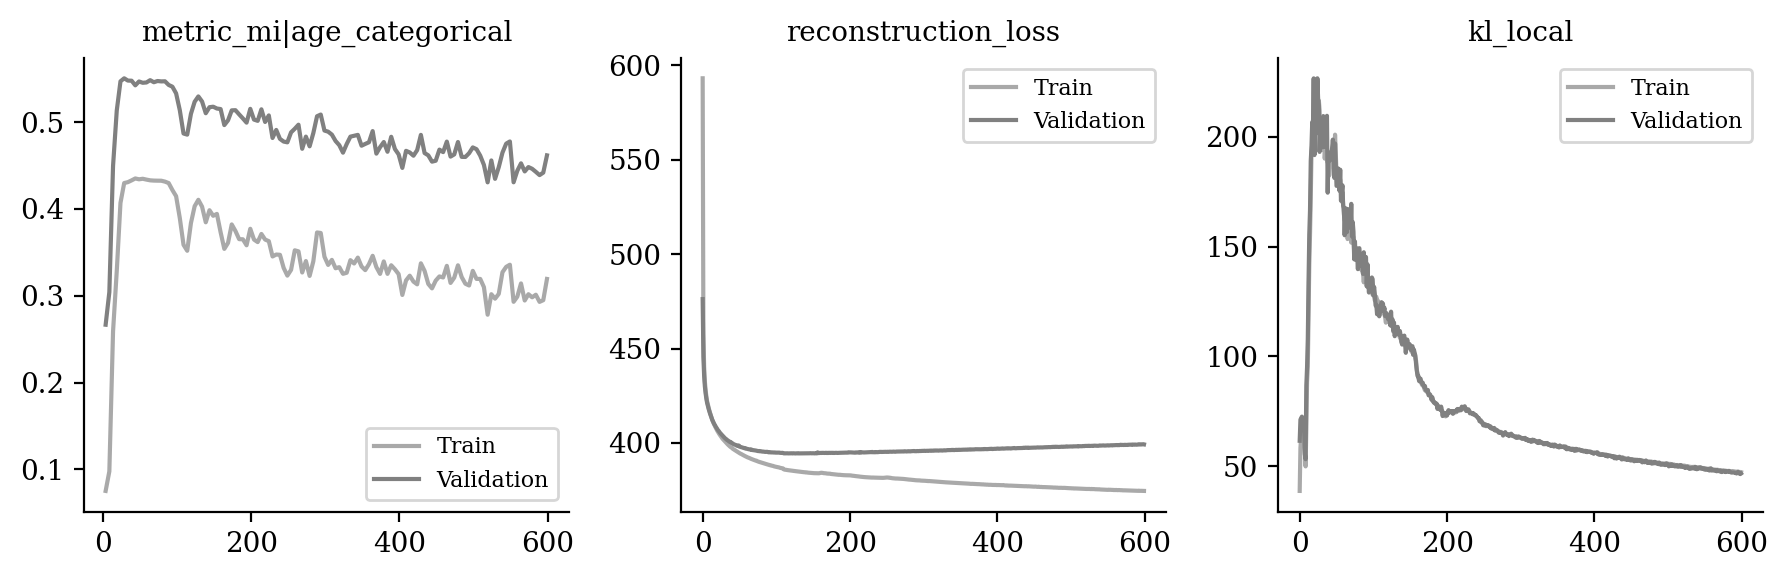

In [11]:
vae.plot_training_history(
    ignore_first=0,
    n_col=4,
    metrics_name=["metric_mi|age_categorical", "reconstruction_loss", "kl_local"]
)

In [12]:
from tardis._disentanglementmanager import DisentanglementManager as DM

In [13]:
sublatent = DM.configurations.get_by_obs_key("age_training").reserved_latent_indices
latent = ad.AnnData(X=vae.get_latent_representation()[:, sublatent], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

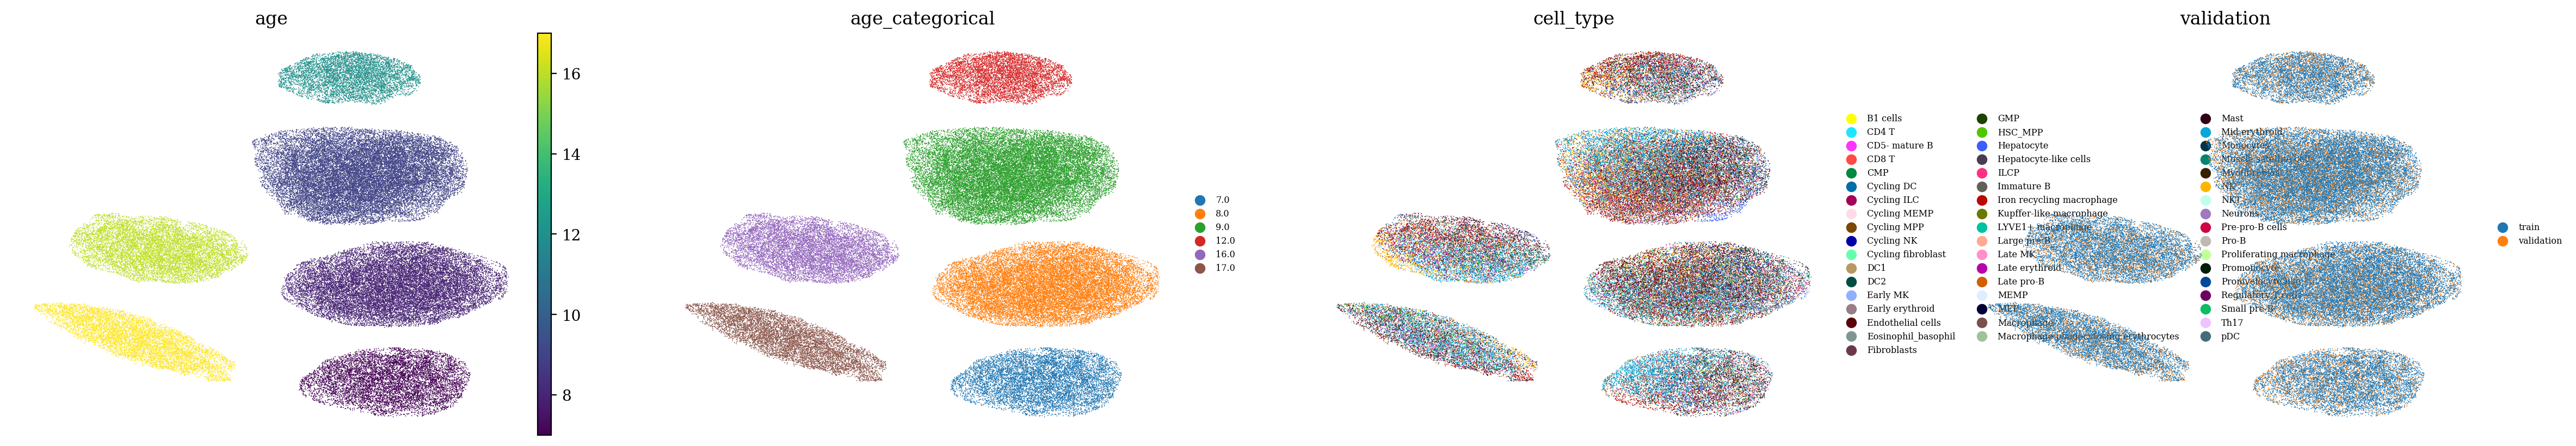

In [14]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=['age', 'age_categorical', 'cell_type', 'validation'], 
        ncols=4,
        frameon=False,
        legend_fontsize="xx-small"
    )

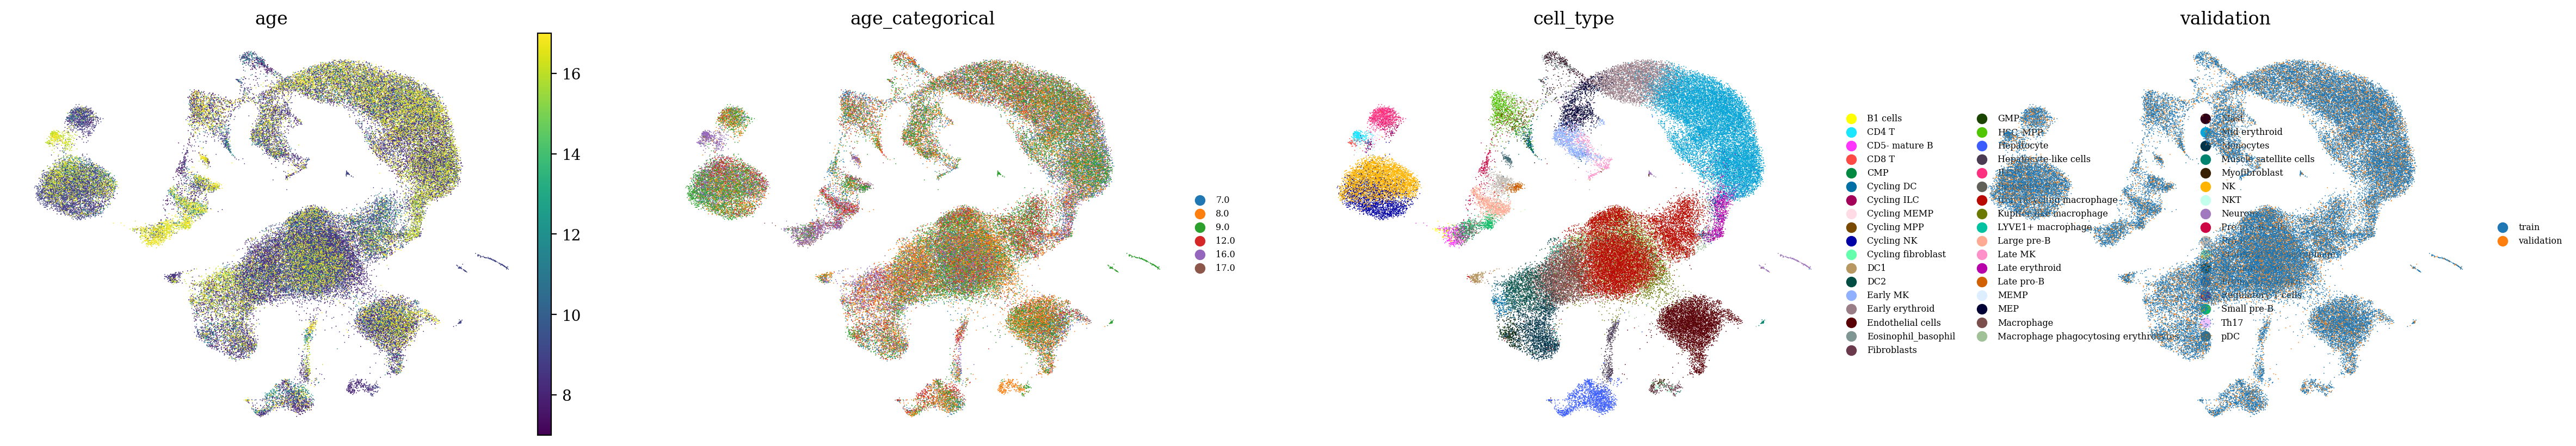

In [15]:
sublatent = DM.configurations.unreserved_latent_indices
latent = ad.AnnData(X=vae.get_latent_representation()[:, sublatent], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=['age', 'age_categorical', 'cell_type', 'validation'], 
        ncols=4,
        frameon=False,
        legend_fontsize="xx-small"
    )

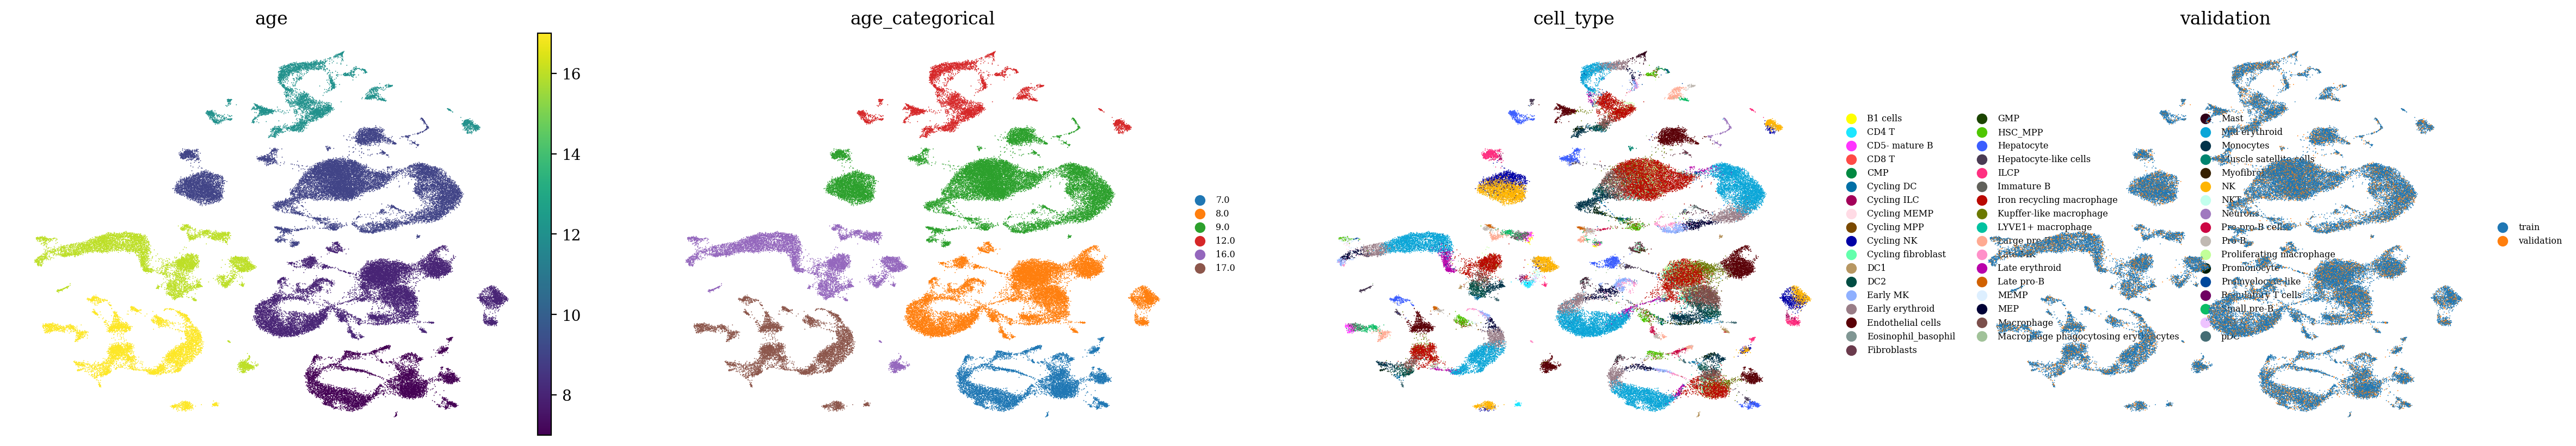

In [16]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=['age', 'age_categorical', 'cell_type', 'validation'], 
        ncols=4,
        frameon=False,
        legend_fontsize="xx-small"
    )